# Palliative-Connect-Outpatient

> Corey Chivers, PhD

Predict risk of 6 month mortality for a general population of all Penn Medicine adult patients to improve access to palliative care for those most likely to benefit.

- Using Oncology Encounters, 6 months labs, and dx history

In [1]:
%pylab inline

import pandas as pd
import re

pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

# Cohort

In [4]:
COHORT_FROM_DATE = '2016-02-01'
COHORT_TO_DATE = '2016-07-01'
VERSION = '1_3'

In [5]:
q = """
select id.identity_id as EMPI, 
 PE.PAT_ENC_CSN_ID AS CSN
 ,p.PAT_ID
 ,PE.APPT_TIME
 ,cd.DEPARTMENT_NAME
 ,cd.SPECIALTY,cd.EXTERNAL_NAME
 ,cs.EXTERNAL_NAME as PROVIDER_NAME
 ,PROV_TYPE
 ,p.DEATH_DATE
 ,p.BIRTH_DATE
 ,p.SEX_C
from PAT_ENC pe
LEFT JOIN PATIENT p
  ON pe.PAT_ID = p.PAT_ID
INNER JOIN IDENTITY_ID ID
  ON  pe.PAT_ID = ID.PAT_ID
  AND ID.IDENTITY_TYPE_ID = 105
inner join CLARITY_DEP cd
  on pe.DEPARTMENT_ID = cd.DEPARTMENT_ID
  and pe.CONTACT_DATE >='COHORT_FROM_DATE'
  and pe.CONTACT_DATE < 'COHORT_TO_DATE'
inner JOIN ZC_DISP_ENC_TYPE ZDET
  ON PE.ENC_TYPE_C = ZDET.DISP_ENC_TYPE_C
INNER JOIN ZC_APPT_STATUS ZAS
  ON PE.APPT_STATUS_C = ZAS.APPT_STATUS_C
left join clarity_ser cs
  on pe.VISIT_PROV_ID = cs.PROV_ID
where cd.specialty in ('Oncology','Hematology/Oncology')
 AND ZDET.NAME IN ('Office Visit','Appointment')
AND ZAS.NAME ='Completed'
"""


q = re.sub('COHORT_FROM_DATE',COHORT_FROM_DATE,q)
q = re.sub('COHORT_TO_DATE',COHORT_TO_DATE,q)

enc_data = SQLquery2df(q,conn)
enc_data.shape

(62380, 12)

In [1]:
#enc_data.head()

In [7]:
enc_data['EMPI'].nunique()

26527

In [8]:
enc_data['DEATH_DATE'] = pd.to_datetime(enc_data['DEATH_DATE'])

In [9]:
enc_data.dtypes

APPT_TIME          datetime64[ns]
BIRTH_DATE         datetime64[ns]
CSN                        object
DEATH_DATE         datetime64[ns]
DEPARTMENT_NAME            object
EMPI                       object
EXTERNAL_NAME              object
PAT_ID                     object
PROVIDER_NAME              object
PROV_TYPE                  object
SEX_C                      object
SPECIALTY                  object
dtype: object

In [10]:
idb_already_dead = (enc_data['DEATH_DATE'] < enc_data['APPT_TIME']) & pd.notnull(enc_data['DEATH_DATE'])
enc_data = enc_data[~idb_already_dead]
enc_data.shape

(62377, 12)

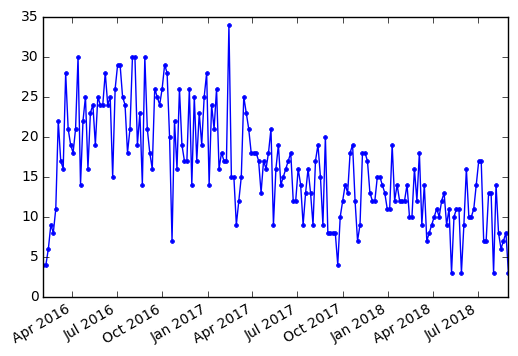

In [11]:
deaths = enc_data[pd.notnull(enc_data['DEATH_DATE'])].drop_duplicates('EMPI').copy()
deaths['count'] = 1

ts = deaths.set_index('DEATH_DATE').resample('5d',how=sum).fillna(0)
fig, ax = plt.subplots(1,1)
ax.plot_date(ts.index,ts['count'],'.-')
fig.autofmt_xdate()

In [12]:
deaths['count'].sum(),deaths['count'].sum()*1.0/enc_data['EMPI'].nunique()

(3024, 0.11400565504241282)

# Labs

In [14]:
q = """
SELECT
  ii.IDENTITY_ID as EMPI,
  o.PAT_ID,
  o.RESULT_TIME,
  z7.NAME ORDER_PRIORITY,
  cc.NAME,
  cc.EXTERNAL_NAME,
  cc.BASE_NAME,
  cc.COMMON_NAME,
  cc.LOINC_CODE,
  o_r.ORD_NUM_VALUE,
  o_r.REFERENCE_LOW,
  o_r.REFERENCE_HIGH,
  z10.NAME RESULT_FLAG,
  o_r.RESULT_IN_RANGE_YN
from (
    select distinct(p.PAT_ID)
    from PAT_ENC pe
    LEFT JOIN PATIENT p
      ON pe.PAT_ID = p.PAT_ID
    INNER JOIN IDENTITY_ID ID
      ON  pe.PAT_ID = ID.PAT_ID
      AND ID.IDENTITY_TYPE_ID = 105
    inner join CLARITY_DEP cd
      on pe.DEPARTMENT_ID = cd.DEPARTMENT_ID
      and pe.CONTACT_DATE >='COHORT_FROM_DATE'
      and pe.CONTACT_DATE < 'COHORT_TO_DATE'
    inner JOIN ZC_DISP_ENC_TYPE ZDET
      ON PE.ENC_TYPE_C = ZDET.DISP_ENC_TYPE_C
    INNER JOIN ZC_APPT_STATUS ZAS
      ON PE.APPT_STATUS_C = ZAS.APPT_STATUS_C
    left join clarity_ser cs
      on pe.VISIT_PROV_ID = cs.PROV_ID
    where cd.specialty in ('Oncology','Hematology/Oncology')
     AND ZDET.NAME IN ('Office Visit','Appointment')
    AND ZAS.NAME ='Completed'
) cohort
  left join ORDER_PROC o on o.PAT_ID = cohort.PAT_ID
  left join PATIENT p on p.PAT_ID = o.PAT_ID
  left join IDENTITY_ID ii on ii.PAT_ID = p.PAT_ID
    and IDENTITY_TYPE_ID = 105
  inner join ORDER_RESULTS o_r on o_r.ORDER_PROC_ID = o.ORDER_PROC_ID
  left join CLARITY_COMPONENT cc on cc.COMPONENT_ID = o_r.COMPONENT_ID
  left join ZC_ORDER_CLASS z1 on z1.ORDER_CLASS_C = o.ORDER_CLASS_C
  left join ZC_ORDER_TYPE z2 on z2.ORDER_TYPE_C = o.ORDER_TYPE_C
  left join ZC_LAB_STATUS z3 on z3.LAB_STATUS_C = o.LAB_STATUS_C
  left join ZC_ORDER_STATUS z4 on z4.ORDER_STATUS_C = o.ORDER_STATUS_C
  left join ZC_REASON_FOR_CANC z5 on z5.REASON_FOR_CANC_C = o.REASON_FOR_CANC_C
  left join ZC_RADIOLOGY_STS z6 on z6.RADIOLOGY_STATUS_C = o.RADIOLOGY_STATUS_C
  left join ZC_ORDER_PRIORITY z7 on z7.ORDER_PRIORITY_C = o.ORDER_PRIORITY_C
  left join ZC_SPECIMEN_TYPE z8 on z8.SPECIMEN_TYPE_C = o.SPECIMEN_TYPE_C
  left join ZC_SPECIMEN_SOURCE z9 on z9.SPECIMEN_SOURCE_C = o.SPECIMEN_SOURCE_C
  left join ZC_RESULT_FLAG z10 on z10.RESULT_FLAG_C = o_r.RESULT_FLAG_C
  left join ZC_RESULT_STATUS z11 on z11.RESULT_STATUS_C = o_r.RESULT_STATUS_C
  left join ZC_LAB_STATUS z12 on z12.LAB_STATUS_C = o_r.LAB_STATUS_C
  left join ZC_LAB_DATA_TYPE z13 on z13.LAB_DATA_TYPE_C = o_r.DATA_TYPE_C
  left join ZC_RES_DATA_TYPE z14 on z14.RES_DATA_TYPE_C = o_r.DATA_TYPE_C
WHERE z11.NAME = 'Final'
  AND o_r.ORD_NUM_VALUE != 9999999 AND o_r.ORD_NUM_VALUE is not NULL
  AND o_r.RESULT_TIME >= 'N_MONTHS_PRIOR' 
  AND o_r.RESULT_TIME <= 'COHORT_TO_DATE'
"""

N_MONTHS_PRIOR = (pd.to_datetime(COHORT_FROM_DATE) - datetime.timedelta(6*30))
N_MONTHS_PRIOR = N_MONTHS_PRIOR.strftime('%Y-%m-%d')

q = re.sub('COHORT_FROM_DATE',COHORT_FROM_DATE,q)
q = re.sub('COHORT_TO_DATE',COHORT_TO_DATE,q)
q = re.sub('N_MONTHS_PRIOR',N_MONTHS_PRIOR,q)

lab_data = SQLquery2df(q,conn)
lab_data.shape

In [ ]:
8131978

In [27]:
top_lab_names = lab_data['EXTERNAL_NAME'].value_counts().head(100)
top_lab_names

MCV                               189496
RDW                               189399
MCH                               189355
MCHC                              188756
Hemoglobin                        188461
Hematocrit                        187573
Platelets                         186375
Creatinine                        181154
Red Blood Cells                   181058
White Blood Cells                 180389
Sodium                            172656
Urea Nitrogen                     170838
Chloride                          170349
Potassium                         169269
Anion Gap                         168003
Carbon Dioxide                    167610
Glucose                           167387
Calcium                           166244
ALT                               125911
AST                               125881
Bilirubin, Total                  124979
Alkaline Phosphatase              120096
# Eosinophils                     117553
# Basophils                       117544
# Monocytes     

In [28]:
model = {'top_lab_names': top_lab_names.index}

In [29]:
lab_data = lab_data[lab_data['EXTERNAL_NAME'].isin(model['top_lab_names'])]
lab_data.shape

(6726731, 14)

In [7]:
#lab_data.head()

In [31]:
lab_data['count'] = 1

In [32]:
rnd_idx = list(lab_data.index)
np.random.shuffle(rnd_idx)
ld = lab_data.loc[rnd_idx[:100000],:]

MCV RDW MCH MCHC Hemoglobin Hematocrit Platelets Creatinine Red Blood Cells White Blood Cells Sodium Urea Nitrogen Chloride Potassium Anion Gap Carbon Dioxide Glucose Calcium ALT AST Bilirubin, Total Alkaline Phosphatase # Eosinophils # Basophils # Monocytes # Lymphocytes % Monocytes % Lymphocytes # Neutrophils % Eosinophils % Basophils % Neutrophils Albumin Protein, Total POC Glucose (Fingerstick) MAGNESIUM % Nucleated RBC INR WBC Corrected PT VSS Fractions Prescribed VSS Dose Given To Date VSS Total Dose Limit VSS Fractions Treated # Band Neutrophils % Basophils Manual % Eosinophils Manual % Band Neutrophils % Lymph Variants # Atypical Lymphocytes % Segmented Neutrophils Manual % Monocytes Manual % Lymphocytes Manual # Segmented Neutrophils Manual PHOSPHATE PTT # Basophils Manual # Eosinophils Manual # Monocytes Manual # Lymphocytes Manual LACTATE DEHYDROGENASE INDIRECT BILI Bilirubin, Direct URIC ACID eGFR, Non-AA T Axis Ventricular Rate QRS Duration R Axis QTC Calculation(Bazett) Q

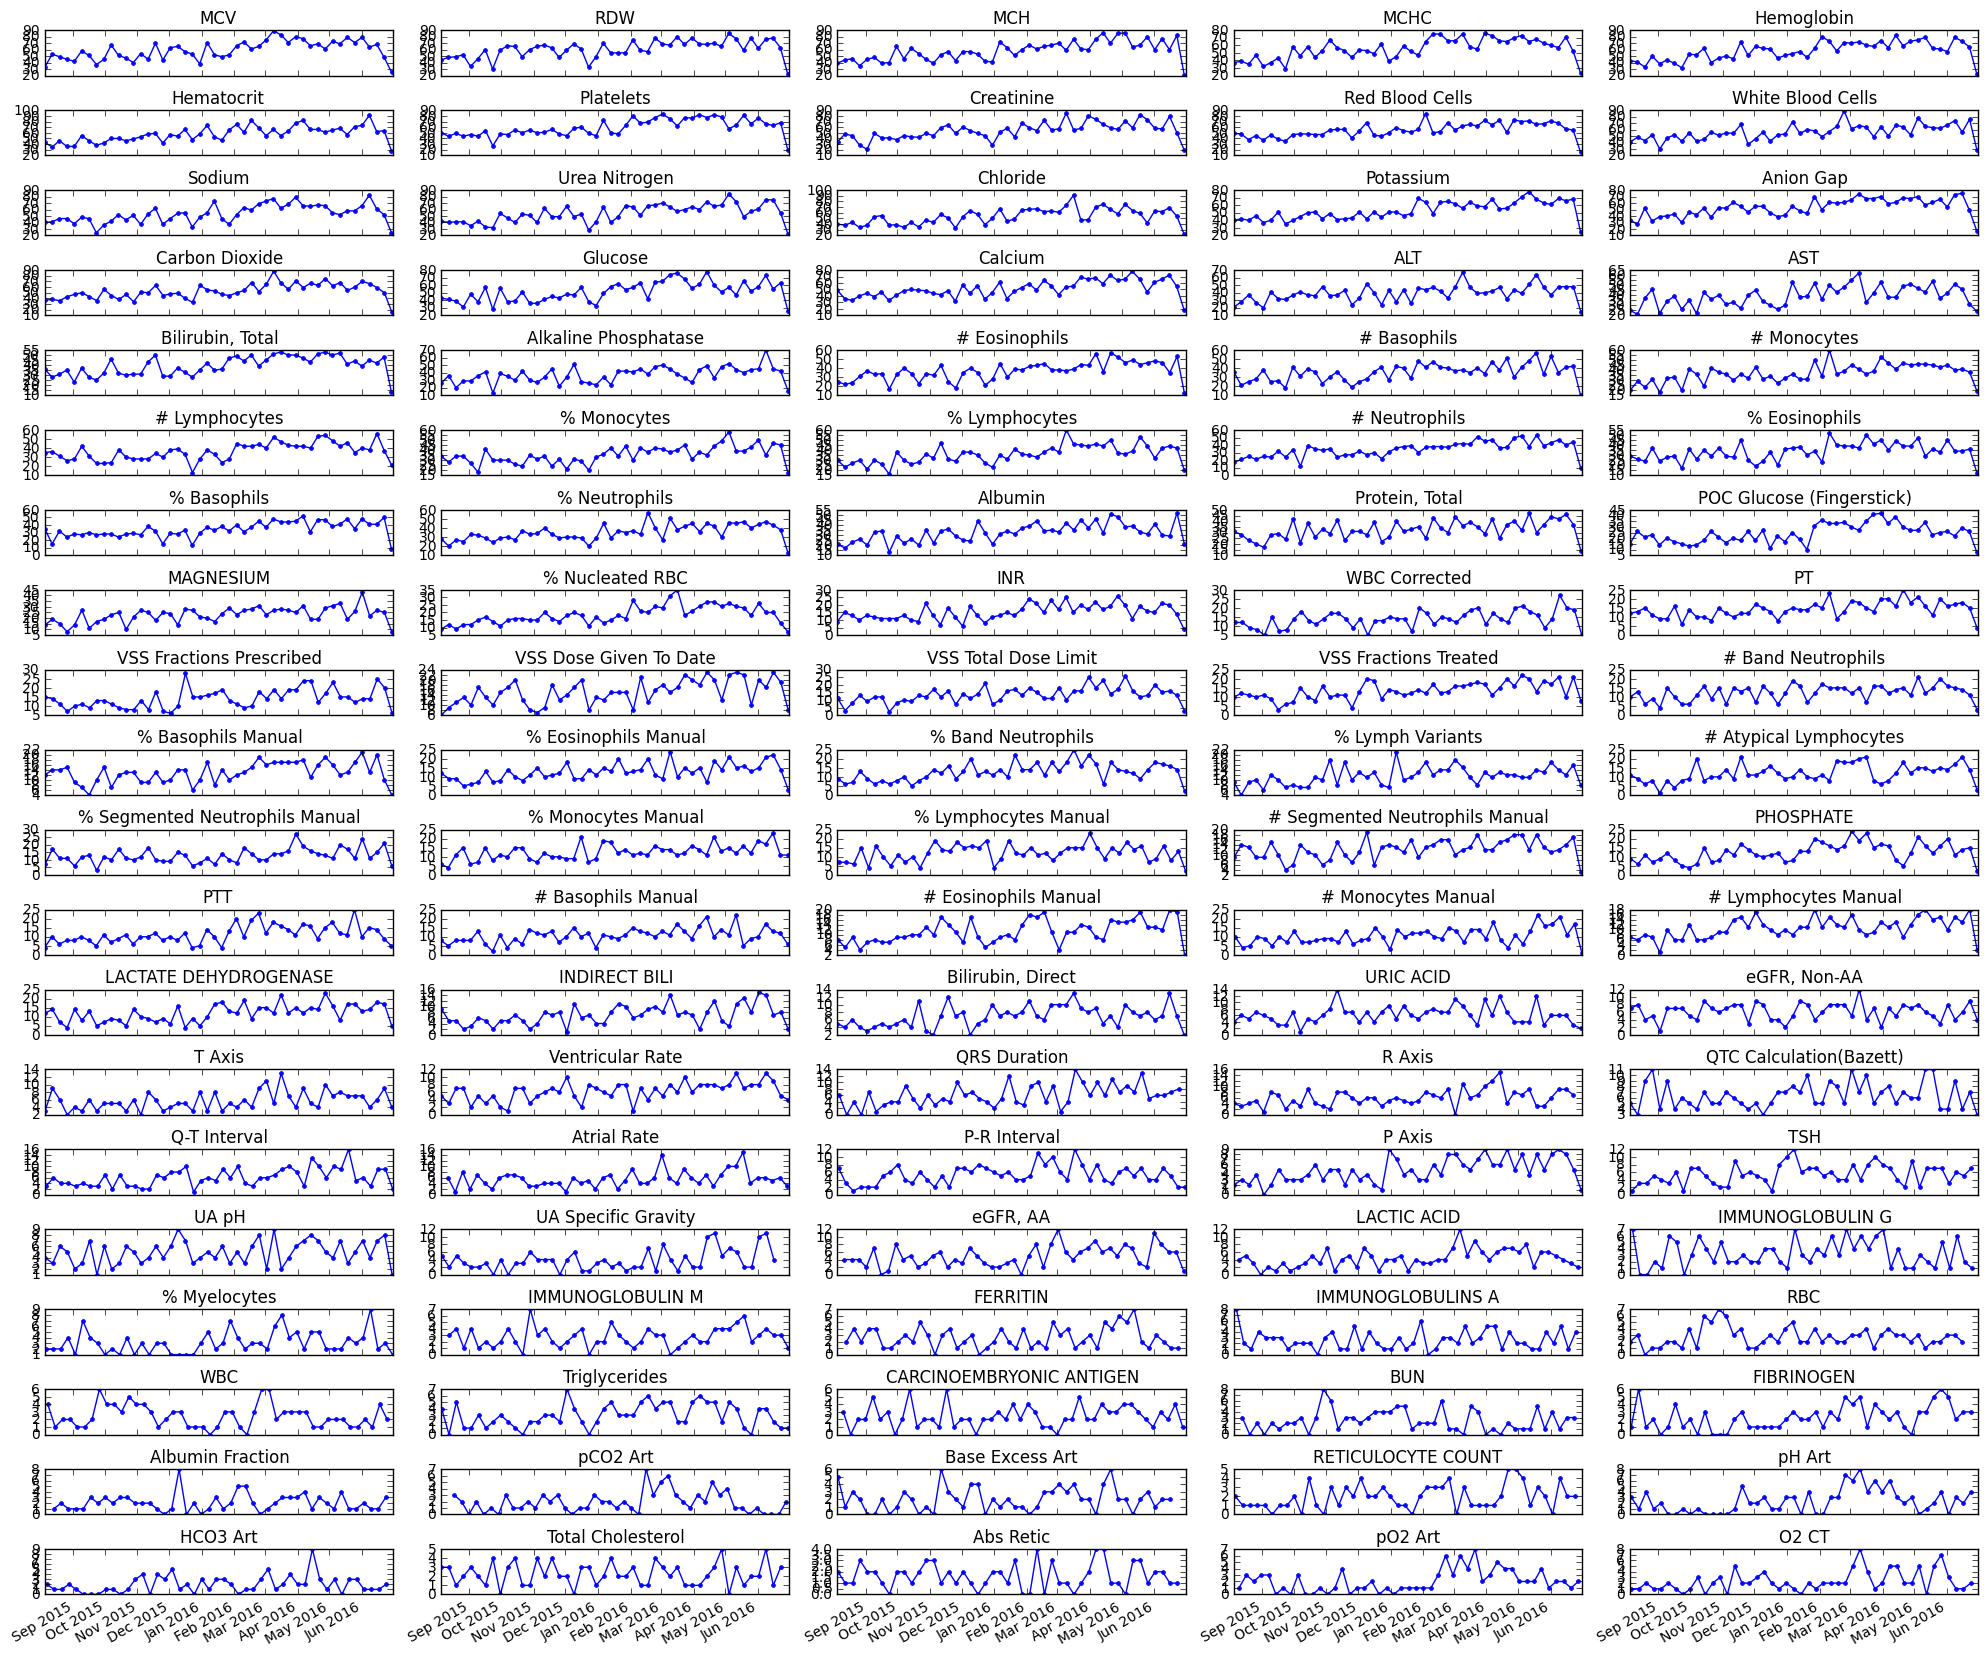

In [33]:
fig, axx = plt.subplots(20,5, figsize=(20,20),sharex=True)

for i,lab_name in enumerate(top_lab_names.index):
    tmp = ld[ld['EXTERNAL_NAME'] == lab_name][['EMPI','RESULT_TIME','count']]
    ts = tmp.set_index('RESULT_TIME').resample('7d',how=sum).fillna(0)

    ax = axx[i/5,i%5]
    
    ax.plot_date(ts.index,ts['count'],'.-')
    ax.set_title(lab_name)
    print lab_name,
fig.tight_layout()
fig.autofmt_xdate()

In [53]:
def get_numeric_features_one_patient(df, name, vn):
    g2 = df[(df['RESULT_TIME'] < vn[1]) & (df['RESULT_TIME'] > (vn[1]-datetime.timedelta(6*30)))].sort('RESULT_TIME')
    val = g2['ORD_NUM_VALUE']
    val = val[pd.notnull(val)]
    prop_stat = (g2['ORDER_PRIORITY'] == 'STAT').mean()
    if val.shape[0] > 0:
        std = val.std()
        if pd.isnull(std):
            std = 0.0
        return {
            'EMPI': vn[0],
            'APPT_TIME': vn[1],
            '{}: prop STAT ordered'.format(name): prop_stat,
            '{}: count'.format(name): val.count(),
            '{}: min'.format(name): val.min(),
            '{}: max'.format(name): val.max(),
            '{}: mean'.format(name): val.mean(),
            '{}: std'.format(name): std,
            '{}: first'.format(name): val.iloc[0],
            '{}: last'.format(name): val.iloc[-1],
        }
    else:
        return {
            'EMPI': vn[0],
            'APPT_TIME': vn[1],
            '{}: prop STAT ordered'.format(name): 0,
            '{}: count'.format(name): 0,
            '{}: std'.format(name): 0,
        }

def get_numeric_features(df, name):
    agg_df = []
    for vn, g in df[df['EXTERNAL_NAME'] == name].groupby(['EMPI','APPT_TIME']):
        agg_df.append(get_numeric_features_one_patient(g, name, vn))
    return pd.DataFrame(agg_df)


In [35]:
enc_data['EMPI'] = enc_data['EMPI'].astype(int)
lab_data['EMPI'] = lab_data['EMPI'].astype(int)

In [36]:
lab_data.shape

(6726731, 15)

In [37]:
lab_data['ORDER_PRIORITY'].value_counts(dropna=False)

Routine                  4687426
STAT                     2031943
Today                       4677
Transplant (Lab Only)       2660
After xray                    25
NaN                            0
dtype: int64

In [38]:
labs_joined = enc_data[['EMPI','APPT_TIME']].merge(lab_data,how='left',on='EMPI')
labs_joined.shape

(30829061, 16)

In [3]:
#labs_joined.head()

In [2]:
#get_numeric_features(labs_joined.head(100000), name='MCV').head(20)

In [50]:
top_lab_names.head(15)

MCV                  189496
RDW                  189399
MCH                  189355
MCHC                 188756
Hemoglobin           188461
Hematocrit           187573
Platelets            186375
Creatinine           181154
Red Blood Cells      181058
White Blood Cells    180389
Sodium               172656
Urea Nitrogen        170838
Chloride             170349
Potassium            169269
Anion Gap            168003
dtype: int64

In [56]:
num_cols = []
vectorized_features_num = None
for name in top_lab_names.index:
    print name,
    agg_df = get_numeric_features(labs_joined, name=name)
    if vectorized_features_num is None:
        vectorized_features_num = agg_df
    else:
        if agg_df.shape[0] > 0:
            num_cols.extend([c for c in agg_df if c not in ['APPT_TIME','EMPI']])
            vectorized_features_num = vectorized_features_num.merge(agg_df, on=['APPT_TIME','EMPI'], how='outer')
vectorized_features_num.shape

In [27]:
for c in num_cols:
    if c in enc_data:
        del enc_data[c]

In [28]:
enc_data.shape

(62377, 12)

In [29]:
enc_data = enc_data.merge(vectorized_features_num,how='outer',on=['APPT_TIME','EMPI'])

In [34]:
enc_data.shape

(62377, 774)

In [126]:
# Write
#enc_data.to_csv('OutpatientONC_v1_1_enc_w_labs.csv',index=False)

# Read
enc_data = pd.read_csv('OutpatientONC_v1_1_enc_w_labs.csv',dtype={'PAT_ID':str})
enc_data.shape

(62377, 774)

In [129]:
top_lab_names = list(set([re.sub('\: .*','',c) for c in enc_data if ': ' in c]))

In [130]:
model = {'top_lab_names': top_lab_names}

In [131]:
enc_data['EMPI'].nunique()

26525

In [132]:
enc_data['APPT_TIME'] = pd.to_datetime(enc_data['APPT_TIME'])
enc_data['EMPI'] = enc_data['EMPI'].astype(int)

# Dx

In [152]:
ELIXHAUSER = {
              'CHF':{'label':'Congestive heart failure',
                       'icd10': ['I099', 'I1(10|3[02])', 'I255', 'I4(2[056789]|3)', 'I50', 'P290'],
                       'icd9': ['39891', '402(01|11|91)', '404(01|03|[19][13])', '42(5[456789]|8)']},
              'Arrhy':{'label':'Cardiac arrhythmias',
                      'icd10': ['I44[123]', 'I456', 'I459','I4[789]', 'R00[018]', 'T821','Z[49]50'],
                      'icd9':['426([079]|1[023])', '427[01234]','V450', 'V533']},
              'VD':{'label':'Valvular disease',
                      'icd10': ['A520', 'I0[5678]','I09[18]', 'I3[456789]','Q23[0123]', 'Z95[234]'],
                      'icd9':['0932', '39[4567]', '424','746[3456]', 'V422', 'V433']},
              'PCD':{'label':'Pulmonary circulation disorder',
                      'icd10': ['I2([67]|8[089])'],
                      'icd9':['415[01]', '416','417[089]']},
              'PVD':{'label':'Pulmonary valvular discorder',
                      'icd10': ['I7([01]|3[189]|71|9[02])', 'K55[189]', 'Z95[89]'],
                      'icd9': ['0930', '4373', '44([01]|3[123456789])', '4471', '557[19]', 'V434']},
              'HPTN_UC':{'label':'Hypertension, uncomplicated',
                      'icd10': ['I10'],
                      'icd9':['401']},
              'HPTN_C':{'label':'Hypertension, complicated',
                      'icd10': ['I1[1235]'],
                      'icd9':['40[2345]']},
              'Paralysis':{'label':'Paralysis',
                      'icd10': ['G041', 'G114', 'G8(0[12]|[12]|3[012349])'],
                      'icd9': ['3341', '34([23]|4[01234569])']},
              'OthND':{'label':'Other neurological disorders',
                      'icd10':['G1[0123]', 'G2[012]', 'G25[45]','G31[289]','G3[2567]','G4[01]', 'G93[14]','R470', 'R56'],
                      'icd9': ['3319', '332[01]','333[45]','33([45]|62)','34([015]|8[13])','78[04]3']},
              'COPD':{'label':'Chronic pulmonary disease',
                      'icd10': ['I27[89]', 'J4[01234567]', 'J6([01234567]|84)', 'J70[13]'],
                      'icd9': ['416[89]', '49', '50([012345]|64|8[18])']},
              'Diab_UC':{'label':'Diabetes uncomplicated',
                      'icd10': ['E1[01234][019]'],
                      'icd9': ['250[0123]']},
              'Diab_C':{'label':'Diabetes complicated',
                      'icd10': ['E1[01234][2345678]'],
                      'icd9': ['250[456789]']},
              'Hptothy':{'label':'Hypothyroidism',
                      'icd10': ['E0[0123]', 'E890'],
                      'icd9':['2409', '24([34]|6[18])']},
              'RF':{'label':'Renal failure',
                      'icd10': ['I120', 'I131', 'N1[89]', 'N250', 'Z49[012]', 'Z940', 'Z992'],
                      'icd9': ['403', '404', '58([56]|80)', 'V4(20|51)', 'V56']},
              'LD':{'label':'Liver disease',
                      'icd10': ['B18', 'I8(5|64)', 'I982', 'K7(0|1[13457]|[234]|6[023456789])', 'Z944'],
                      'icd9': ['070([23]|[45])', '456[012]', '57([01]|2[2345678]|3[3489])', 'V427']},
              'PUD_NB':{'label':'Peptic ulcer disease excluding bleeding',
                      'icd10': ['K2[5678][79]'],
                      'icd9': ['53[1234][79]']},
              'HIV':{'label':'AIDS/HIV',
                      'icd10': ['B2[0124]'],
                      'icd9': ['04[234]']},
              'Lymp':{'label':'Lymphoma',
                      'icd10': ['C8[123458]','C96', 'C90[02]'],
                      'icd9':['20[012]', '2030', '2386']},
              'METS':{'label':'Metastatic cancer',
                      'icd10': ['C7[789]', 'C80'],
                      'icd9': ['19[6789]']},
              'Tumor':{'label':'Solid tumor without metastasis',
                      'icd10': ['C[01]', 'C2[0123456]','C3[01234789]', 'C4[01356789]', 'C5[012345678]','C6', 'C7[0123456]', 'C97'],
                      'icd9': ['1[456]', '17[012456789]', '18', '19([012345])']},
              'Rheum_A':{'label':'Rheumatoid arthritis/collagen vascular diseases',
                      'icd10': ['L94[013]', 'M0[568]', 'M12[03]','M3(0|1[0123]|[2345])', 'M4(5|6[189])'],
                      'icd9': ['446', '7010', '71(0[0123489]|12|4|93)', '72([05]|8[58]|93)']},
              'Coag':{'label':'Coagulopathy',
                     'icd10': ['D6[5678]','D69[13456]'],
                      'icd9':['286', '2871', '287[345]']},
              'Obesity':{'label':'Obesity',
                      'icd10': ['E66'],
                      'icd9':['2780']},
              'WL':{'label':'Weight loss',
                      'icd10':['E4[0123456]', 'R634', 'R64'],
                      'icd9':['26[0123]', '7832', '7994']},
              'Fluid':{'label':'Fluid and electroylte disorders',
                      'icd10': ['E222', 'E8[67]'],
                      'icd9':['2536', '276']},
              'BLA':{'label':'Blood loss anemia',
                      'icd10': ['D500'],
                      'icd9':['2800']},
              'DA':{'label':'Deficiency anemia',
                      'icd10': ['D50[89]', 'D5[123]'],
                      'icd9':['280[123456789]', '281']},
              'Alcohol':{'label':'Alcohol abuse',
                      'icd10': ['F10', 'E52', 'G621', 'I426','K292', 'K70[039]','T51', 'Z502','Z714', 'Z721'],
                      'icd9':['2652', '291[12356789]','303[09]', '3050', '3575','4255', '5353', '571[0123]', '980', 'V113']},
              'Drug':{'label': 'Drug abuse',
                      'icd10': ['F1[12345689]','Z715', 'Z722'],
                      'icd9':['292', '304', '305[23456789]', 'V6542']},
              'Psych':{'label':'Psychoses',
                      'icd10': ['F2[0234589]','F3([01]2|15)'],
                      'icd9':['2938','296[0145]4','29[578]']},
              'Dep':{'label':'Depression',
                      'icd10': ['F204','F31[345]', 'F3[23]','F341', 'F4[13]2'],
                      'icd9':['296[235]','3004', '309', '311']}
}

In [204]:
pd.DataFrame(ELIXHAUSER).T.to_clipboard()
pd.DataFrame(ELIXHAUSER).T

icd10  \
Alcohol    [F10, E52, G621, I426, K292, K70[039], T51, Z5...   
Arrhy      [I44[123], I456, I459, I4[789], R00[018], T821...   
BLA                                                   [D500]   
CHF        [I099, I1(10|3[02]), I255, I4(2[056789]|3), I5...   
COPD       [I27[89], J4[01234567], J6([01234567]|84), J70...   
Coag                                  [D6[5678], D69[13456]]   
DA                                        [D50[89], D5[123]]   
Dep                  [F204, F31[345], F3[23], F341, F4[13]2]   
Diab_C                                  [E1[01234][2345678]]   
Diab_UC                                     [E1[01234][019]]   
Drug                              [F1[12345689], Z715, Z722]   
Fluid                                         [E222, E8[67]]   
HIV                                               [B2[0124]]   
HPTN_C                                            [I1[1235]]   
HPTN_UC                                                [I10]   
Hptothy                                     [E0[0123], E890]   
LD         [B18, I8(5|64), I982, K7(0|1[13457]|[234]|6[02...   
Lymp                              [C8[123458], C96, C90[02]]   
METS                                          [C7[789], C80]   
Obesity                                                [E66]   
OthND      [G1[0123], G2[012], G25[45], G31[289], G3[2567...   
PCD                                        [I2([67]|8[089])]   
PUD_NB                                        [K2[5678][79]]   
PVD            [I7([01]|3[189]|71|9[02]), K55[189], Z95[89]]   
Paralysis             [G041, G114, G8(0[12]|[12]|3[012349])]   
Psych                            [F2[0234589], F3([01]2|15)]   
RF          [I120, I131, N1[89], N250, Z49[012], Z940, Z992]   
Rheum_A    [L94[013], M0[568], M12[03], M3(0|1[0123]|[234...   
Tumor      [C[01], C2[0123456], C3[01234789], C4[01356789...   
VD         [A520, I0[5678], I09[18], I3[456789], Q23[0123...   
WL                                  [E4[0123456], R634, R64]   

                                                        icd9  \
Alcohol    [2652, 291[12356789], 303[09], 3050, 3575, 425...   
Arrhy            [426([079]|1[023]), 427[01234], V450, V533]   
BLA                                                   [2800]   
CHF        [39891, 402(01|11|91), 404(01|03|[19][13]), 42...   
COPD                    [416[89], 49, 50([012345]|64|8[18])]   
Coag                                   [286, 2871, 287[345]]   
DA                                     [280[123456789], 281]   
Dep                               [296[235], 3004, 309, 311]   
Diab_C                                         [250[456789]]   
Diab_UC                                          [250[0123]]   
Drug                        [292, 304, 305[23456789], V6542]   
Fluid                                            [2536, 276]   
HIV                                                [04[234]]   
HPTN_C                                            [40[2345]]   
HPTN_UC                                                [401]   
Hptothy                               [2409, 24([34]|6[18])]   
LD         [070([23]|[45]), 456[012], 57([01]|2[2345678]|...   
Lymp                                   [20[012], 2030, 2386]   
METS                                              [19[6789]]   
Obesity                                               [2780]   
OthND      [3319, 332[01], 333[45], 33([45]|62), 34([015]...   
PCD                                 [415[01], 416, 417[089]]   
PUD_NB                                        [53[1234][79]]   
PVD        [0930, 4373, 44([01]|3[123456789]), 4471, 557[...   
Paralysis                       [3341, 34([23]|4[01234569])]   
Psych                            [2938, 296[0145]4, 29[578]]   
RF                   [403, 404, 58([56]|80), V4(20|51), V56]   
Rheum_A    [446, 7010, 71(0[0123489]|12|4|93), 72([05]|8[...   
Tumor              [1[456], 17[012456789], 18, 19([012345])]   
VD              [0932, 39[4567], 424, 746[3456], V422, V433]   
WL                    

In [206]:
## get counts per EMPI before time of prediction
vc_comorbs = {}
vc_comorbs_last_6months = {}
observed_codes = {}
for comorbidity in ELIXHAUSER.keys():
    # Load
    dx_hist = pd.read_csv('Palliative_Data/dx_hist_ELIXHAUSER_{}.csv'.format(comorbidity))
    dx_hist = dx_hist[pd.notnull(dx_hist['EMPI'])]
    dx_hist['EMPI'] = dx_hist['EMPI'].astype(int)
    dx_hist['ENC_DATE'] = pd.to_datetime(dx_hist['ENC_DATE'])
    
    # Filter out dx after time of pred
    dx_hist = enc_data[['EMPI','APPT_TIME']].merge(dx_hist,how='inner',on='EMPI')
    dx_hist = dx_hist[dx_hist['APPT_TIME'] > dx_hist['ENC_DATE']]
    
    unique_codes = dx_hist.drop_duplicates(['CODE_STANDARD_NAME','CODE'])
    observed_codes[comorbidity] = unique_codes

In [212]:
res = []
for k,v in observed_codes.items():
    res.append({'index':k,
    'ICD-10 Observed':list(v[v['CODE_STANDARD_NAME']=='ICD-10']['CODE'].values),
    'ICD-9 Observed': list(v[v['CODE_STANDARD_NAME']=='ICD-9']['CODE'].values)})
observed_codes_df = pd.DataFrame(res)
elixhauser_df = pd.DataFrame(ELIXHAUSER).T.reset_index()
elixhauser_df = elixhauser_df.merge(observed_codes_df,how='left',on='index')
elixhauser_df.to_clipboard()
elixhauser_df

index                                              icd10  \
0     Alcohol  [F10, E52, G621, I426, K292, K70[039], T51, Z5...   
1       Arrhy  [I44[123], I456, I459, I4[789], R00[018], T821...   
2         BLA                                             [D500]   
3         CHF  [I099, I1(10|3[02]), I255, I4(2[056789]|3), I5...   
4        COPD  [I27[89], J4[01234567], J6([01234567]|84), J70...   
5        Coag                             [D6[5678], D69[13456]]   
6          DA                                 [D50[89], D5[123]]   
7         Dep            [F204, F31[345], F3[23], F341, F4[13]2]   
8      Diab_C                               [E1[01234][2345678]]   
9     Diab_UC                                   [E1[01234][019]]   
10       Drug                         [F1[12345689], Z715, Z722]   
11      Fluid                                     [E222, E8[67]]   
12        HIV                                         [B2[0124]]   
13     HPTN_C                                         [I1[1235]]   
14    HPTN_UC                                              [I10]   
15    Hptothy                                   [E0[0123], E890]   
16         LD  [B18, I8(5|64), I982, K7(0|1[13457]|[234]|6[02...   
17       Lymp                         [C8[123458], C96, C90[02]]   
18       METS                                     [C7[789], C80]   
19    Obesity                                              [E66]   
20      OthND  [G1[0123], G2[012], G25[45], G31[289], G3[2567...   
21        PCD                                  [I2([67]|8[089])]   
22     PUD_NB                                     [K2[5678][79]]   
23        PVD      [I7([01]|3[189]|71|9[02]), K55[189], Z95[89]]   
24  Paralysis             [G041, G114, G8(0[12]|[12]|3[012349])]   
25      Psych                        [F2[0234589], F3([01]2|15)]   
26         RF   [I120, I131, N1[89], N250, Z49[012], Z940, Z992]   
27    Rheum_A  [L94[013], M0[568], M12[03], M3(0|1[0123]|[234...   
28      Tumor  [C[01], C2[0123456], C3[01234789], C4[01356789...   
29         VD  [A520, I0[5678], I09[18], I3[456789], Q23[0123...   
30         WL                           [E4[0123456], R634, R64]   

                                                 icd9  \
0   [2652, 291[12356789], 303[09], 3050, 3575, 425...   
1         [426([079]|1[023]), 427[01234], V450, V533]   
2                                              [2800]   
3   [39891, 402(01|11|91), 404(01|03|[19][13]), 42...   
4                [416[89], 49, 50([012345]|64|8[18])]   
5                               [286, 2871, 287[345]]   
6                               [280[123456789], 281]   
7                          [296[235], 3004, 309, 311]   
8                                       [250[456789]]   
9                                         [250[0123]]   
10                   [292, 304, 305[23456789], V6542]   
11                                        [2536, 276]   
12                                          [04[234]]   
13                                         [40[2345]]   
14                                              [401]   
15                             [2409, 24([34]|6[18])]   
16  [070([23]|[45]), 456[012], 57([01]|2[2345678]|...   
17                              [20[012], 2030, 2386]   
18                                         [19[6789]]   
19                                             [2780]   
20  [3319, 332[01], 333[45], 33([45]|62), 34([015]...   
21                           [415[01], 416, 417[089]]   
22                                     [53[1234][79]]   
23  [0930, 4373, 44([01]|3[123456789]), 4471, 557[...   
24                       [3341, 34([23]|4[01234569])]   
25                        [2938, 296[0145]4, 29[578]]   
26            [403, 404, 58([56]|80), V4(20|51), V56]   
27  [446, 7010, 71(0[0123489]|12|4|93), 72([05]|8[...   
28          [1[456], 17[012456789], 18, 19([012345])]   
29       [0932, 39[4567], 424, 746[3456], V422, V433]   
30                             [26[0123], 7832, 7994]   

      

In [135]:
## get counts per EMPI before time of prediction
vc_comorbs = {}
vc_comorbs_last_6months = {}
for comorbidity in ELIXHAUSER.keys():
    # Load
    dx_hist = pd.read_csv('Palliative_Data/dx_hist_ELIXHAUSER_{}.csv'.format(comorbidity))
    dx_hist = dx_hist[pd.notnull(dx_hist['EMPI'])]
    dx_hist['EMPI'] = dx_hist['EMPI'].astype(int)
    dx_hist['ENC_DATE'] = pd.to_datetime(dx_hist['ENC_DATE'])
    
    # Filter out dx after time of pred
    dx_hist = enc_data[['EMPI','APPT_TIME']].merge(dx_hist,how='inner',on='EMPI')
    dx_hist = dx_hist[dx_hist['APPT_TIME'] > dx_hist['ENC_DATE']]
    
    # groupby EMP and count
    vc_comorbs[comorbidity] = dx_hist[['EMPI','APPT_TIME']].groupby(['EMPI','APPT_TIME']).size().reset_index()
    print comorbidity, vc_comorbs[comorbidity].shape
    
    # Count 'recent' comorbs
    dx_hist = dx_hist[dx_hist['ENC_DATE'] > (dx_hist['APPT_TIME'] - datetime.timedelta(6*30))]
    vc_comorbs_last_6months[comorbidity] = dx_hist[['EMPI','APPT_TIME']].groupby(['EMPI','APPT_TIME']).size().reset_index()

METS (16577, 3)
Diab_UC (7942, 3)
Alcohol (1237, 3)
Rheum_A (4090, 3)
WL (7207, 3)
DA (5694, 3)
Lymp (9848, 3)
Arrhy (7340, 3)
PCD (3926, 3)
LD (4282, 3)
Obesity (6754, 3)
COPD (9825, 3)
HPTN_UC (23099, 3)
Fluid (14642, 3)
RF (5645, 3)
OthND (3054, 3)
PVD (3325, 3)
PUD_NB (1302, 3)
Hptothy (7911, 3)
VD (4248, 3)
CHF (4400, 3)
Dep (8748, 3)
Paralysis (596, 3)
Drug (1589, 3)
Diab_C (3003, 3)
Coag (8158, 3)
BLA (1535, 3)
Tumor (38128, 3)
HIV (384, 3)
HPTN_C (4279, 3)
Psych (840, 3)


In [136]:
# Join to reg_data
dx_cols = []
for comorbidity in ELIXHAUSER.keys():
    comorb_counts = vc_comorbs[comorbidity]
    c_name = 'n_'+comorbidity
    comorb_counts.columns = ['EMPI','APPT_TIME',c_name]
    if c_name in enc_data:
        del enc_data[c_name]
    enc_data = enc_data.merge(comorb_counts, how='left',on=['EMPI','APPT_TIME'])
    enc_data[c_name] = enc_data[c_name].fillna(0)
    dx_cols.append(c_name)
    
    comorb_counts = vc_comorbs_last_6months[comorbidity]
    c_name = 'n_'+comorbidity+'_recent'
    comorb_counts.columns = ['EMPI','APPT_TIME',c_name]
    if c_name in enc_data:
        del enc_data[c_name]
    enc_data = enc_data.merge(comorb_counts, how='left',on=['EMPI','APPT_TIME'])
    enc_data[c_name] = enc_data[c_name].fillna(0)
    dx_cols.append(c_name)

dx_cols

['n_METS',
 'n_METS_recent',
 'n_Diab_UC',
 'n_Diab_UC_recent',
 'n_Alcohol',
 'n_Alcohol_recent',
 'n_Rheum_A',
 'n_Rheum_A_recent',
 'n_WL',
 'n_WL_recent',
 'n_DA',
 'n_DA_recent',
 'n_Lymp',
 'n_Lymp_recent',
 'n_Arrhy',
 'n_Arrhy_recent',
 'n_PCD',
 'n_PCD_recent',
 'n_LD',
 'n_LD_recent',
 'n_Obesity',
 'n_Obesity_recent',
 'n_COPD',
 'n_COPD_recent',
 'n_HPTN_UC',
 'n_HPTN_UC_recent',
 'n_Fluid',
 'n_Fluid_recent',
 'n_RF',
 'n_RF_recent',
 'n_OthND',
 'n_OthND_recent',
 'n_PVD',
 'n_PVD_recent',
 'n_PUD_NB',
 'n_PUD_NB_recent',
 'n_Hptothy',
 'n_Hptothy_recent',
 'n_VD',
 'n_VD_recent',
 'n_CHF',
 'n_CHF_recent',
 'n_Dep',
 'n_Dep_recent',
 'n_Paralysis',
 'n_Paralysis_recent',
 'n_Drug',
 'n_Drug_recent',
 'n_Diab_C',
 'n_Diab_C_recent',
 'n_Coag',
 'n_Coag_recent',
 'n_BLA',
 'n_BLA_recent',
 'n_Tumor',
 'n_Tumor_recent',
 'n_HIV',
 'n_HIV_recent',
 'n_HPTN_C',
 'n_HPTN_C_recent',
 'n_Psych',
 'n_Psych_recent']

In [137]:
DAYS_IN_NS = 8.64e+13

In [138]:
def timedelta_in_years(td):
    if pd.isnull(td):
        return np.nan
    else:
        return float(td)/ (365.25 * DAYS_IN_NS)
    

enc_data['DEATH_DATE'] = pd.to_datetime(enc_data['DEATH_DATE'])
enc_data['BIRTH_DATE'] = pd.to_datetime(enc_data['BIRTH_DATE'])

enc_data['PAT_AGE'] = (enc_data['APPT_TIME'] - enc_data['BIRTH_DATE'])
enc_data['PAT_AGE'] = enc_data['PAT_AGE'].apply(timedelta_in_years)

### Create label

In [139]:
enc_data['label'] = (enc_data['DEATH_DATE'] - enc_data['APPT_TIME']) < (30 * 6 * DAYS_IN_NS)

In [140]:
enc_data['label'].mean()

0.074017666768199819

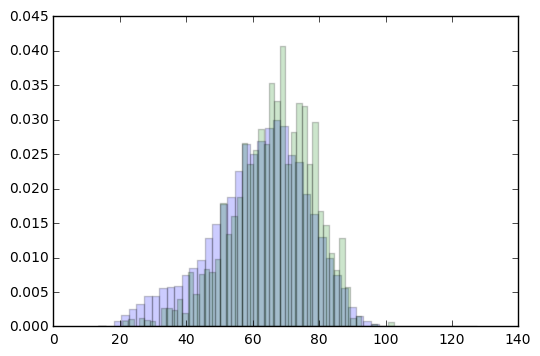

In [141]:
fig, ax = plt.subplots(1,1)
ax.hist(enc_data['PAT_AGE'][~enc_data['label']].values,bins=50,normed=True,alpha=0.2)
ax.hist(enc_data['PAT_AGE'][enc_data['label']].values,bins=50,normed=True,alpha=0.2)
plt.show()

In [142]:
enc_data['PAT_AGE'].min(), enc_data['PAT_AGE'].max()

(13.569929272187998, 127.48906760970416)

# Describe

In [118]:
final_cohort_ids = pd.read_csv('OutpatientONC_v1_1_final_cohort_ids.csv',  dtype={'PAT_ID':str})
enc_data = pd.read_csv('OutpatientONC_v1_1_enc_data_features.csv', dtype={'PAT_ID':str})

In [119]:
enc_data = pd.read_csv('OutpatientONC_v1_1_enc_data_features_v1_3.csv', dtype={'PAT_ID':str})

In [120]:
enc_data['DEATH_DATE'] = pd.to_datetime(enc_data['DEATH_DATE'])
enc_data['APPT_TIME'] = pd.to_datetime(enc_data['APPT_TIME'])

In [121]:
enc_data['APPT_TIME'].head()

0   2016-05-13 09:15:00
1   2016-03-02 10:00:00
2   2016-05-27 15:30:00
3   2016-03-09 13:15:00
4   2016-04-13 09:20:00
Name: APPT_TIME, dtype: datetime64[ns]

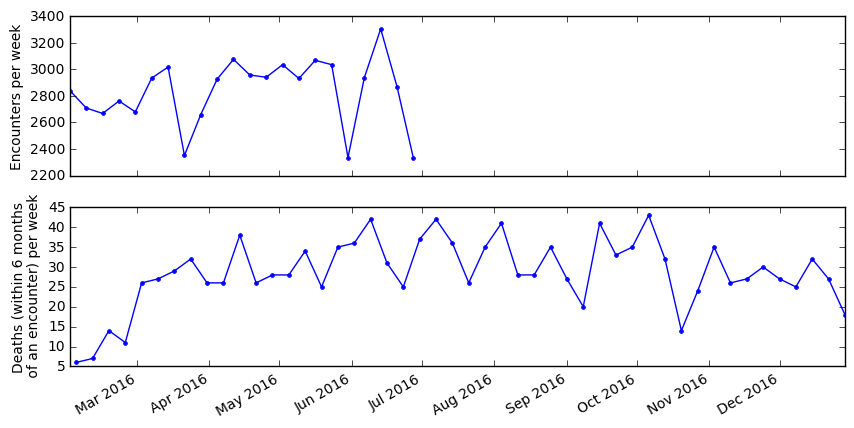

In [122]:
enc_data['count'] = 1

ts = enc_data.set_index('APPT_TIME').resample('7d',how=sum).fillna(0)
fig, ax = plt.subplots(2,1,sharex=True,figsize=(10,5))
ax[0].plot_date(ts.index,ts['count'],'.-',label='Encounters')
ax[0].set_ylabel('Encounters per week')

deaths = enc_data[pd.notnull(enc_data['DEATH_DATE'])].drop_duplicates('EMPI').copy()
deaths = deaths[deaths['DEATH_DATE'] < datetime.datetime(2017,1,1)]
ts = deaths.set_index('DEATH_DATE').resample('7d',how=sum).fillna(0)
ax[1].plot_date(ts.index,ts['count'],'.-',label='Deaths')
ax[1].set_ylabel('Deaths (within 6 months\n of an encounter) per week')
fig.autofmt_xdate()

In [123]:
from scipy import stats

def iqr(x):
    return pd.Series(x).quantile(0.25),pd.Series(x).quantile(0.75)


def ci(x,interval=0.95):
    norm_interval = stats.norm.interval(interval)
    return x.mean()+((np.array(norm_interval)*x.std())/np.sqrt(x.shape[0]))


def ztest_proportion_two_samples(x1, n1, x2, n2, one_sided=False):
    x1, n1, x2, n2 = float(x1), float(n1), float(x2), float(n2)
    p1 = x1/n1
    p2 = x2/n2    

    p = (x1+x2)/(n1+n2)
    se = p*(1-p)*(1/n1+1/n2)
    se = sqrt(se)
    
    z = (p1-p2)/se
    p = 1-stats.norm.cdf(abs(z))
    p *= 2-one_sided # if not one_sided: p *= 2
    return z, p

#z, p = ztest_proportion_two_samples(15,30,19,25)

def pvalue(pval):    
    if pval < 0.001:
        pval_s = '<0.001'
    else:
        pval_s = '{:.3f}'.format(pval)
        
    if pval <= 0.05:
        pval_s += '*'
        
    return pval_s


def mean_pval(VAR, LABEL, stat, types='whole', mean_sigfigs = 2,
              median_sigfigs=0, analysis_pre=None,
              analysis_post=None,add_counts=False,
              add_iqr=False,
              add_ci=False,
              add_std=False,
              test_type='mannwhitneyu'):
    var_pre = np.array([v for v in analysis_pre[VAR].values if pd.notnull(v)])
    var_post = np.array([v for v in analysis_post[VAR].values if pd.notnull(v)])
    n_pre, n_post = var_pre.shape[0],var_post.shape[0]
    if test_type == 'mannwhitneyu':
        score,pval = stats.mannwhitneyu(var_pre,var_post)
        pval = pval * 2 # mannwhitneyu results in a p-value half the size the 'two-sided' p-value 
    elif test_type == 't-test':
        score,pval = stats.ttest_ind(var_pre,var_post)
        
    if stat == 'mean':
        if types == 'whole':
            format_set = '{:.' + str(mean_sigfigs) + 'f}'
            var_pre_s = format_set.format(var_pre.mean())
            var_post_s = format_set.format(var_post.mean())
        elif types == 'percent':   
            var_pre_s = '{:.1%}'.format(var_pre.mean())
            var_post_s = '{:.1%}'.format(var_post.mean())
    elif stat == 'median':
        format_set = '{:.' + str(median_sigfigs) + 'f}'
        var_pre_s = format_set.format(np.percentile(var_pre,50)) + ' ( '+format_set.format(np.percentile(var_pre,25)) + ' - '+ format_set.format(np.percentile(var_pre,75)) + ' )' 
        var_post_s = format_set.format(np.percentile(var_post,50)) + ' ( '+ format_set.format(np.percentile(var_post,25)) + ' - '+ format_set.format(np.percentile(var_post,75)) + ' )'
        
    if add_iqr:
        var_pre_s += ' [%0.1f-%0.1f]'%tuple(iqr(var_pre))
        var_post_s += ' [%0.1f-%0.1f]'%tuple(iqr(var_post))
        
    if add_ci:
        var_pre_s += ' [%0.2f-%0.2f]'%tuple(ci(var_pre,0.95))
        var_post_s += ' [%0.2f-%0.2f]'%tuple(ci(var_post,0.95))

    if add_std:
        var_pre_s += ' σ=%0.1f'%(var_pre.std())
        var_post_s += ' σ=%0.1f'%(var_post.std())

    if add_counts:
        var_pre_s += ' (n=%i)'%n_pre
        var_post_s += ' (n=%i)'%n_post
        
        
    return {'Characteristic':LABEL,
            Pre_Intervention:var_pre_s,
            Post_Intervention:var_post_s,
            'P-value':pvalue(pval)}


def prop_count_pval(VAR,LABEL,stat,types='whole',mean_sigfigs = 1,median_sigfigs=0,analysis_pre=None,analysis_post=None,add_counts=False):
    var_pre = np.array([v for v in analysis_pre[VAR].values if pd.notnull(v)])
    var_post = np.array([v for v in analysis_post[VAR].values if pd.notnull(v)])
    n_pre, n_post = var_pre.shape[0],var_post.shape[0]

  
    var_pre_s = '{:.2%}'.format(var_pre.mean())
    var_post_s = '{:.2%}'.format(var_post.mean())

    positive_pre = var_pre.sum()
    positive_post = var_post.sum()
    
    if add_counts:
        var_pre_s += ' (%i/%i)'%(positive_pre, n_pre)
        var_post_s += ' (%i/%i)'%(positive_post,n_post)
        
    score, pval = ztest_proportion_two_samples(positive_pre,n_pre,positive_post,n_post)
    #score,pval = stats.mannwhitneyu(var_pre,var_post)
    #pval = pval * 2 # mannwhitneyu results in a p-value half the size the 'two-sided' p-value 
    
    return {'Characteristic':LABEL,
            Pre_Intervention:var_pre_s,
            Post_Intervention:var_post_s,
            'P-value':pvalue(pval)}


def categories(VAR,analysis_pre=None,analysis_post=None):
    var_pre = analysis_pre[VAR].value_counts().sort_index() 
    var_post = analysis_post[VAR].value_counts().sort_index()
    
    # In case there are entire categories missing in one
    var_categories = list(set(var_pre.index).union(set(var_post.index)))
    var_pre = pd.concat([pd.Series(index=var_categories),var_pre],1)[1].replace(np.nan,0)
    var_post = pd.concat([pd.Series(index=var_categories),var_post],1)[1].replace(np.nan,0)
    var_order = np.argsort(var_pre.values)[::-1]
    obs = np.array([var_pre.values  ,var_post.values])
    chis,pval,dof,exp = stats.chi2_contingency(obs)
    
    #pop_pre = var_pre.values.sum()
    pop_pre = analysis_pre.shape[0]
    #pop_post = var_post.values.sum()
    pop_post = analysis_post.shape[0]
    
    var_pre_c = [ '{:,}'.format(v) +  ' ( {:.1%}'.format(v/float(pop_pre)) + ' )'for v in var_pre.values[var_order]]  
    var_post_c = [ '{:,}'.format(v) +  ' ( {:.1%}'.format(v/float(pop_post)) + ' )'for v in var_post.values[var_order]]
    pval = pvalue(pval)
    Characteristic = [str(i) for i in var_pre.index[var_order]]
    
    return_list = []
    for i in np.arange(len(Characteristic)):
        temp = {'Characteristic':Characteristic[i],
           Pre_Intervention:var_pre_c[i],
           Post_Intervention:var_post_c[i]}
        if i == 0:
            temp['P-value']=pval
        return_list.append(temp)
        
    return return_list

In [124]:
target_depts_name = 'PPMC'
target_depts = ['MSG HEM/ONC PPMC']
all_dept_appts = enc_data[enc_data['DEPARTMENT_NAME'].isin(target_depts)]
all_dept_appts = all_dept_appts.sort(['PROVIDER_NAME'],ascending=False).drop_duplicates('PAT_ID')
all_dept_appts['label'].mean()

0.067524115755627015

In [125]:
enc_data['FEMALE'] = enc_data['SEX_C'] == 1

In [126]:
enc_data['PAT_ID'] = enc_data['PAT_ID'].apply(lambda x: str(x))

In [129]:
def get_cohort_query(pat_ids):
    cohort_q = ''.join((
                'WITH COHORT as (\n',
                '  SELECT CAST(NULL as VARCHAR(18)) as ID\n',
                ''.join("  UNION ALL SELECT '{}'\n".format(_id) for _id in pat_ids),
                ')'))
    return cohort_q


q = """
SELECT id.IDENTITY_ID EMPI,
       PATIENT_RACE.PAT_ID,
       ZC_PATIENT_RACE.NAME as RACE
FROM PATIENT_RACE
LEFT JOIN ZC_PATIENT_RACE on PATIENT_RACE.PATIENT_RACE_C = ZC_PATIENT_RACE.PATIENT_RACE_C
INNER JOIN IDENTITY_ID id
    ON id.PAT_ID = PATIENT_RACE.PAT_ID
    AND id.IDENTITY_TYPE_ID = 105
INNER JOIN COHORT on COHORT.ID = id.IDENTITY_ID
WHERE PATIENT_RACE.LINE = 1
"""

pat_ids = enc_data['EMPI'].unique()
q = get_cohort_query(pat_ids) + q

race_df = SQLquery2df(q,conn)

In [130]:
race_df.shape

(26515, 3)

In [4]:
#race_df.head()

In [132]:
race_df['RACE'].value_counts()

White                        19687
Black                         4354
Unknown                        688
Other                          614
Asian                          551
HLW-Hispanic Latino/White      360
HLB-Hispanic Latino/Black       99
East Indian                     84
Pacific Island                  40
American Indian                 30
Patient Declined                 8
dtype: int64

In [139]:
race_df['EMPI'] = race_df['EMPI'].astype(int)
enc_data['EMPI'] = enc_data['EMPI'].astype(int)

In [140]:
print(enc_data.shape)
if 'RACE' in enc_data:
    del enc_data['RACE']
enc_data = enc_data.merge(race_df[['EMPI', 'RACE']], how='left',on='EMPI')
enc_data['RACE'] = enc_data['RACE'].fillna('Unknown')
print(enc_data.shape)

(62377, 812)
(62377, 812)


In [141]:
enc_data[['PAT_AGE','PAT_ID']][pd.isnull(enc_data['RACE'])].head()

Empty DataFrame
Columns: [PAT_AGE, PAT_ID]
Index: []

In [5]:
#final_cohort_ids.head()

In [147]:
tmp = enc_data.merge(final_cohort_ids, how='left', on=['CSN', 'PAT_ID'])
tmp = tmp[pd.notnull(tmp['group'])].copy()
tmp['group'].value_counts()

train    18567
test      7958
dtype: int64

In [166]:
last_labs = ['WBC Corrected: last',
            'Hemoglobin: last',
            'Creatinine: last',
            'Bilirubin, Total: last',
            'Albumin: last',
            ]

last_labs = [l for l in enc_data if l.endswith(' last')]


dx_vars = [c for c in enc_data if 'n_' in c and '_recent' not in c]
como_vars = [c[2:] for c in dx_vars]
for c,como in zip(dx_vars,como_vars):
    enc_data[como] = enc_data[c] > 0

def mk_table1(pre,post):
    columns = ['Characteristic',Pre_Intervention,Post_Intervention,'P-value']
    data = []
    
    data.append(mean_pval(VAR='PAT_AGE',LABEL='Mean Age, years [95%]',stat='mean',analysis_pre=pre,analysis_post=post,add_ci=True))
    data.append({'Characteristic':'Race'})
    data.extend(categories('RACE',analysis_pre=pre,analysis_post=post))
    
    data.append({'Characteristic':''})
    
    data.append(prop_count_pval(VAR='FEMALE',LABEL='Female ',
                                stat='mean',types='percent',
                                analysis_pre=pre,analysis_post=post,add_counts=True))
    
    report = pd.DataFrame(data=data).fillna('')
    report = report[columns]
    return report.set_index(columns[0])

def mk_table_labs(pre,post):
    columns = ['Characteristic',Pre_Intervention,Post_Intervention,'P-value']
    data = []
    data.append({'Characteristic':''})
    data.append({'Characteristic':'Labs'})
    for lab in last_labs:
        data.append(mean_pval(VAR=lab,LABEL=lab,stat='mean',analysis_pre=pre,analysis_post=post,add_ci=True))
    
    report = pd.DataFrame(data=data).fillna('')
    report = report[columns]
    return report.set_index(columns[0])

def mk_table_comos(pre,post):
    columns = ['Characteristic',Pre_Intervention,Post_Intervention,'P-value']
    data = []
    data.append({'Characteristic':''})
    data.append({'Characteristic':'Comorbidities'})
    for como in como_vars:
        data.append(prop_count_pval(VAR=como,LABEL=ELIXHAUSER[como]['label'],
                                    stat='mean',add_counts=True,
                                    analysis_pre=pre,analysis_post=post))
        
    report = pd.DataFrame(data=data).fillna('')
    report = report[columns]
    return report.set_index(columns[0])

In [157]:
analysis_pre = tmp[~tmp['label']]
analysis_post = tmp[tmp['label']]

Pre_Intervention = 'False (n=' + str(analysis_pre.shape[0]) + ')'
Post_Intervention = 'True (n=' + str(analysis_post.shape[0]) + ')'

alert_report = mk_table1(analysis_pre,analysis_post).copy()
alert_report.to_clipboard()
alert_report

False (n=25460)        True (n=1065)  P-value
Characteristic                                                               
Mean Age, years [95%]       61.32 [61.14-61.50]  67.29 [66.54-68.04]  <0.001*
Race                                                                         
White                          18,920 ( 74.3% )      767.0 ( 72.0% )    0.240
Black                           4,163 ( 16.4% )      191.0 ( 17.9% )         
Unknown                            659 ( 2.6% )        39.0 ( 3.7% )         
Other                              584 ( 2.3% )        30.0 ( 2.8% )         
Asian                              535 ( 2.1% )        16.0 ( 1.5% )         
HLW-Hispanic Latino/White          346 ( 1.4% )        14.0 ( 1.3% )         
HLB-Hispanic Latino/Black           96 ( 0.4% )         3.0 ( 0.3% )         
East Indian                         83 ( 0.3% )         1.0 ( 0.1% )         
Pacific Island                      38 ( 0.1% )         2.0 ( 0.2% )         
American Indian                     28 ( 0.1% )         2.0 ( 0.2% )         
Patient Declined                     8 ( 0.0% )         0.0 ( 0.0% )         
                                                                             
Female                     62.54% (15922/25460)    46.95% (500/1065)  <0.001*

In [158]:
analysis_pre = tmp[~tmp['label']]
analysis_post = tmp[tmp['label']]

Pre_Intervention = 'False (n=' + str(analysis_pre.shape[0]) + ')'
Post_Intervention = 'True (n=' + str(analysis_post.shape[0]) + ')'

alert_report = mk_table_labs(analysis_pre,analysis_post).copy()
alert_report.to_clipboard()
alert_report

False (n=25460)  \
Characteristic                                                    
                                                                  
Labs                                                              
MCV: last                                   90.76 [90.68-90.83]   
RDW: last                                   15.36 [15.33-15.38]   
MCH: last                                   29.89 [29.86-29.92]   
MCHC: last                                  32.94 [32.93-32.95]   
Hemoglobin: last                            12.16 [12.14-12.18]   
Hematocrit: last                            36.85 [36.80-36.91]   
Platelets: last                          227.07 [226.09-228.05]   
Red Blood Cells: last                          4.09 [4.09-4.10]   
Creatinine: last                               0.95 [0.93-0.98]   
White Blood Cells: last                        6.98 [6.88-7.08]   
Sodium: last                             137.20 [137.18-137.22]   
Urea Nitrogen: last                         16.83 [16.74-16.91]   
Chloride: last                           103.79 [103.76-103.82]   
Potassium: last                                4.13 [4.12-4.13]   
Anion Gap: last                                7.07 [7.05-7.09]   
Carbon Dioxide: last                        26.31 [26.29-26.34]   
Glucose: last                            107.46 [107.10-107.83]   
Calcium: last                                  9.32 [9.32-9.33]   
ALT: last                                   19.97 [19.74-20.21]   
AST: last                                   21.95 [21.74-22.15]   
Bilirubin, Total: last                         0.55 [0.55-0.56]   
Alkaline Phosphatase: last                  77.13 [76.59-77.67]   
# Eosinophils: last                            6.69 [4.87-8.51]   
# Basophils: last                              1.37 [1.01-1.74]   
# Monocytes: last                           18.30 [16.02-20.58]   
# Lymphocytes: last                       101.89 [68.92-134.85]   
% Monocytes: last                              8.67 [8.64-8.70]   
% Lymphocytes: last                         22.84 [22.74-22.94]   
# Neutrophils: last                      142.63 [130.28-154.98]   
% Eosinophils: last                            2.15 [2.13-2.18]   
% Basophils: last                              0.57 [0.56-0.58]   
% Neutrophils: last                         64.88 [64.77-64.98]   
Albumin: last                                  4.03 [4.03-4.04]   
Protein, Total: last                           6.91 [6.91-6.92]   
POC Glucose (Fingerstick): last          122.31 [122.11-122.51]   
MAGNESIUM: last                                1.90 [1.90-1.91]   
% Nucleated RBC: last                          0.11 [0.07-0.14]   
INR: last                                      1.13 [1.13-1.13]   
PT: last                                    13.49 [13.46-13.52]   
WBC Corrected: last                            6.44 [6.34-6.54]   
VSS Fractions Prescribed: last              10.20 [10.17-10.23]   
VSS Total Dose Limit: last            3606.75 [3601.49-3612.01]   
VSS Dose Given To Date: last          3003.48 [2998.66-3008.30]   
VSS Fractions Treated: last                 10.08 [10.06-10.11]   
# Band Neutrophils: last                       2.08 [0.54-3.62]   
% Basophils Manual: last                       0.08 [0.07-0.08]   
% Eosinophils Manual: last                     1.12 [1.10-1.13]   
% Band Neutrophils: last                       0.26 [0.24-0.29]   
# Atypical Lymphocytes: last                   0.01 [0.00-0.01]   
% Lymph Variants: last                         0.03 [0.03-0.04]   
% Segmented Neutrophils Manual: last        63.25 [63.14-63.35]   
% Monocytes Manual: last                       7.15 [7.11-7.18]   
% Lymphocytes Manual: last                  21.04 [20.94-21.15]   
# Segmented Neutrophils Manual: last           3.80 [3.77-3.83]   
PHOSPHATE: last                                3.40 [3.39-3.40]   
PTT: last                                   28.51 [28.47-28.55]   
# Basophils Manual: last    

In [167]:
analysis_pre = tmp[~tmp['label']]
analysis_post = tmp[tmp['label']]

Pre_Intervention = 'False (n=' + str(analysis_pre.shape[0]) + ')'
Post_Intervention = 'True (n=' + str(analysis_post.shape[0]) + ')'

alert_report = mk_table_comos(analysis_pre,analysis_post).copy()
alert_report.to_clipboard()
alert_report

False (n=25460)  \
Characteristic                                                          
                                                                        
Comorbidities                                                           
Metastatic cancer                                 15.81% (4026/25460)   
Diabetes uncomplicated                            11.47% (2919/25460)   
Alcohol abuse                                       1.77% (451/25460)   
Rheumatoid arthritis/collagen vascular diseases    6.59% (1677/25460)   
Weight loss                                        7.98% (2031/25460)   
Deficiency anemia                                  8.77% (2232/25460)   
Lymphoma                                          15.78% (4018/25460)   
Cardiac arrhythmias                                9.71% (2473/25460)   
Pulmonary circulation disorder                     4.90% (1248/25460)   
Liver disease                                      5.84% (1487/25460)   
Obesity                                           10.88% (2771/25460)   
Chronic pulmonary disease                         14.26% (3631/25460)   
Hypertension, uncomplicated                       33.78% (8600/25460)   
Fluid and electroylte disorders                   17.78% (4526/25460)   
Renal failure                                      7.43% (1891/25460)   
Other neurological disorders                       4.19% (1067/25460)   
Pulmonary valvular discorder                       4.82% (1227/25460)   
Peptic ulcer disease excluding bleeding             1.63% (415/25460)   
Hypothyroidism                                    12.27% (3125/25460)   
Valvular disease                                   6.90% (1756/25460)   
Congestive heart failure                           6.03% (1536/25460)   
Depression                                        13.39% (3409/25460)   
Paralysis                                           0.73% (186/25460)   
Drug abuse                                          2.18% (554/25460)   
Diabetes complicated                               4.05% (1032/25460)   
Coagulopathy                                      10.57% (2692/25460)   
Blood loss anemia                                   2.25% (572/25460)   
Solid tumor without metastasis                   53.88% (13718/25460)   
AIDS/HIV                                            0.77% (195/25460)   
Hypertension, complicated                          5.48% (1395/25460)   
Psychoses                                           1.13% (288/25460)   

                                                     True (n=1065)  P-value  
Characteristic                                                               
                                                                             
Comorbidities                                                                
Metastatic cancer                                44.60% (475/1065)  <0.001*  
Diabetes uncomplicated                           18.59% (198/1065)  <0.001*  
Alcohol abuse                                      3.94% (42/1065)  <0.001*  
Rheumatoid arthritis/collagen vascular diseases    7.89% (84/1065)    0.095  
Weight loss                                      24.04% (256/1065)  <0.001*  
Deficiency anemia                                  7.98% (85/1065)    0.374  
Lymphoma                                         11.36% (121/1065)  <0.001*  
Cardiac arrhythmias                              20.09% (214/1065)  <0.001*  
Pulmonary circulation disorder                   12.02% (128/1065)  <0.001*  
Liver disease                                    10.70% (114/1065)  <0.001*  
Obesity                                            9.11% (97/1065)    0.068  
Chronic pulmonary disease                        21.31% (227/1065)  <0.001*  
Hypertension, uncomplicated                      44.32% (472/1065)  <0.001*  
Fluid and electroylte disorders                  39.15% (417/1065)  <0.001*  
Renal failure                                    14.18% (151/1065)  <0.001*  
Other neurologic

In [154]:
def mk_table2(pre,post):
    columns = ['Characteristic',Pre_Intervention,Post_Intervention,'P-value']
    data = []
    
    for c in dx_vars:
        data.append(mean_pval(VAR=c,LABEL=c[2:],stat='mean',analysis_pre=pre,analysis_post=post,add_std=True))

    report = pd.DataFrame(data=data).fillna('')
    report = report[columns]
    return report.set_index(columns[0])


dx_vars = [c for c in enc_data if 'n_' in c and '_recent' not in c]
alert_report = mk_table2(analysis_pre,analysis_post).copy()
alert_report.to_clipboard()
alert_report

False (n=25460) True (n=1065)  P-value
Characteristic                                       
METS               1.80 σ=10.0   8.79 σ=26.8  <0.001*
Diab_UC            1.97 σ=10.5   3.61 σ=17.9  <0.001*
Alcohol             0.11 σ=2.3    0.16 σ=1.7    0.229
Rheum_A             0.72 σ=6.6    0.96 σ=7.8    0.471
WL                  0.23 σ=1.8    0.70 σ=1.9  <0.001*
DA                  0.77 σ=5.3    0.37 σ=3.1    0.581
Lymp               7.33 σ=30.5   9.05 σ=46.3   0.019*
Arrhy              1.60 σ=13.0   3.76 σ=23.0  <0.001*
PCD                 0.47 σ=5.4    1.00 σ=6.5  <0.001*
LD                  0.72 σ=7.3   1.57 σ=11.5   0.007*
Obesity             0.60 σ=3.6    0.40 σ=2.2    0.315
COPD                1.21 σ=6.8    1.82 σ=8.2  <0.001*
HPTN_UC            4.28 σ=12.4   6.66 σ=19.3  <0.001*
Fluid               0.88 σ=5.9    1.96 σ=7.2  <0.001*
RF                 1.53 σ=12.6   2.55 σ=13.7  <0.001*
OthND               0.36 σ=3.6    0.51 σ=3.4   0.003*
PVD                 0.39 σ=3.9   1.04 σ=10.8   0.006*
PUD_NB              0.06 σ=1.7    0.09 σ=0.8    0.476
Hptothy             1.12 σ=5.5    1.24 σ=7.1    0.485
VD                  0.79 σ=8.6   1.27 σ=10.3    0.386
CHF                 0.87 σ=8.9   1.93 σ=13.2  <0.001*
Dep                 0.80 σ=4.3    0.90 σ=4.4    0.100
Paralysis           0.02 σ=0.4    0.06 σ=0.5    0.343
Drug                0.07 σ=1.0    0.13 σ=1.0    0.408
Diab_C              0.33 σ=3.7    0.59 σ=4.8    0.062
Coag                0.67 σ=5.8    0.92 σ=4.3  <0.001*
BLA                 0.08 σ=1.2    0.06 σ=0.6    0.878
Tumor             20.81 σ=37.9  43.82 σ=65.2  <0.001*
HIV                 0.21 σ=3.7    0.43 σ=9.2    0.993
HPTN_C              0.23 σ=1.9    0.47 σ=2.3   0.001*
Psych               0.06 σ=1.1    0.06 σ=0.8    0.718

In [161]:
1065/(25460 + 1065.)

0.04015080113100848

In [155]:
dx_vars = [c for c in enc_data if 'n_' in c and '_recent' in c]
alert_report = mk_table2(analysis_pre,analysis_post).copy()
alert_report.to_clipboard()
alert_report

False (n=25460) True (n=1065)  P-value
Characteristic                                         
METS_recent           0.51 σ=3.0    3.31 σ=8.4  <0.001*
Diab_UC_recent        0.15 σ=0.8    0.33 σ=1.3  <0.001*
Alcohol_recent        0.01 σ=0.3    0.03 σ=0.3    0.503
Rheum_A_recent        0.08 σ=0.9    0.11 σ=0.9    0.635
WL_recent             0.04 σ=0.4    0.29 σ=0.9  <0.001*
DA_recent             0.18 σ=1.2    0.14 σ=1.0    0.936
Lymp_recent           1.10 σ=5.6   2.55 σ=11.8    0.329
Arrhy_recent          0.25 σ=2.0    0.64 σ=2.9  <0.001*
PCD_recent            0.08 σ=0.8    0.25 σ=1.5   0.003*
LD_recent             0.12 σ=1.4    0.34 σ=2.2   0.033*
Obesity_recent        0.07 σ=0.5    0.06 σ=0.3    0.913
COPD_recent           0.12 σ=0.7    0.28 σ=1.1   0.008*
HPTN_UC_recent        0.43 σ=1.3    0.90 σ=3.0  <0.001*
Fluid_recent          0.17 σ=1.9    0.74 σ=2.8  <0.001*
RF_recent             0.24 σ=1.9    0.54 σ=2.9   0.004*
OthND_recent          0.06 σ=0.6    0.16 σ=0.9    0.075
PVD_recent            0.06 σ=0.7    0.21 σ=2.0    0.063
PUD_NB_recent         0.01 σ=0.1    0.02 σ=0.2    0.671
Hptothy_recent        0.12 σ=0.7    0.19 σ=0.9    0.177
VD_recent             0.10 σ=1.3    0.13 σ=1.0    0.417
CHF_recent            0.11 σ=1.0    0.38 σ=2.7   0.003*
Dep_recent            0.09 σ=0.6    0.18 σ=0.8   0.018*
Paralysis_recent      0.00 σ=0.1    0.02 σ=0.2    0.557
Drug_recent           0.01 σ=0.2    0.02 σ=0.3    0.824
Diab_C_recent         0.09 σ=0.7    0.18 σ=1.1    0.170
Coag_recent           0.12 σ=1.2    0.35 σ=1.6  <0.001*
BLA_recent            0.03 σ=0.3    0.03 σ=0.4    0.974
Tumor_recent          4.47 σ=9.7  15.52 σ=19.1  <0.001*
HIV_recent            0.02 σ=0.3    0.04 σ=0.7    0.938
HPTN_C_recent         0.03 σ=0.3    0.14 σ=0.8   0.007*
Psych_recent          0.00 σ=0.1    0.00 σ=0.1    0.906

In [156]:
lab_vars = [c for c in enc_data if ': last' in c]
def mk_table3(pre,post):
    columns = ['Characteristic',Pre_Intervention,Post_Intervention,'P-value']
    data = []
    
    for c in lab_vars:
        data.append(mean_pval(VAR=c,LABEL=c[:-6],stat='mean',analysis_pre=pre,analysis_post=post,add_ci=True))

    report = pd.DataFrame(data=data).fillna('')
    report = report[columns]
    return report.set_index(columns[0])

alert_report = mk_table3(analysis_pre,analysis_post).copy()
alert_report.to_clipboard()
alert_report

False (n=25460)  \
Characteristic                                              
MCV                                   90.76 [90.68-90.83]   
RDW                                   15.36 [15.33-15.38]   
MCH                                   29.89 [29.86-29.92]   
MCHC                                  32.94 [32.93-32.95]   
Hemoglobin                            12.16 [12.14-12.18]   
Hematocrit                            36.85 [36.80-36.91]   
Platelets                          227.07 [226.09-228.05]   
Red Blood Cells                          4.09 [4.09-4.10]   
Creatinine                               0.95 [0.93-0.98]   
White Blood Cells                        6.98 [6.88-7.08]   
Sodium                             137.20 [137.18-137.22]   
Urea Nitrogen                         16.83 [16.74-16.91]   
Chloride                           103.79 [103.76-103.82]   
Potassium                                4.13 [4.12-4.13]   
Anion Gap                                7.07 [7.05-7.09]   
Carbon Dioxide                        26.31 [26.29-26.34]   
Glucose                            107.46 [107.10-107.83]   
Calcium                                  9.32 [9.32-9.33]   
ALT                                   19.97 [19.74-20.21]   
AST                                   21.95 [21.74-22.15]   
Bilirubin, Total                         0.55 [0.55-0.56]   
Alkaline Phosphatase                  77.13 [76.59-77.67]   
# Eosinophils                            6.69 [4.87-8.51]   
# Basophils                              1.37 [1.01-1.74]   
# Monocytes                           18.30 [16.02-20.58]   
# Lymphocytes                       101.89 [68.92-134.85]   
% Monocytes                              8.67 [8.64-8.70]   
% Lymphocytes                         22.84 [22.74-22.94]   
# Neutrophils                      142.63 [130.28-154.98]   
% Eosinophils                            2.15 [2.13-2.18]   
% Basophils                              0.57 [0.56-0.58]   
% Neutrophils                         64.88 [64.77-64.98]   
Albumin                                  4.03 [4.03-4.04]   
Protein, Total                           6.91 [6.91-6.92]   
POC Glucose (Fingerstick)          122.31 [122.11-122.51]   
MAGNESIUM                                1.90 [1.90-1.91]   
% Nucleated RBC                          0.11 [0.07-0.14]   
INR                                      1.13 [1.13-1.13]   
PT                                    13.49 [13.46-13.52]   
WBC Corrected                            6.44 [6.34-6.54]   
VSS Fractions Prescribed              10.20 [10.17-10.23]   
VSS Total Dose Limit            3606.75 [3601.49-3612.01]   
VSS Dose Given To Date          3003.48 [2998.66-3008.30]   
VSS Fractions Treated                 10.08 [10.06-10.11]   
# Band Neutrophils                       2.08 [0.54-3.62]   
% Basophils Manual                       0.08 [0.07-0.08]   
% Eosinophils Manual                     1.12 [1.10-1.13]   
% Band Neutrophils                       0.26 [0.24-0.29]   
# Atypical Lymphocytes                   0.01 [0.00-0.01]   
% Lymph Variants                         0.03 [0.03-0.04]   
% Segmented Neutrophils Manual        63.25 [63.14-63.35]   
% Monocytes Manual                       7.15 [7.11-7.18]   
% Lymphocytes Manual                  21.04 [20.94-21.15]   
# Segmented Neutrophils Manual           3.80 [3.77-3.83]   
PHOSPHATE                                3.40 [3.39-3.40]   
PTT                                   28.51 [28.47-28.55]   
# Basophils Manual                       0.01 [0.00-0.01]   
# Eosinophils Manual                     0.05 [0.05-0.05]   
# Monocytes Manual                       0.44 [0.44-0.45]   
# Lymphocytes Manual                     1.49 [1.41-1.57]   
LACTATE DEHYDROGENASE              199.49 [198.80-200.17]   
INDIRECT BILI                            0.41 [0.41-0.41]   
Bilirubin, Direct                        0.12 [0.11-0.12]   
URIC ACID                                5.04 [5.03-5.04]   
eGFR, Non-AA    

In [38]:
alert_report.shape

(100, 3)

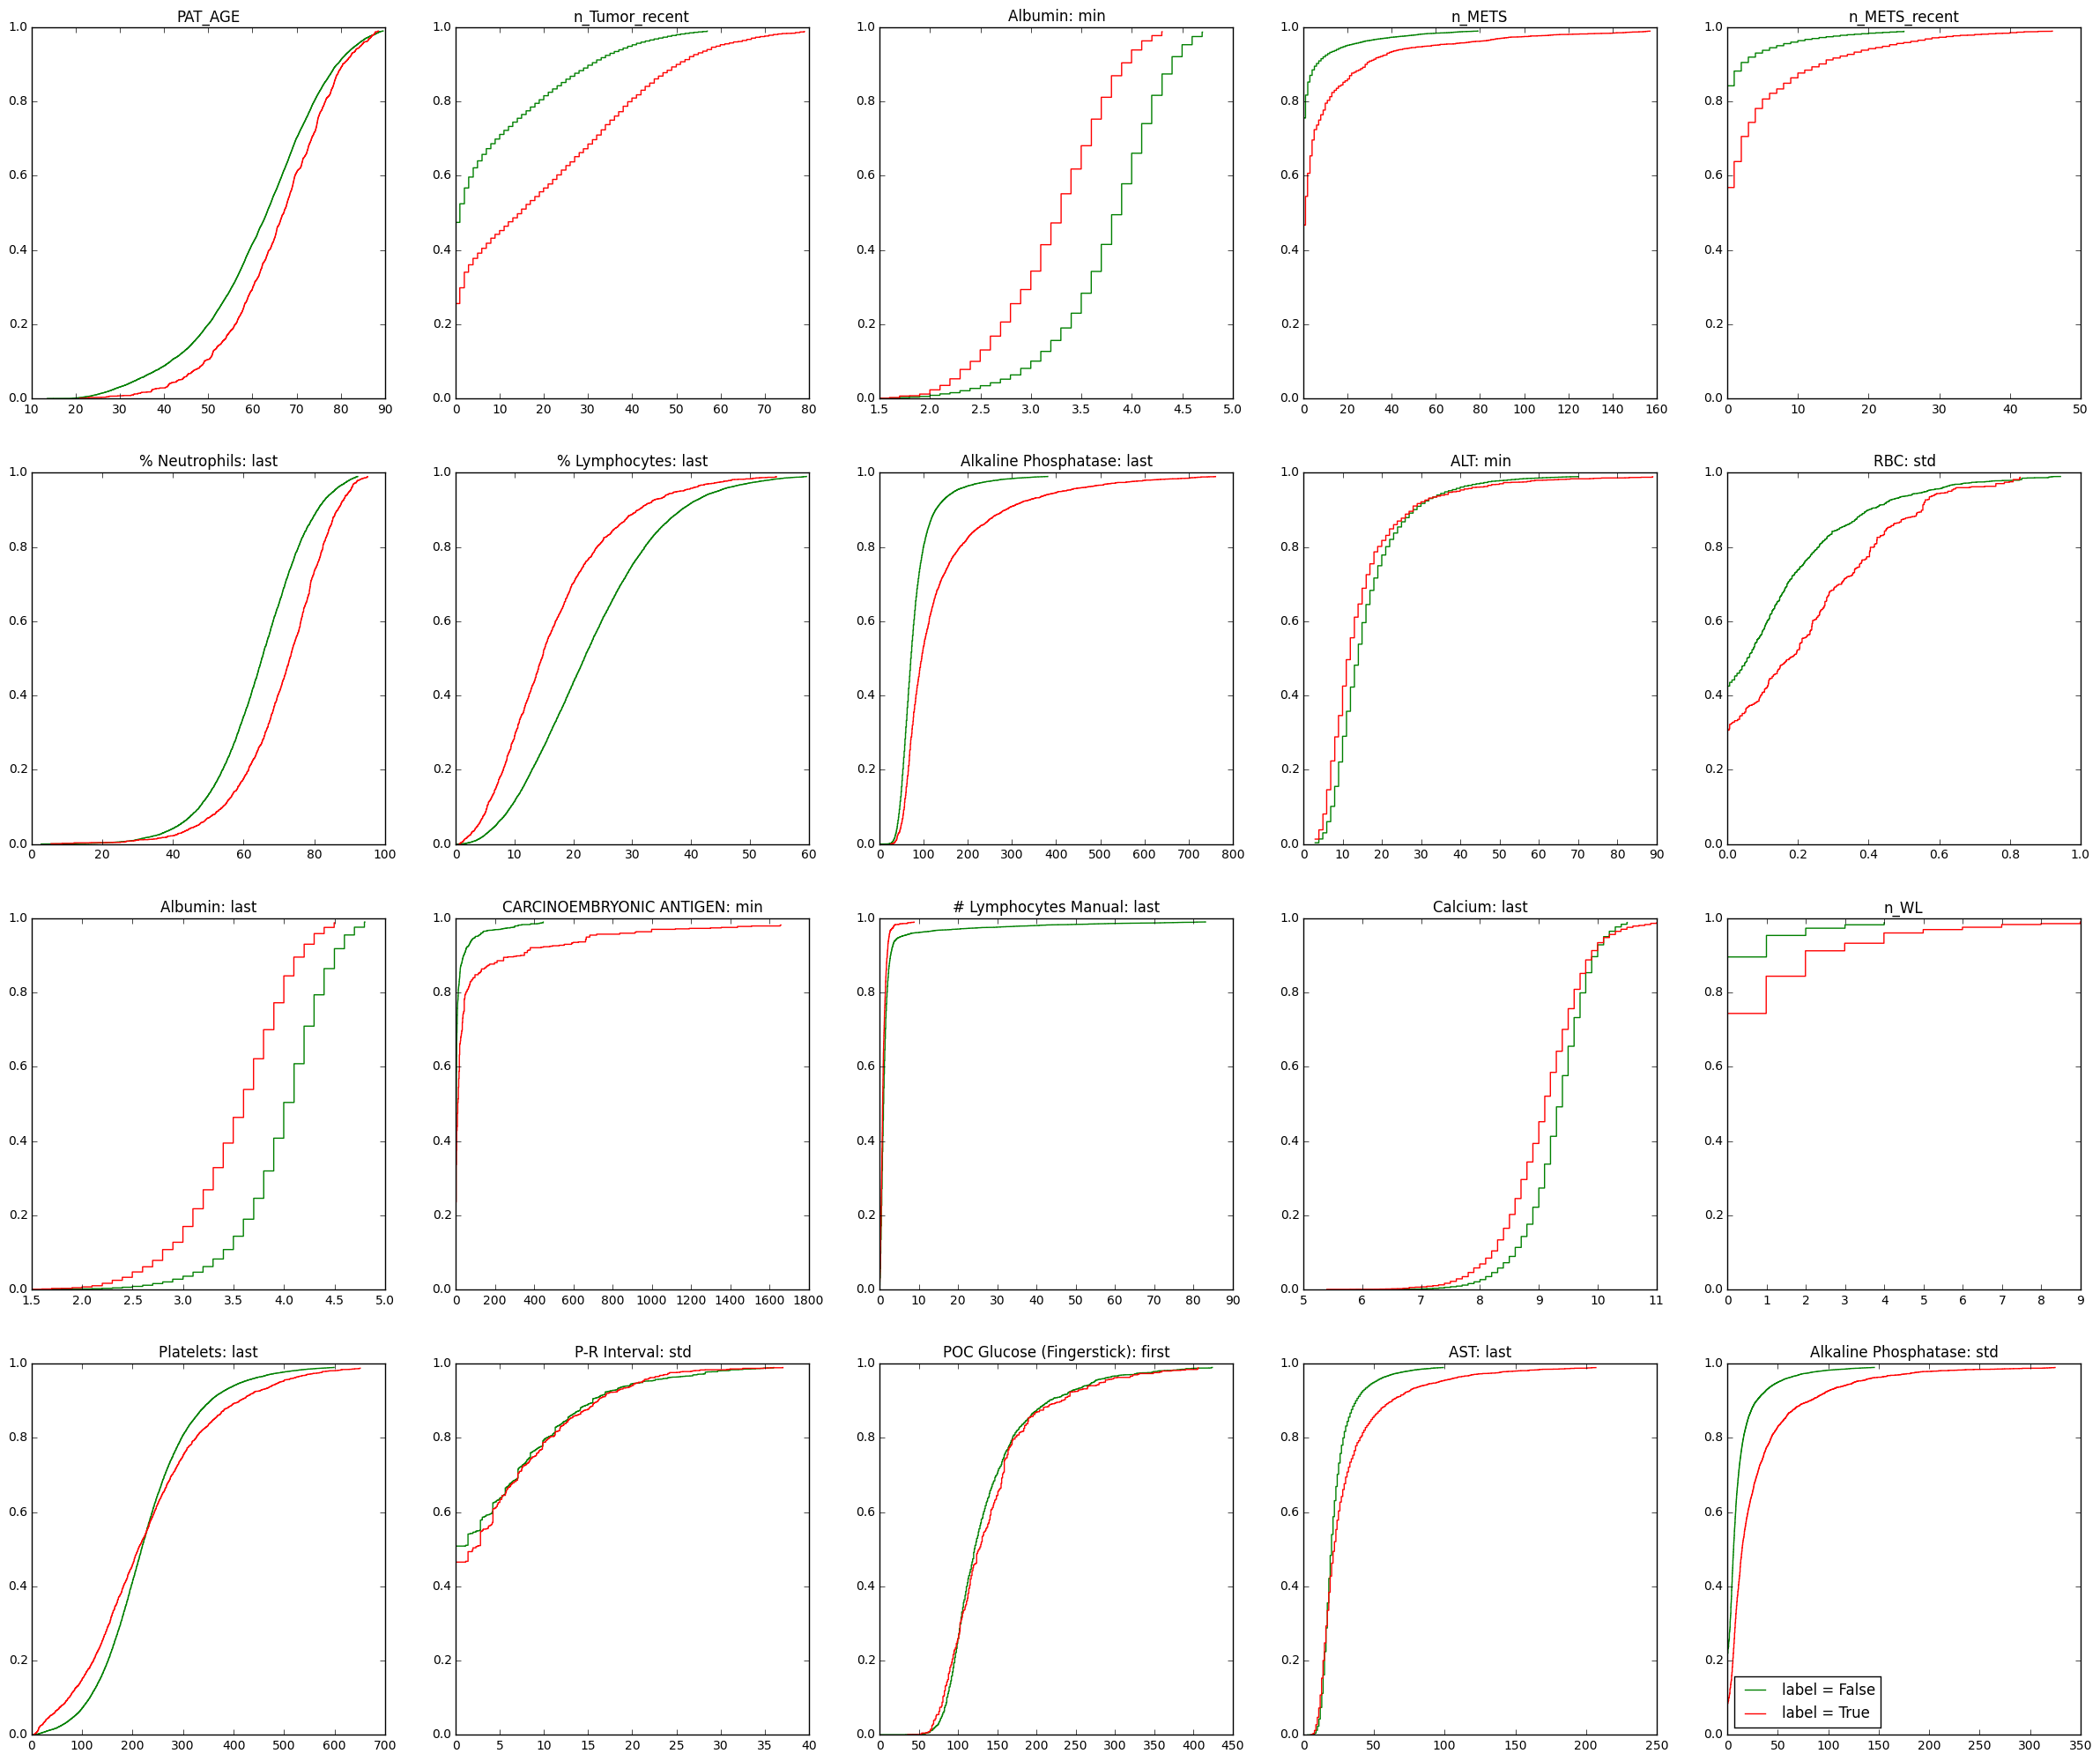

In [39]:
def cdf_diff(df, var, grp='label', col=None, rm_outlier=None, hard_lim=None, ax=None, xlim=None):
    '''Plot cummulative distributions of multiple groups for comparison.
    Arguments:
        df: DataFrame
        var: string, name of column to be plotted
        grp: string, grouping variable
        col: list, colors to use for each group
        rm_outlier: None|float, remove datapoints beyond this many sigma.
        ax: axis on which to plot. Default none will return a new figure

    Examples:
        cdf_diff(feats_labeled,var='Creatinine' ,rm_outlier=4.0)
        fig, ax = plt.subplots(1, 2)
        psLearn.cdf_diff(feats_labeled,var='Creatinine' ,ax=ax[0],rm_outlier=4.0)
        psLearn.cdf_diff(feats_labeled,var='Sodium Level',ax=ax[1])
    '''
    if col is None:
        col = ['green', 'red']
    import statsmodels.api as sm
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    grps = df[grp].unique()
    if len(df[var].unique()) == 2:
        df.groupby(grp)[var].mean().plot(ax = ax,kind='bar',color=col)
        ax.set_title(var)
    else:
        for g in grps:
            sample = df[df[grp]==g][var]
            sample = sample[np.isfinite(sample.values)]
            if rm_outlier is not None:
                sigma = sample.std()
                mu = sample.mean()
                sample = sample[sample > mu - rm_outlier * sigma ]
                sample = sample[sample < mu + rm_outlier * sigma ]
            if hard_lim is not None:
                sample = sample[sample > hard_lim[0] ]
                sample = sample[sample < hard_lim[1] ]
            
            ecdf = sm.distributions.ECDF(sample)
            sample = sample[ecdf(sample) < 0.99]
            
            x = np.linspace(min(sample), max(sample), 1000)
            y = ecdf(x)
            #x = np.append(x, [max(sample)])
            #y = np.append(y, [0])
            ax.step(x, y,label='%s = %s' % (grp,str(g)),c=col[int(g)])
            ax.set_title(var)
            ax.set_ylim([0,1])
            if xlim:
                ax.set_xlim(xlim)

# Top features from model
vars_to_plot = ['PAT_AGE', 'n_Tumor_recent', 'Albumin: min', 'n_METS',
       'n_METS_recent', '% Neutrophils: last', '% Lymphocytes: last',
       'Alkaline Phosphatase: last', 'ALT: min', 'RBC: std',
       'Albumin: last', 'CARCINOEMBRYONIC ANTIGEN: min',
       '# Lymphocytes Manual: last', 'Calcium: last', 'n_WL',
       'Platelets: last', 'P-R Interval: std',
       'POC Glucose (Fingerstick): first', 'AST: last',
       'Alkaline Phosphatase: std']
                
fig, axx = plt.subplots(4,5,figsize=(30,25))
for i,v in enumerate(vars_to_plot):
    ax = axx[i/5, i%5]
    cdf_diff(enc_data, v, ax=ax)
ax.legend(loc=0)
plt.show()

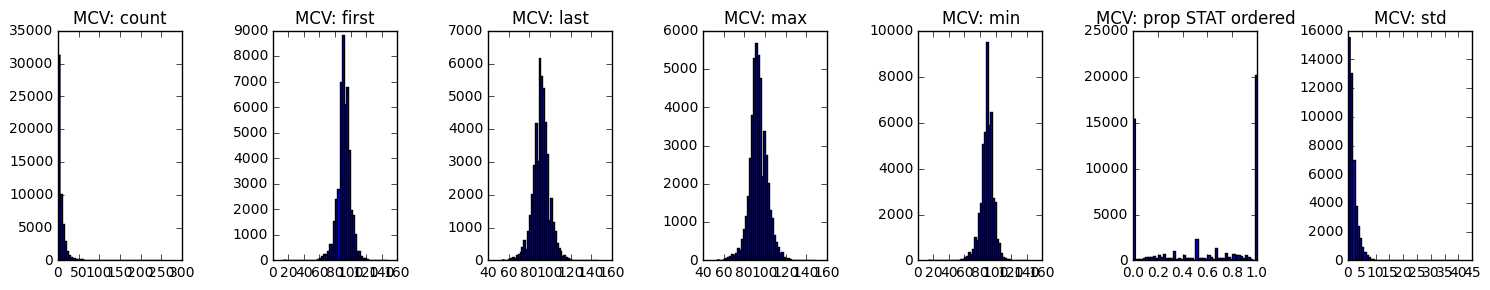

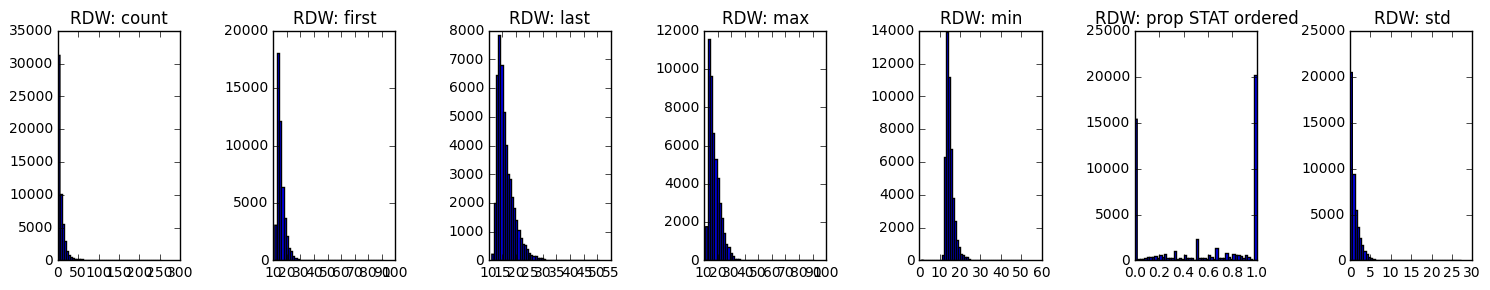

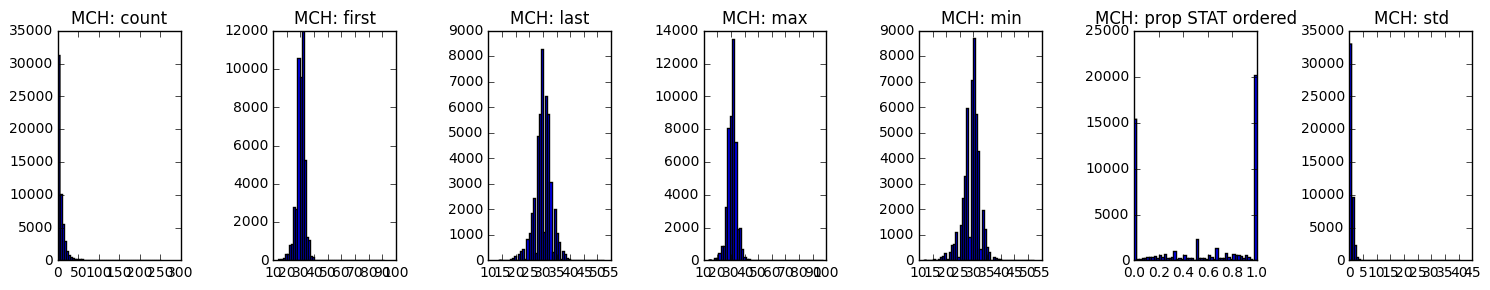

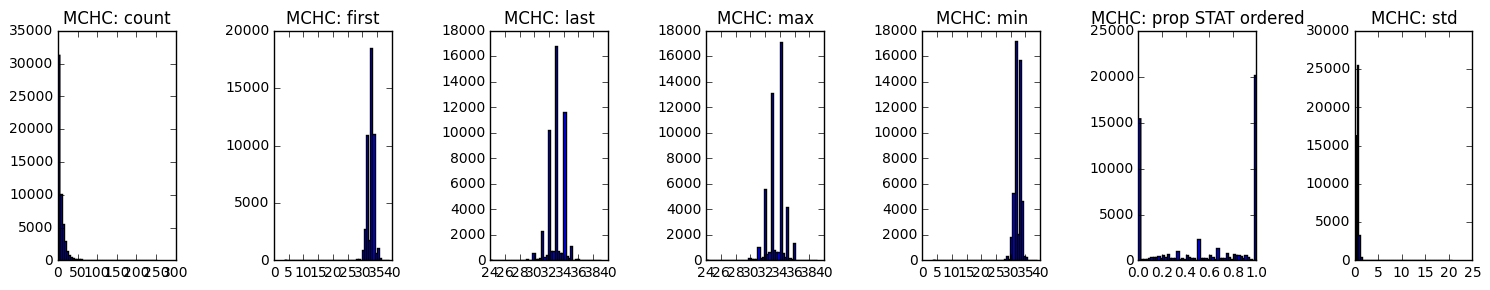

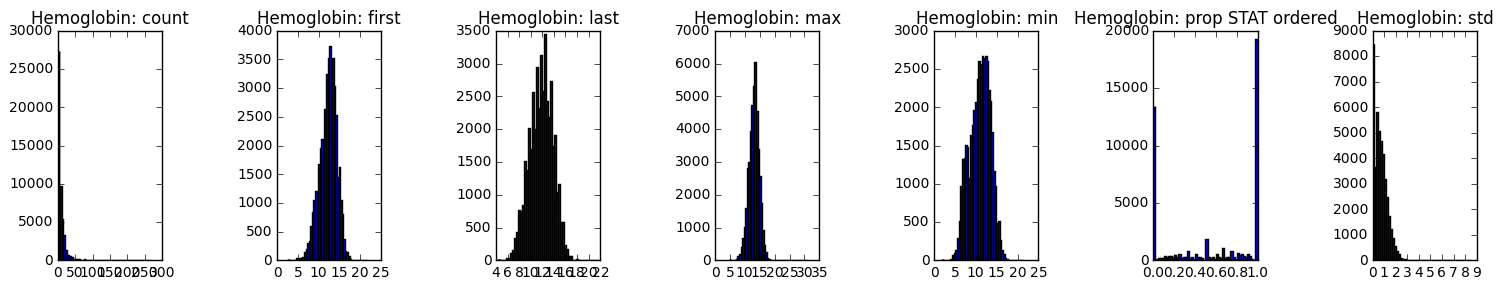

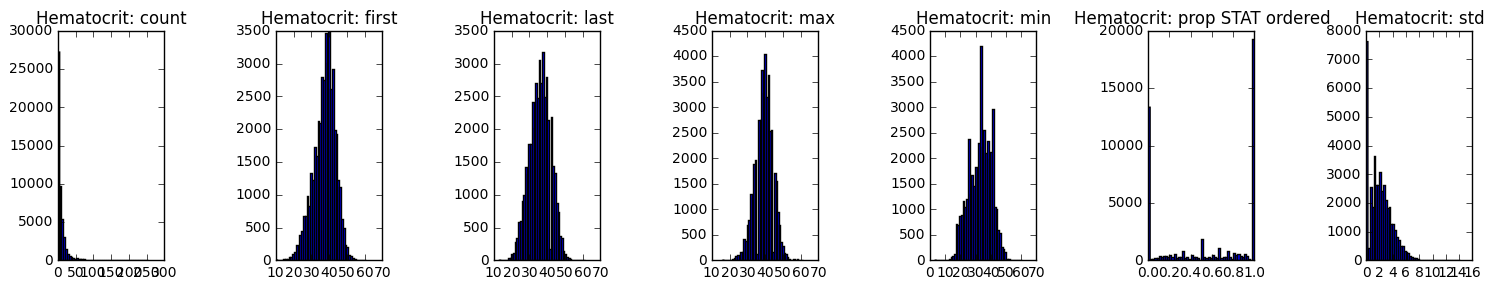

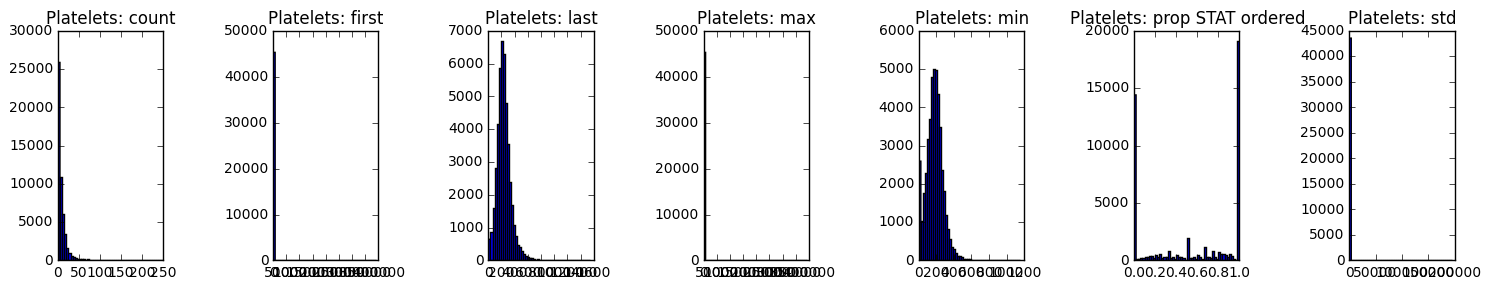

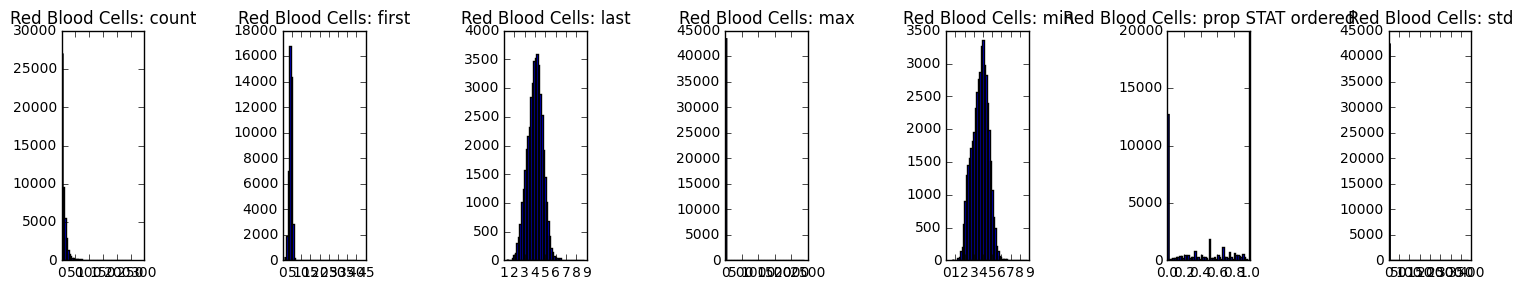

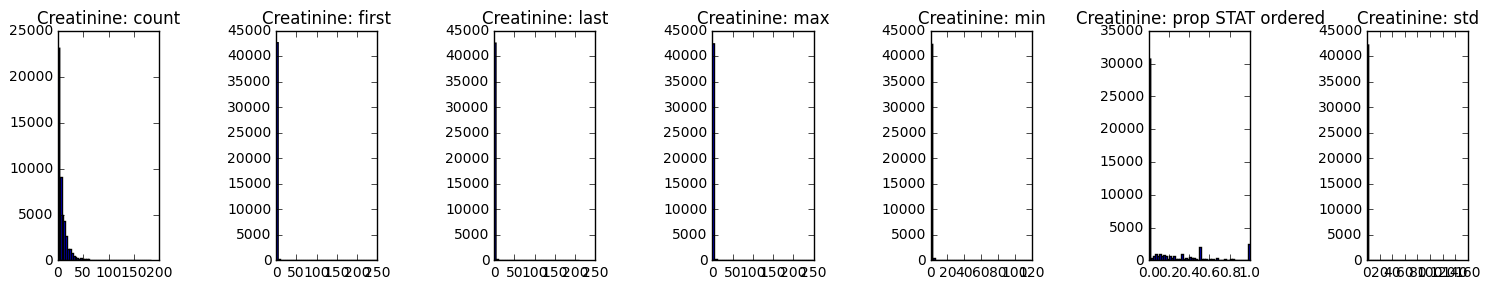

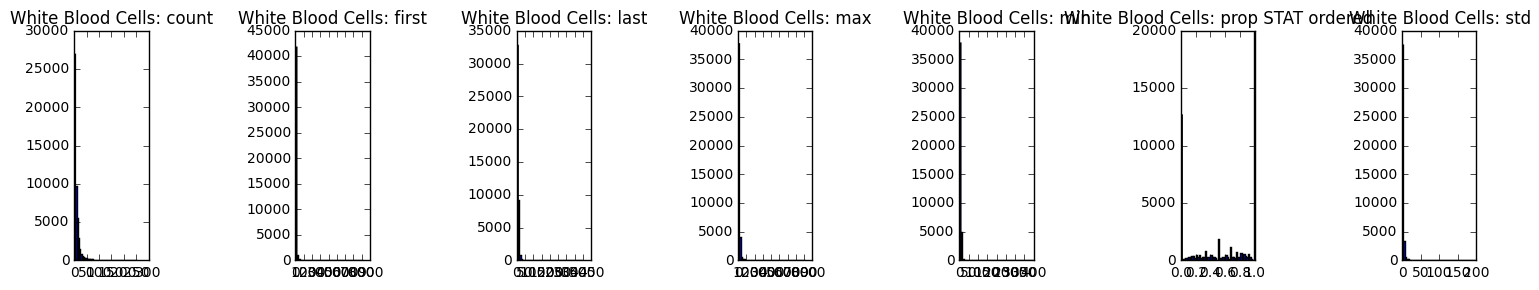

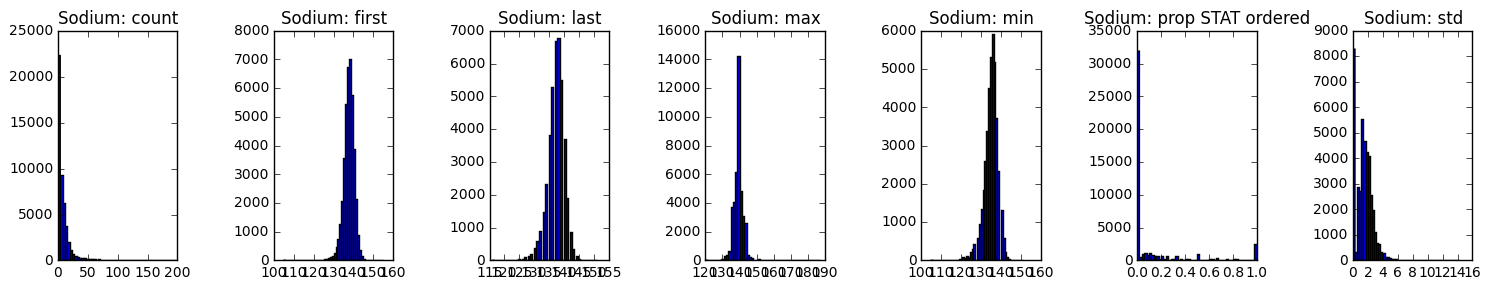

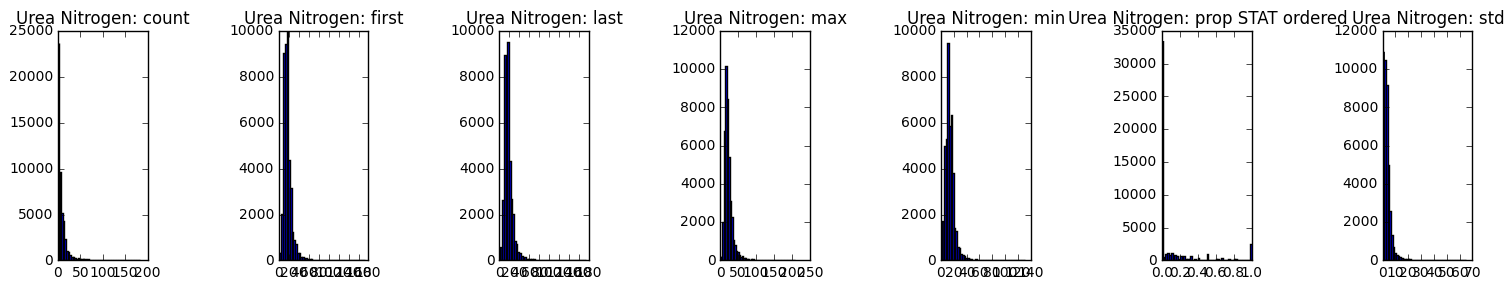

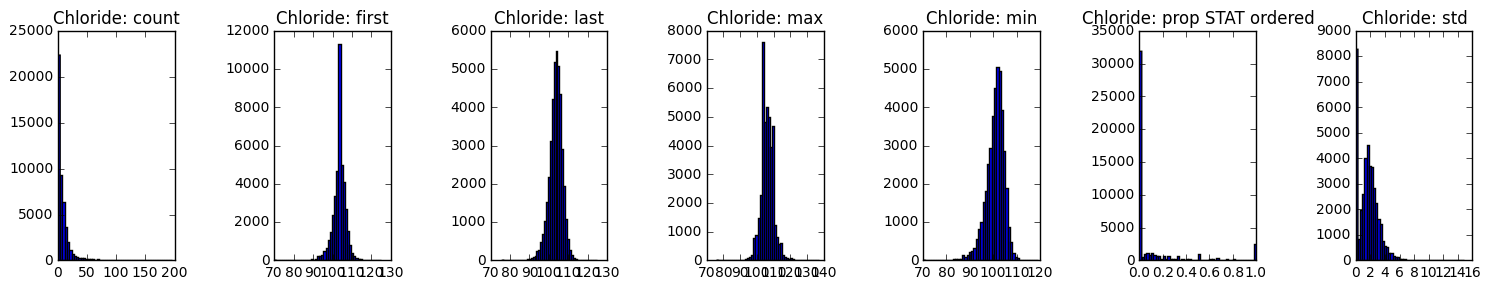

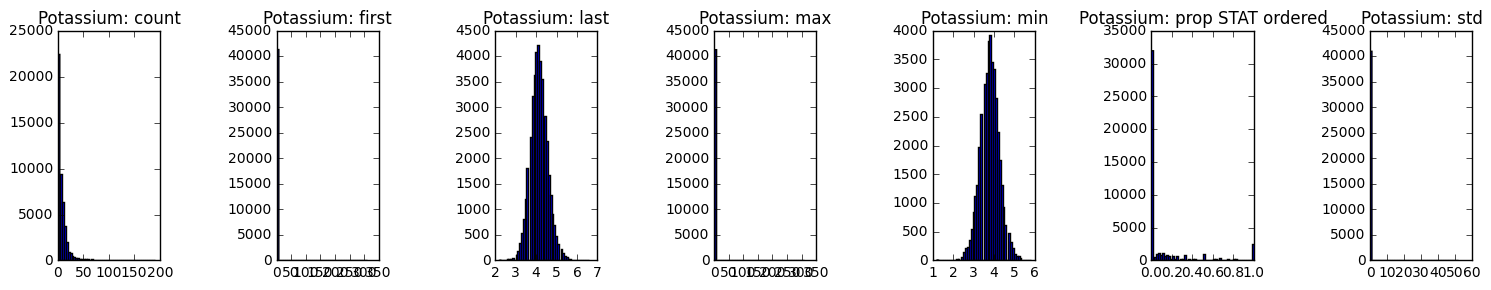

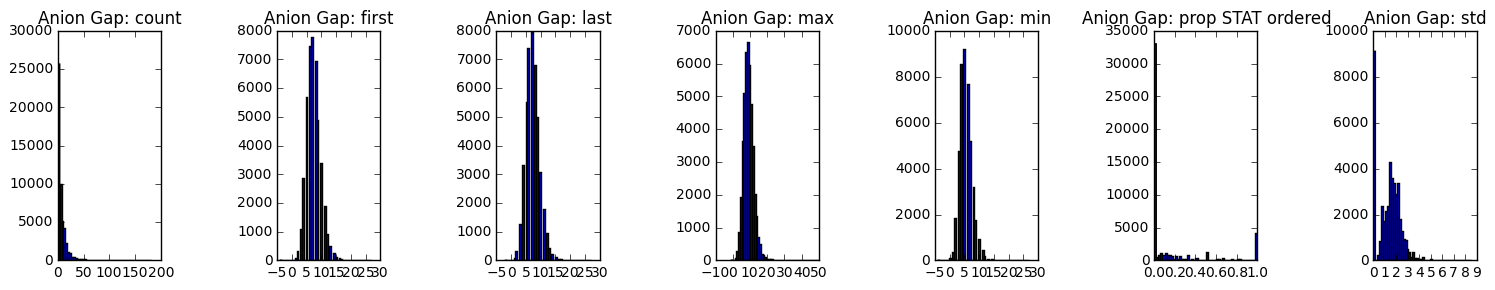

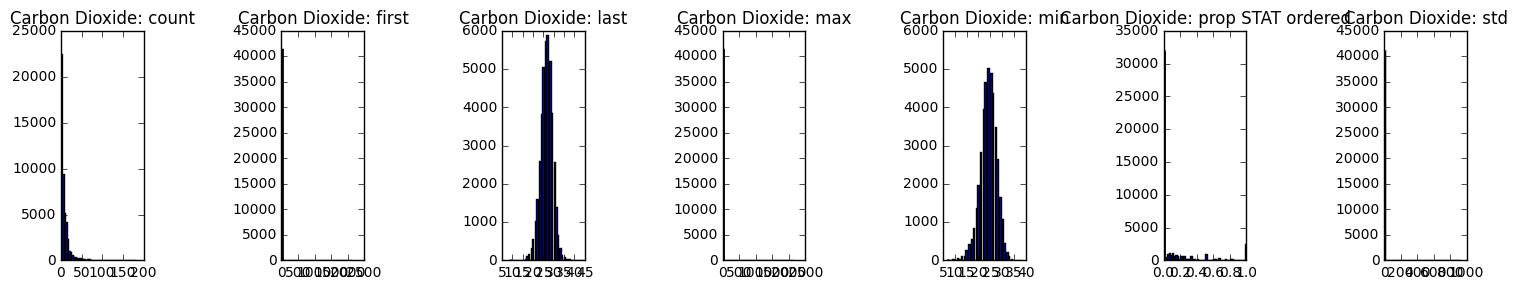

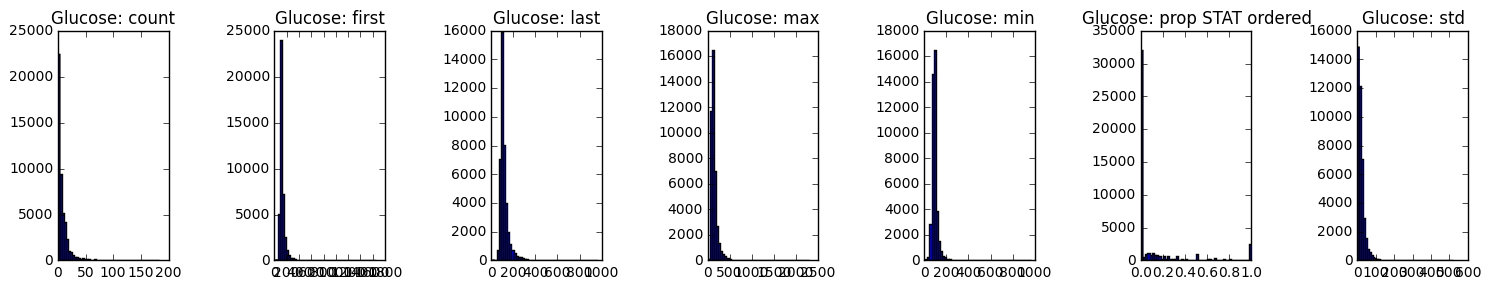

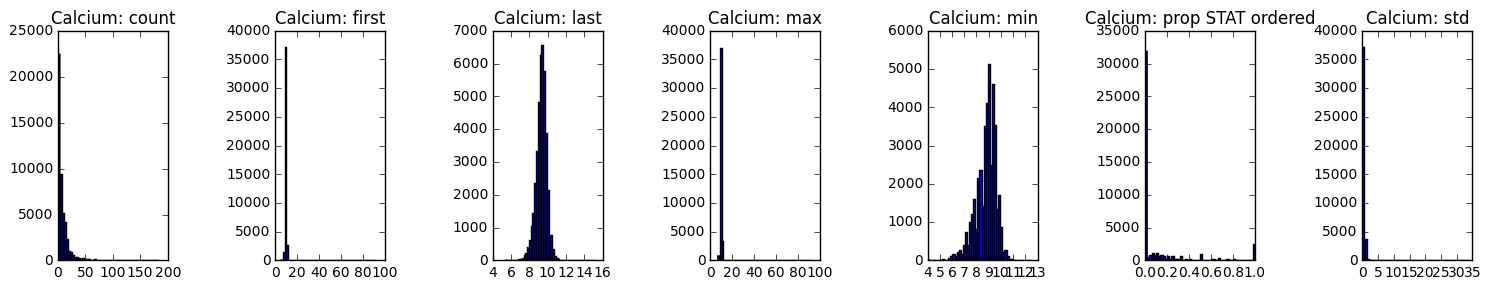

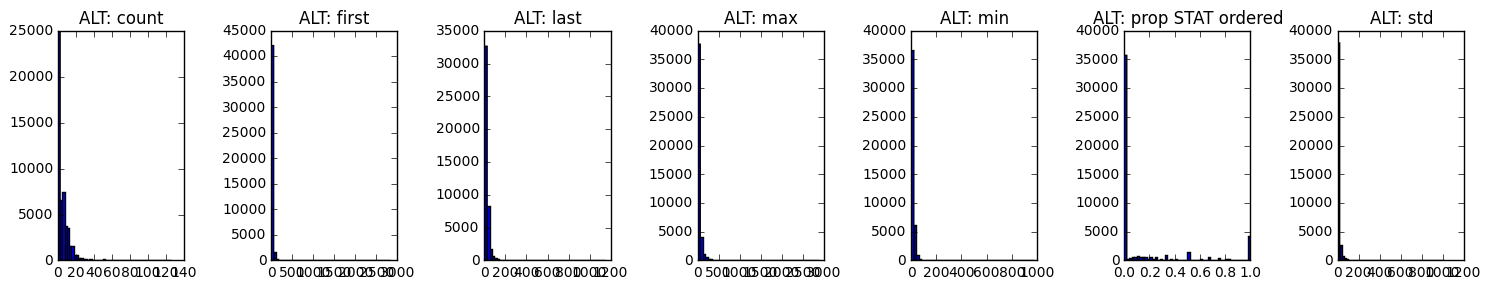

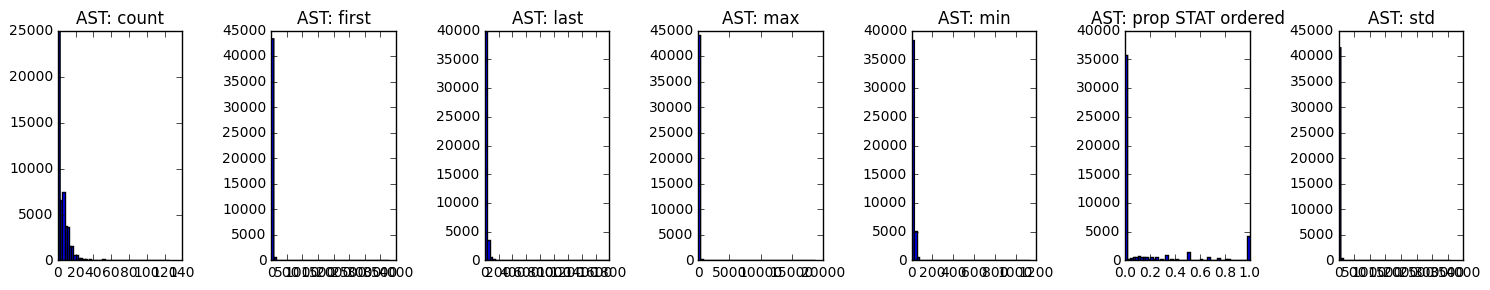

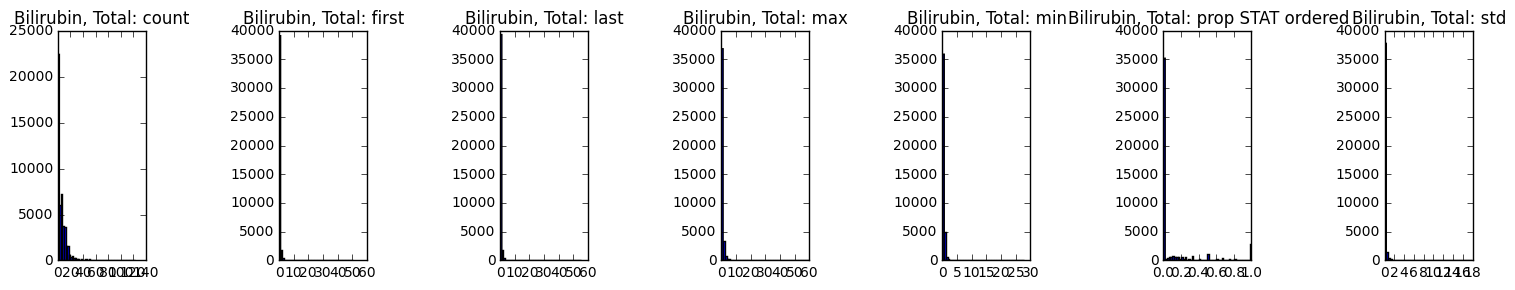

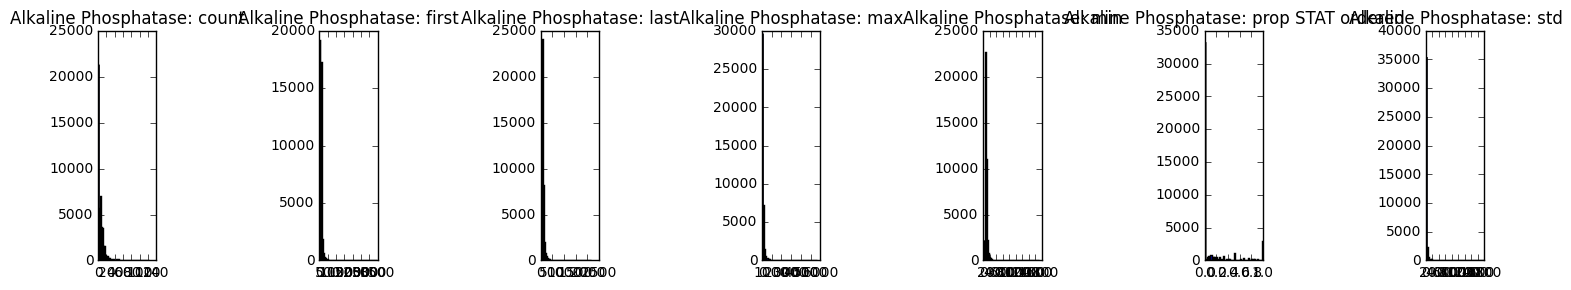

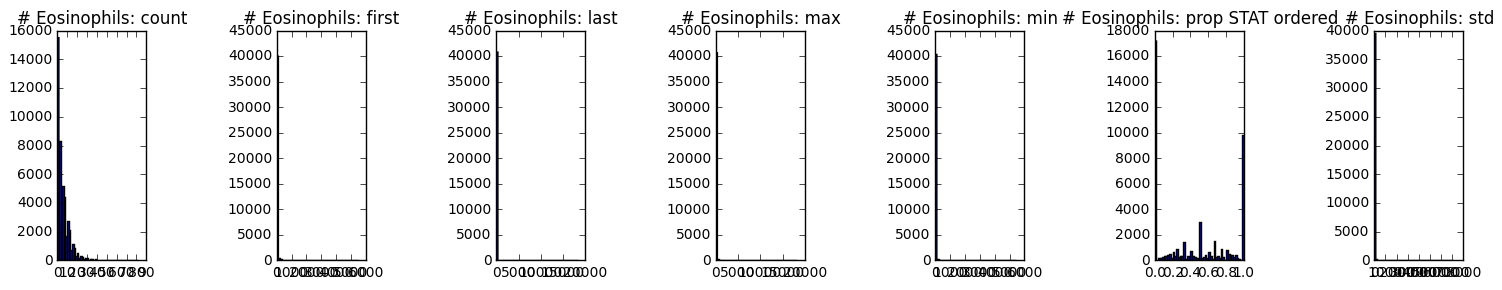

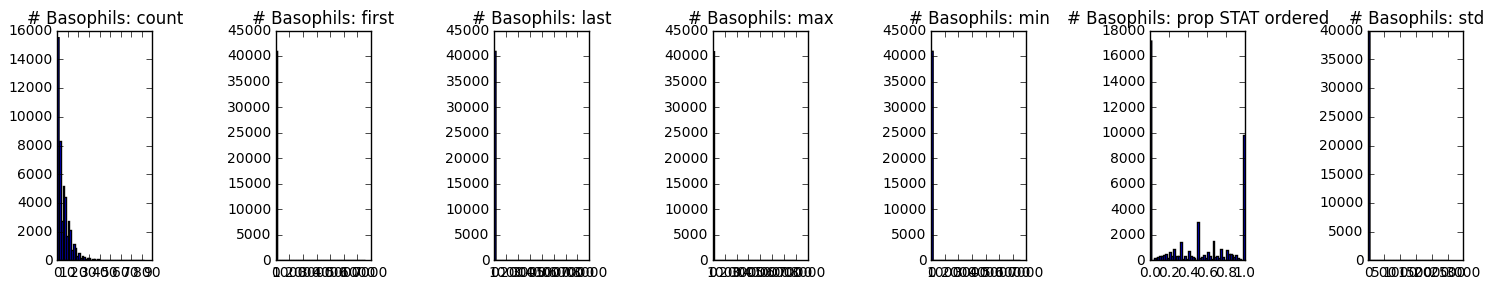

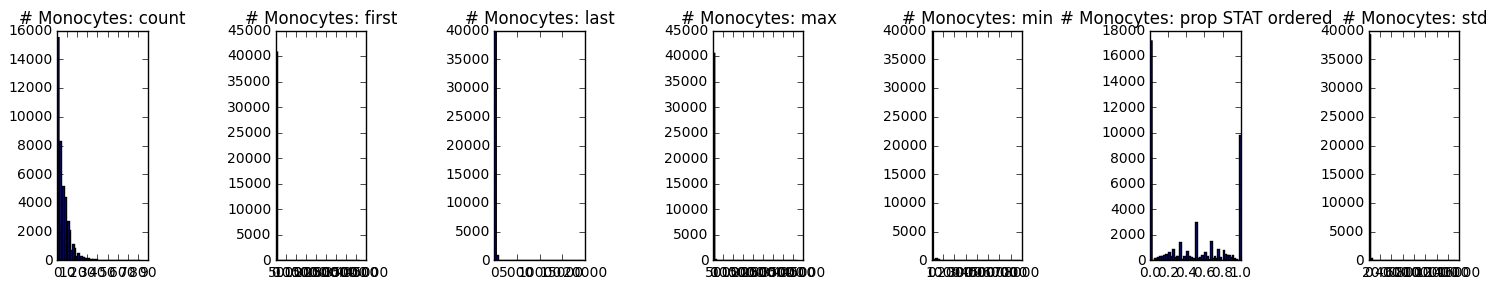

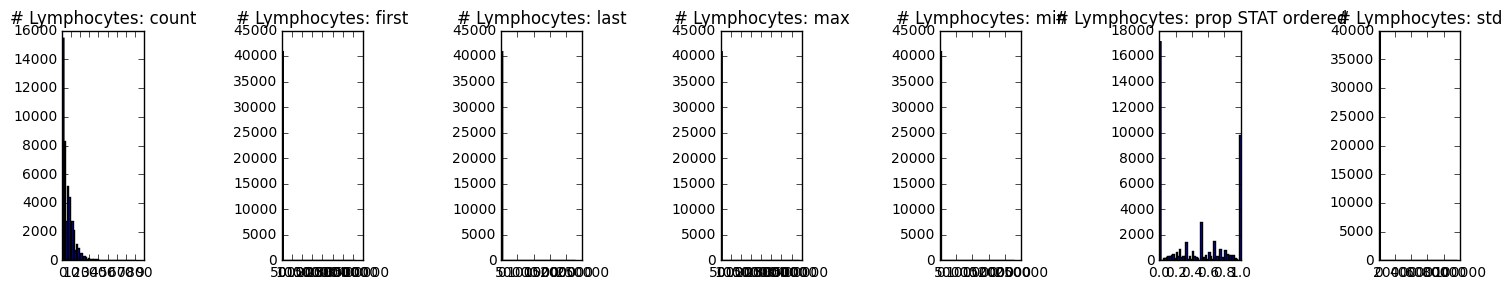

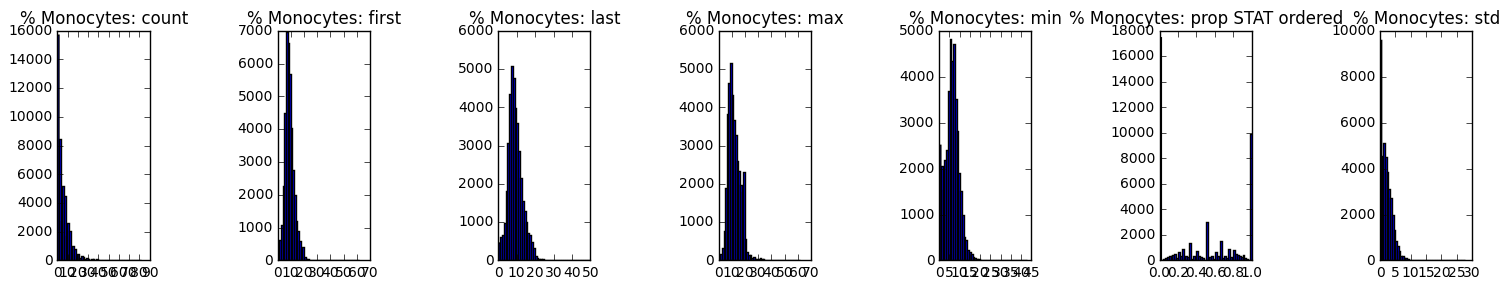

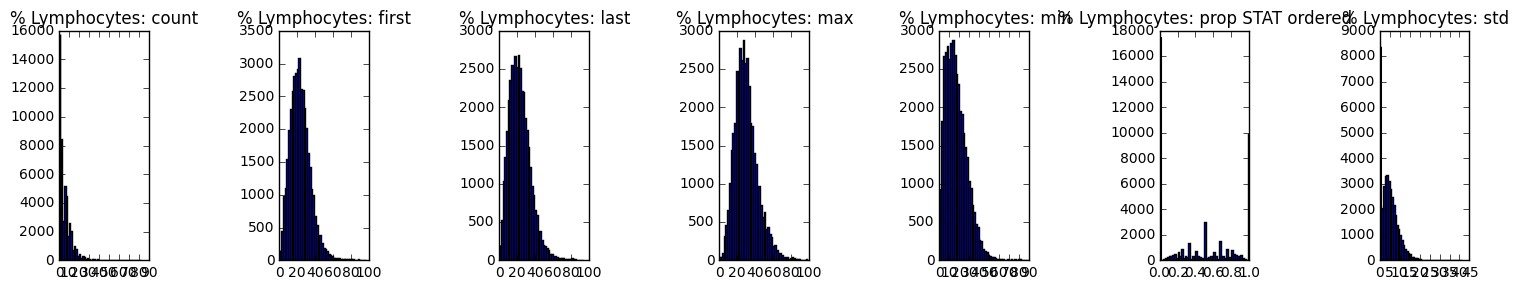

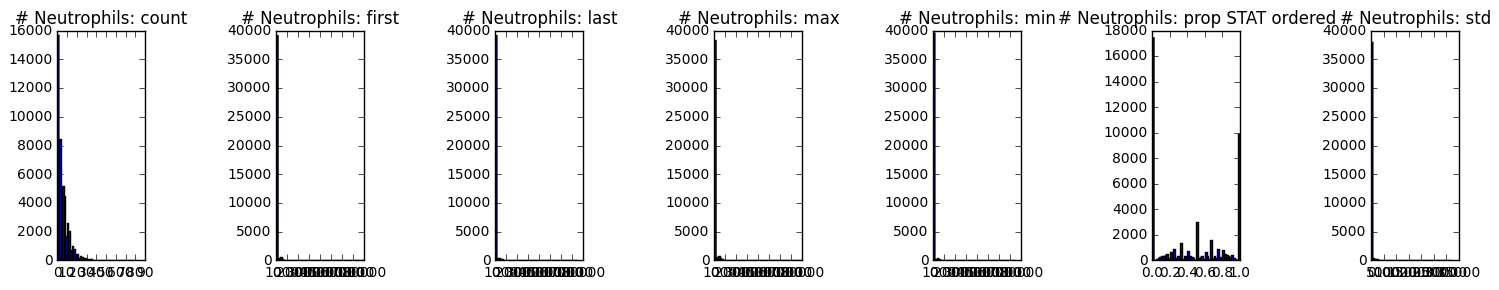

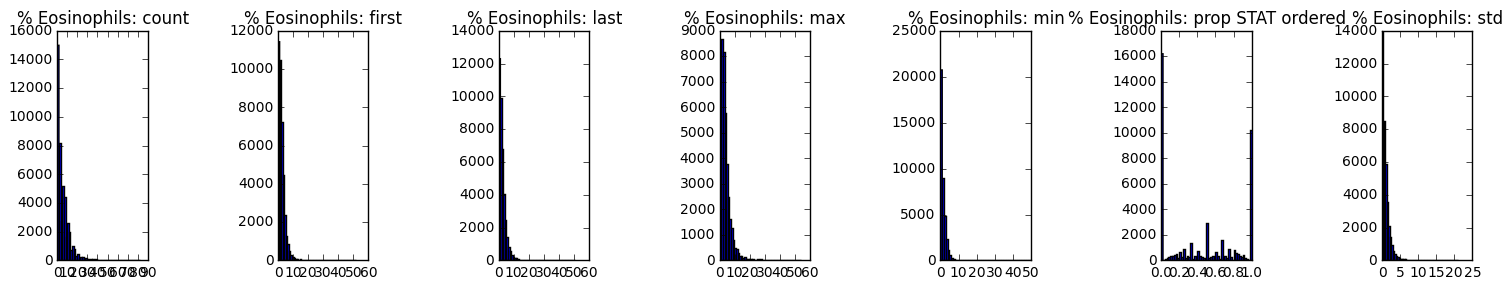

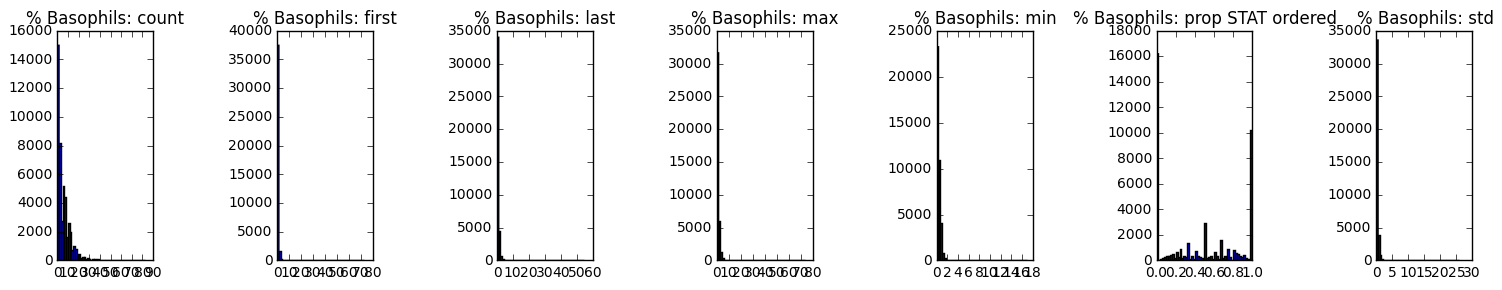

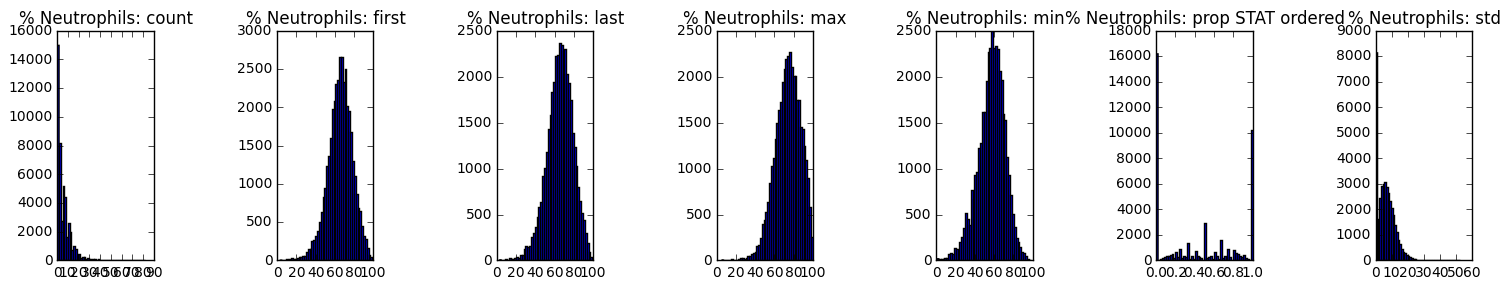

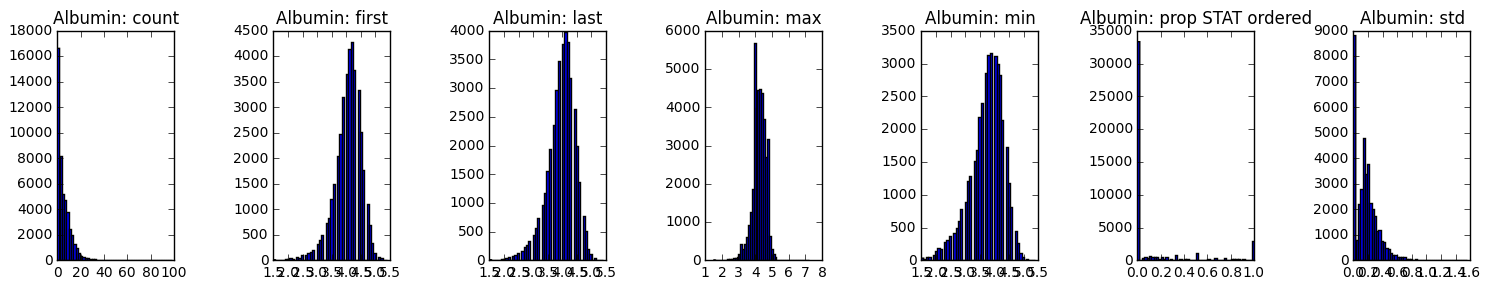

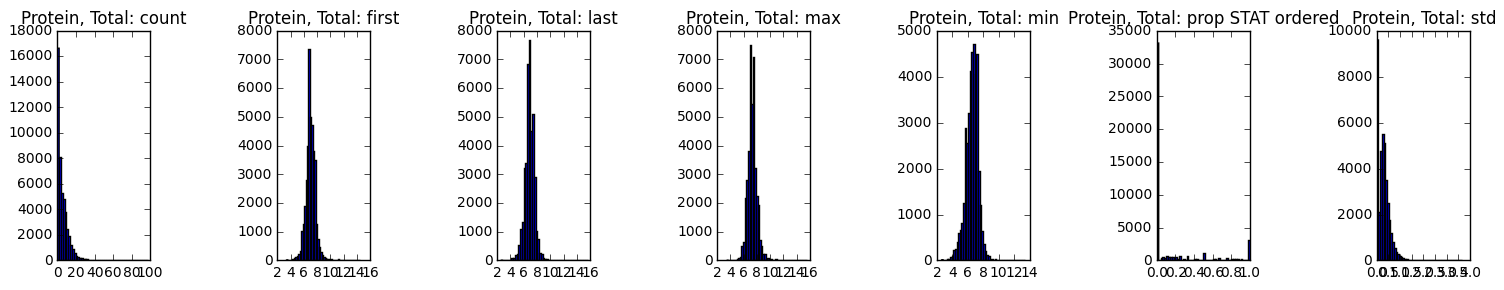

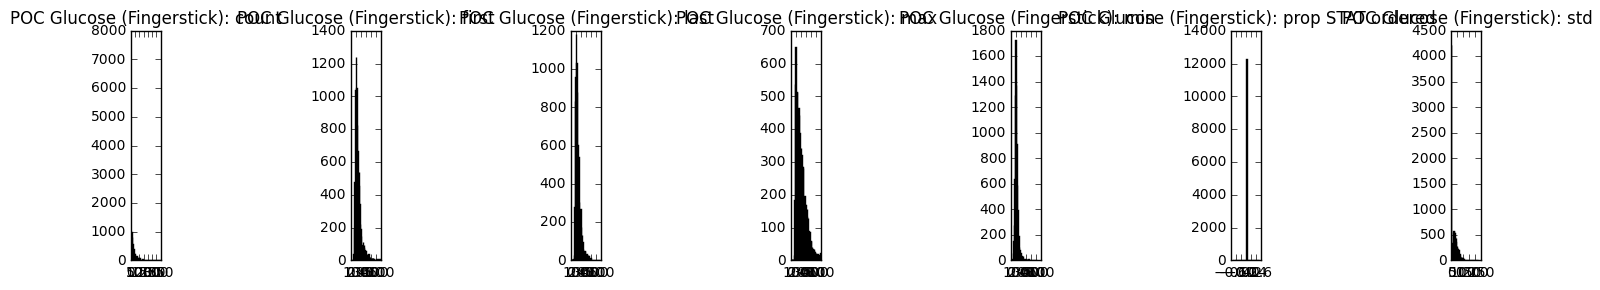

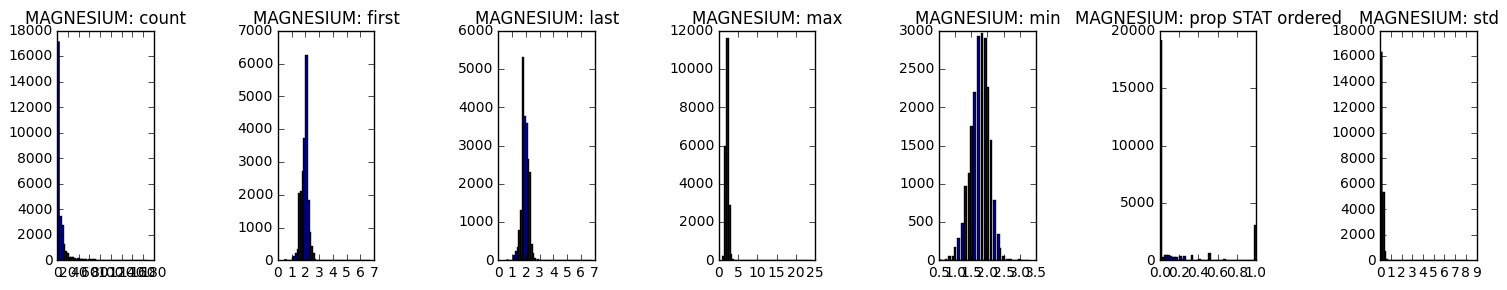

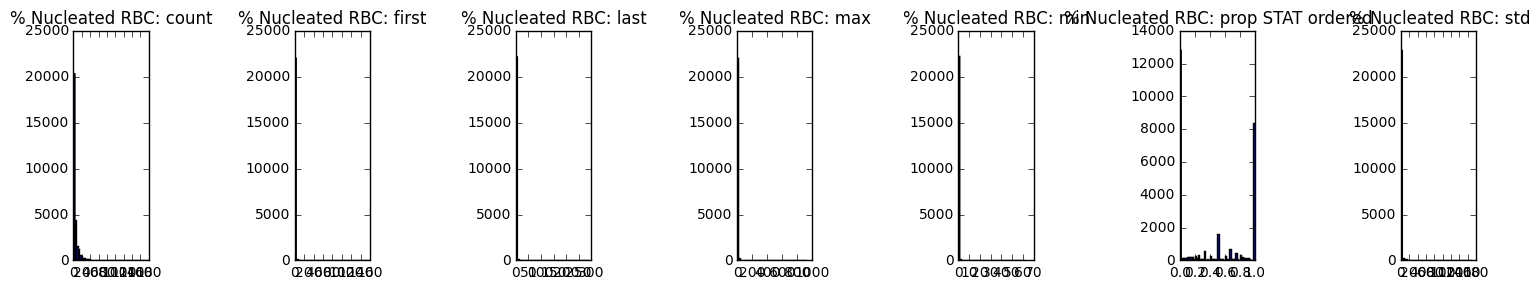

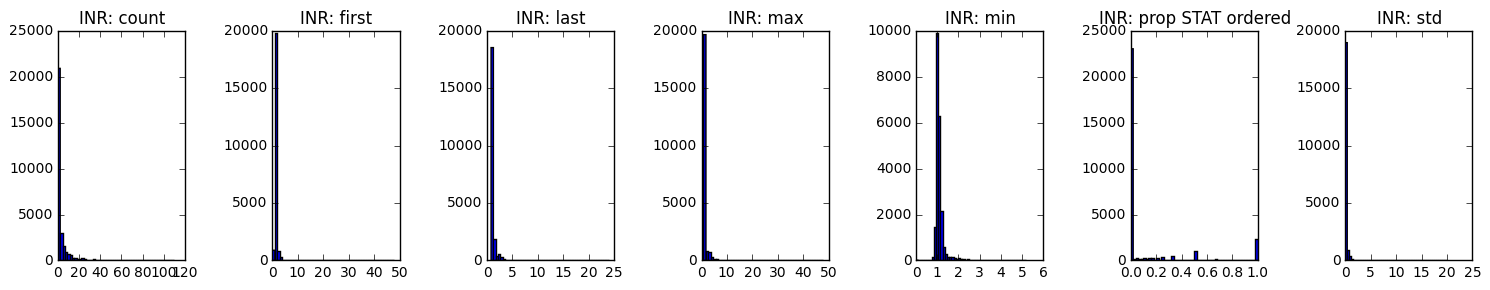

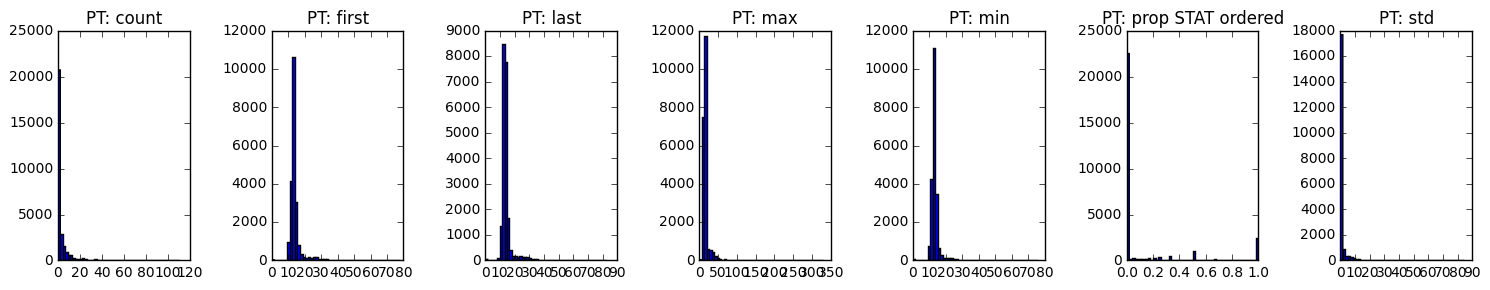

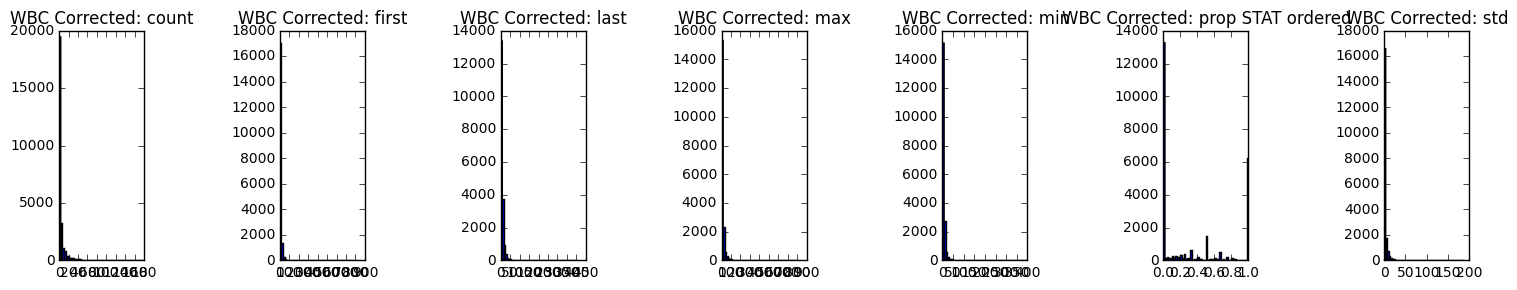

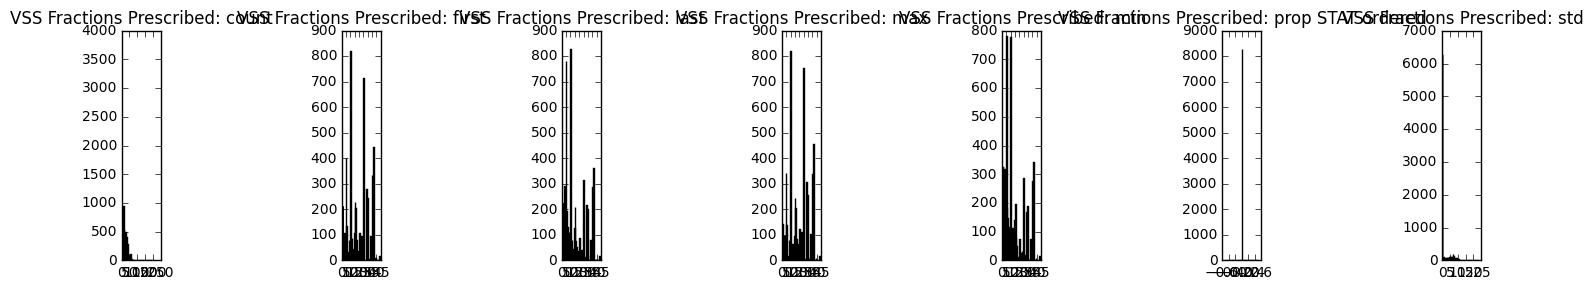

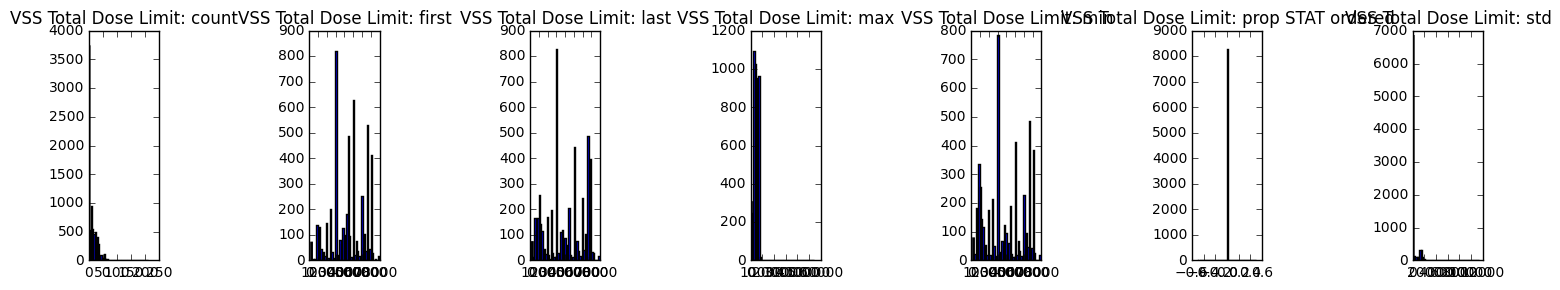

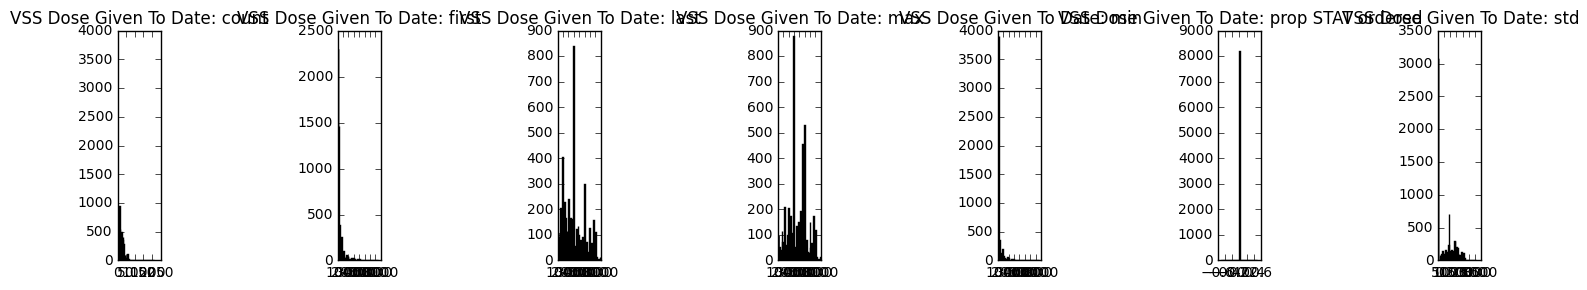

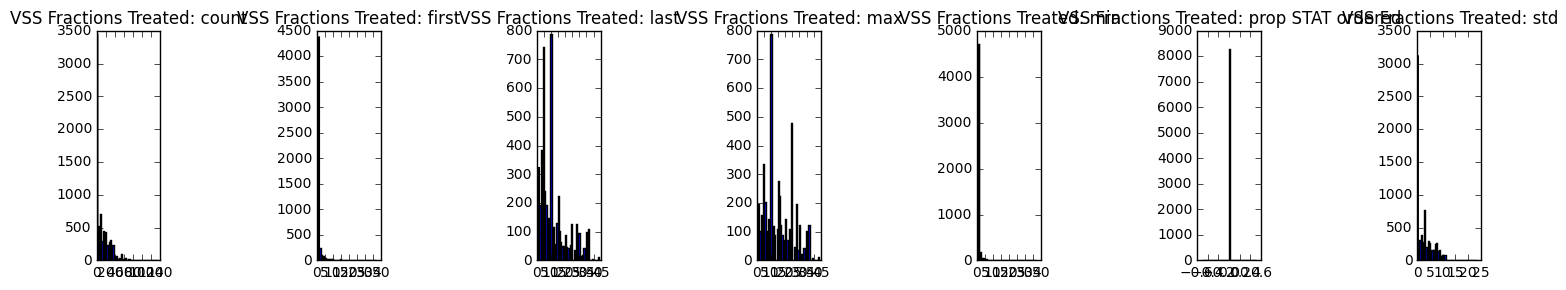

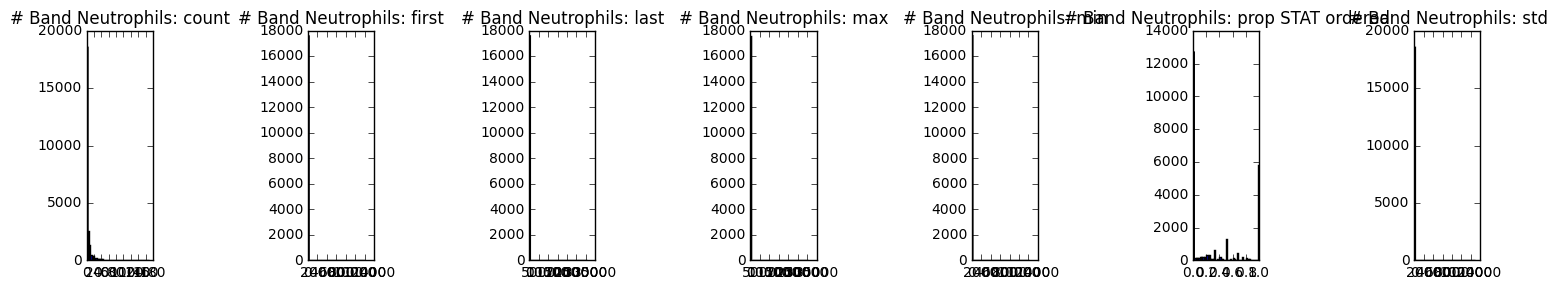

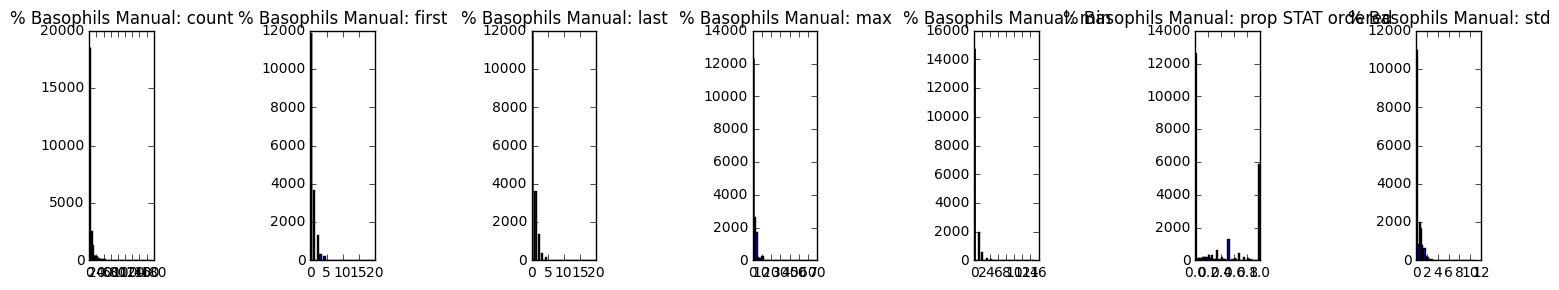

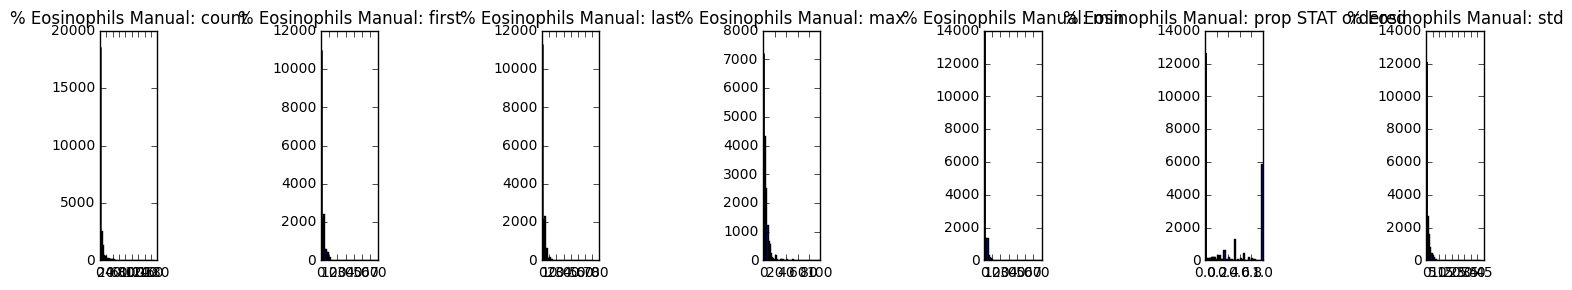

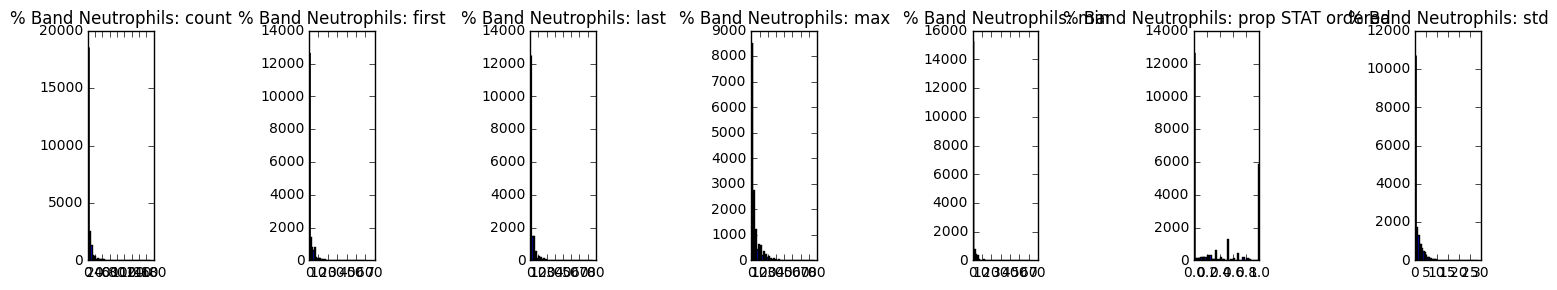

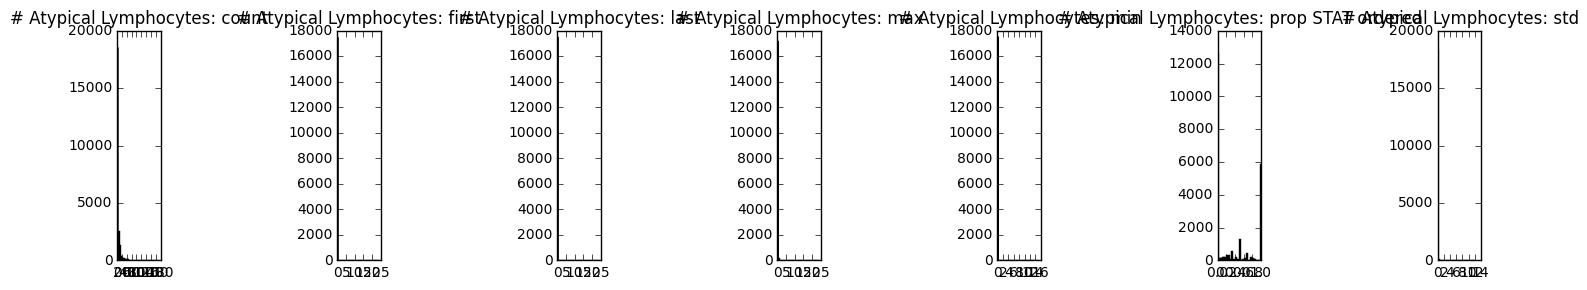

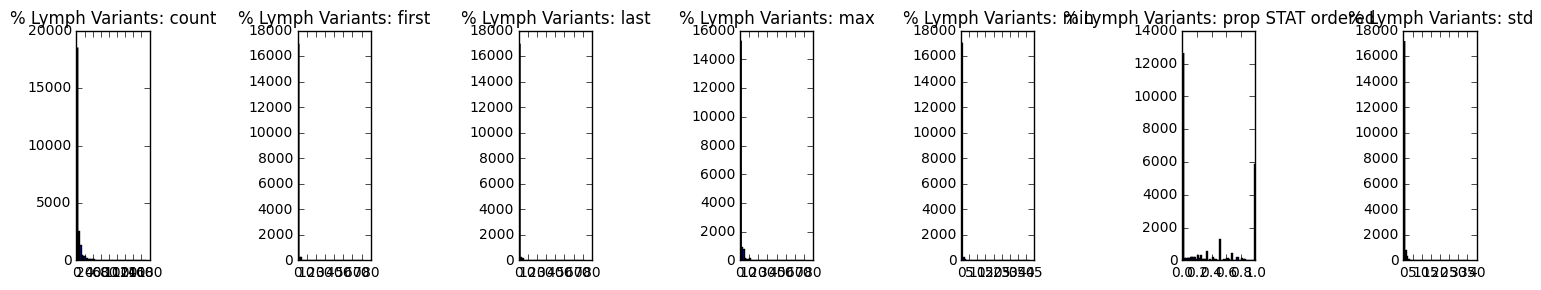

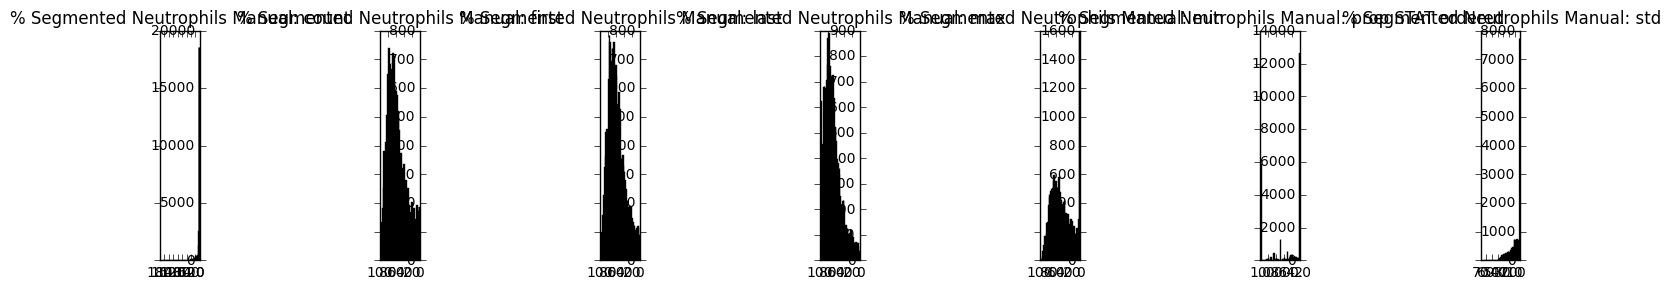

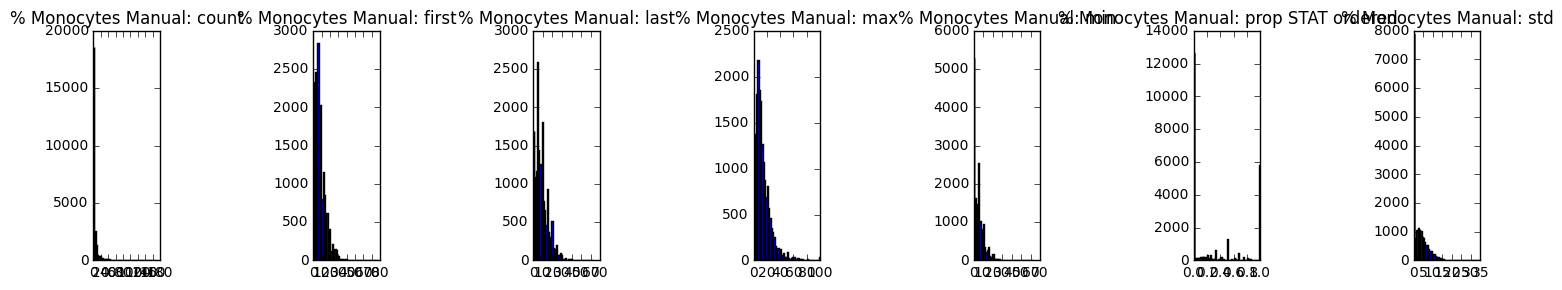

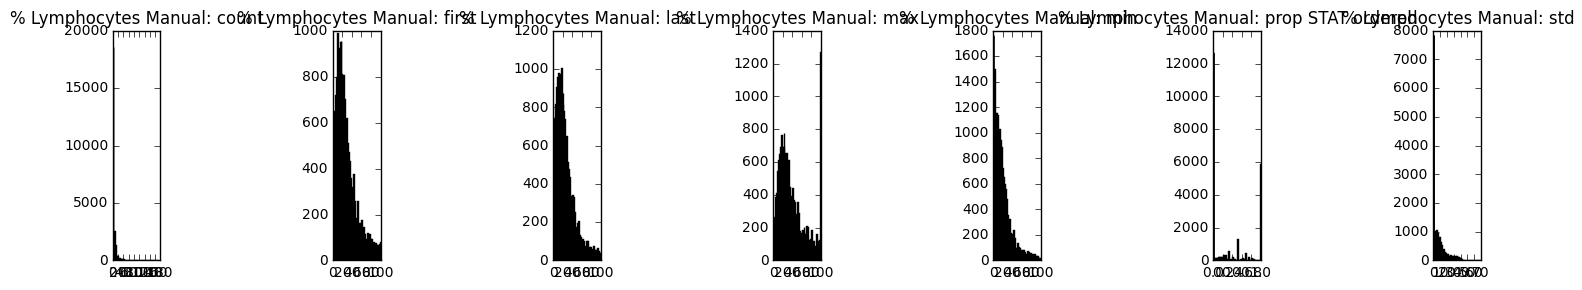

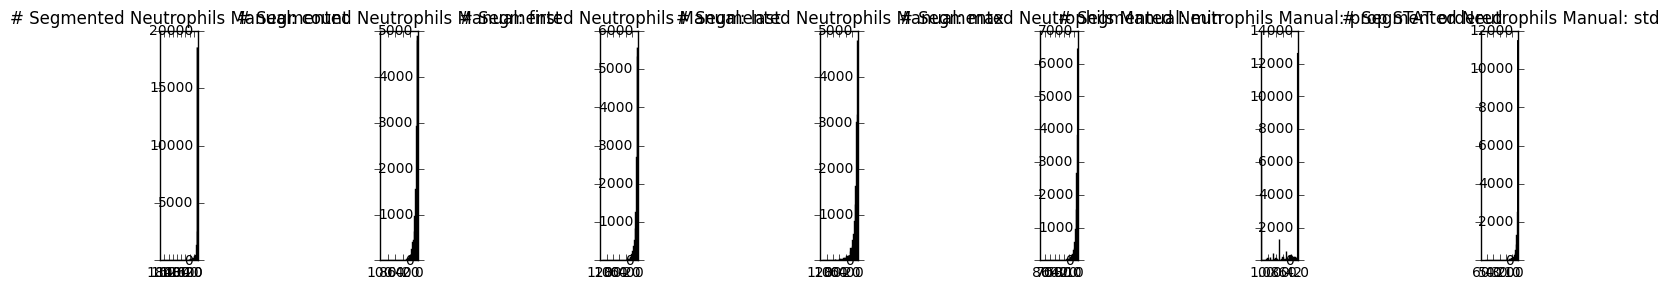

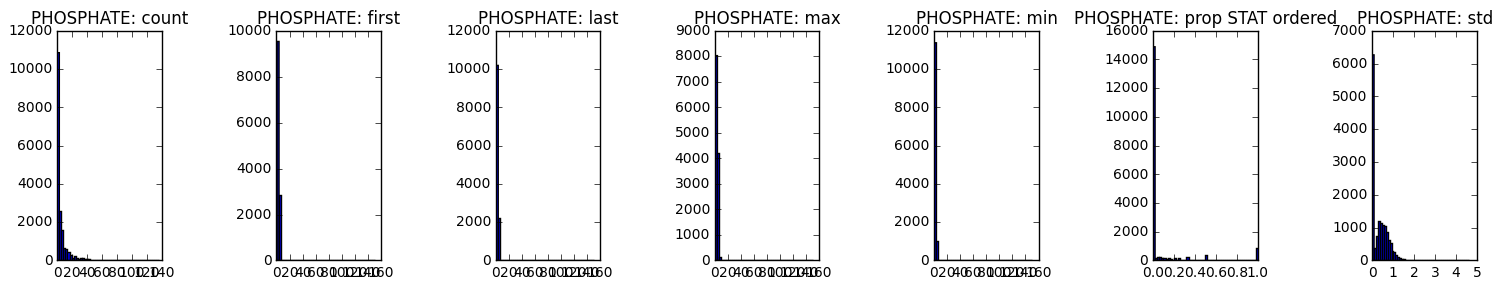

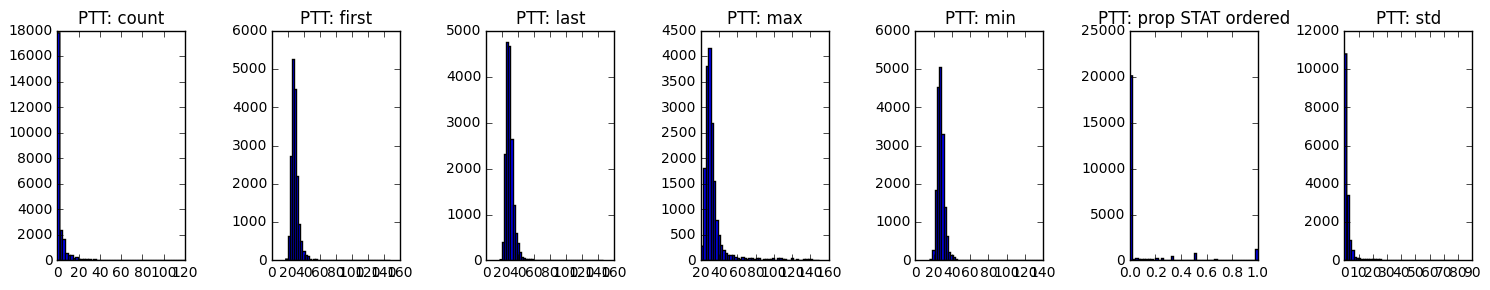

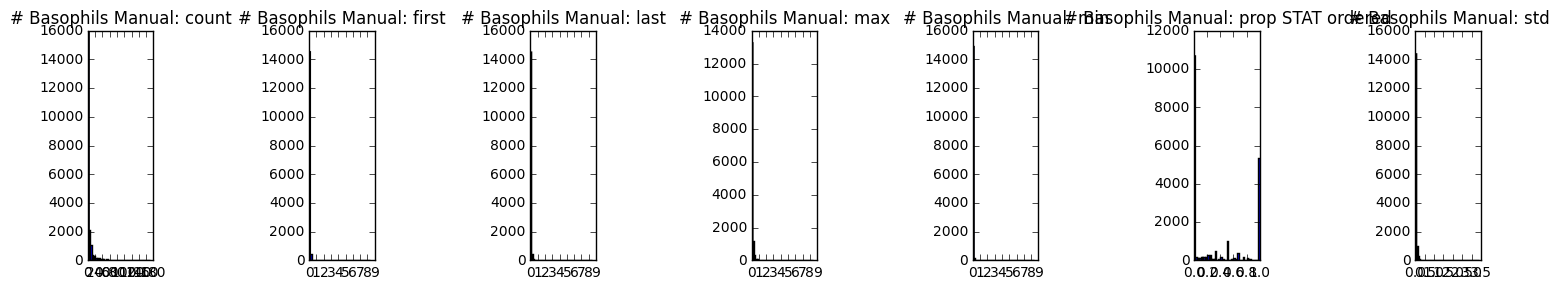

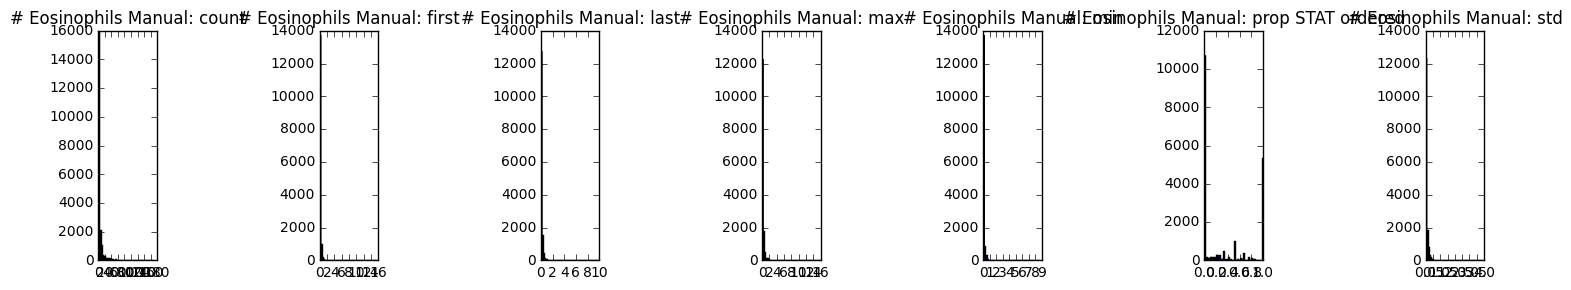

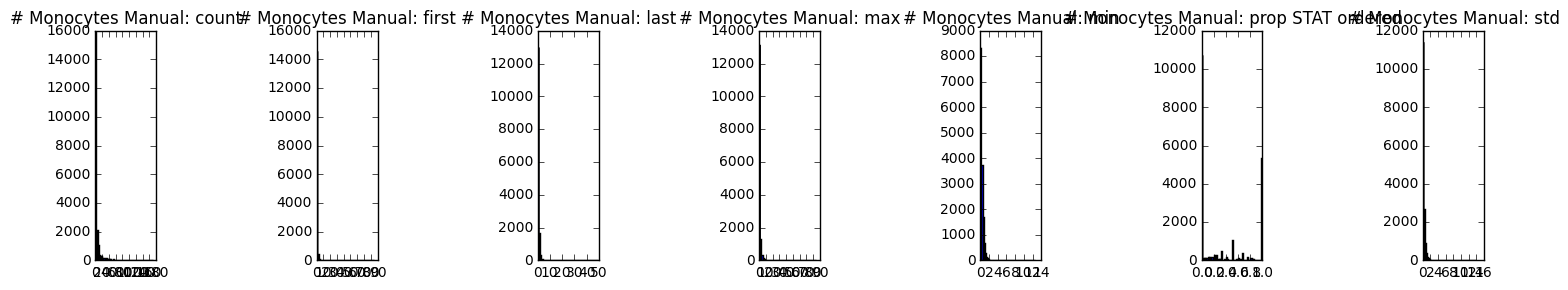

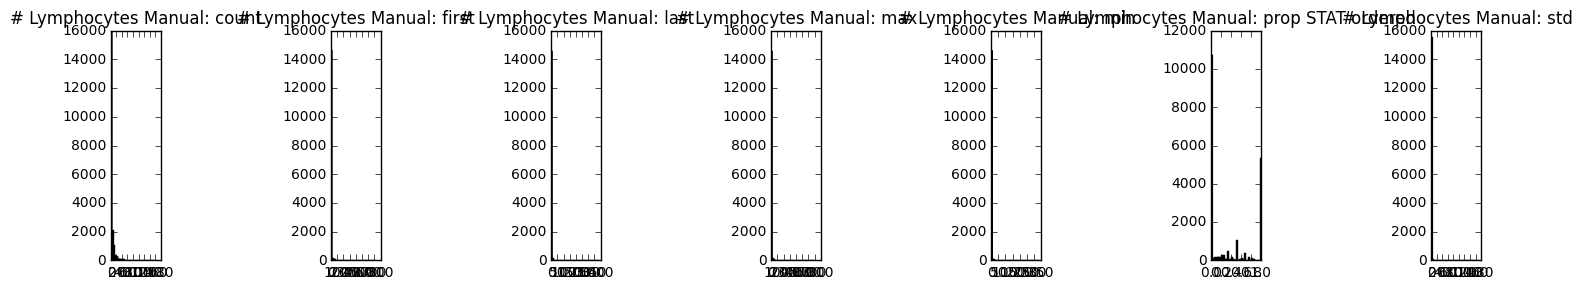

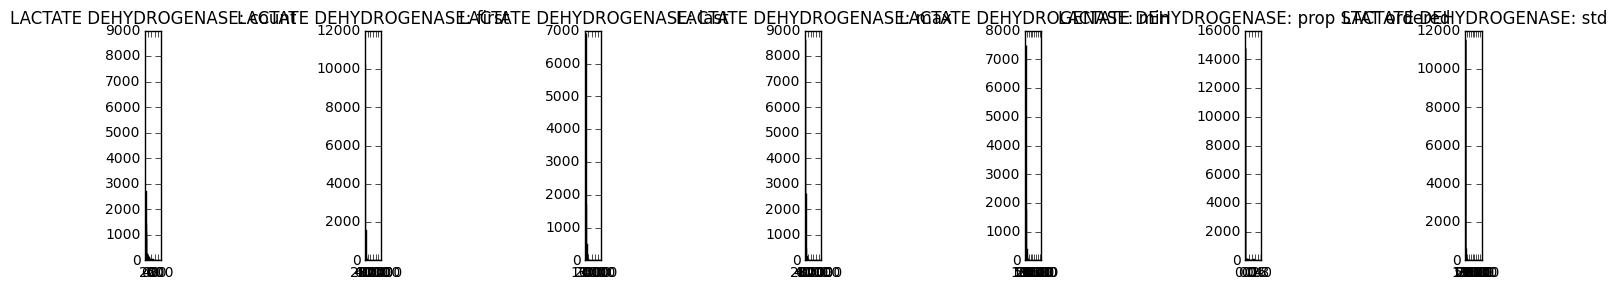

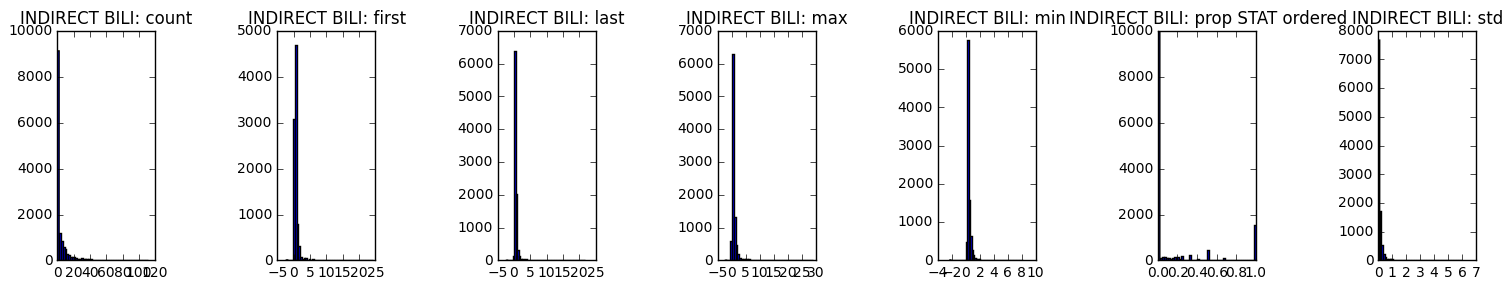

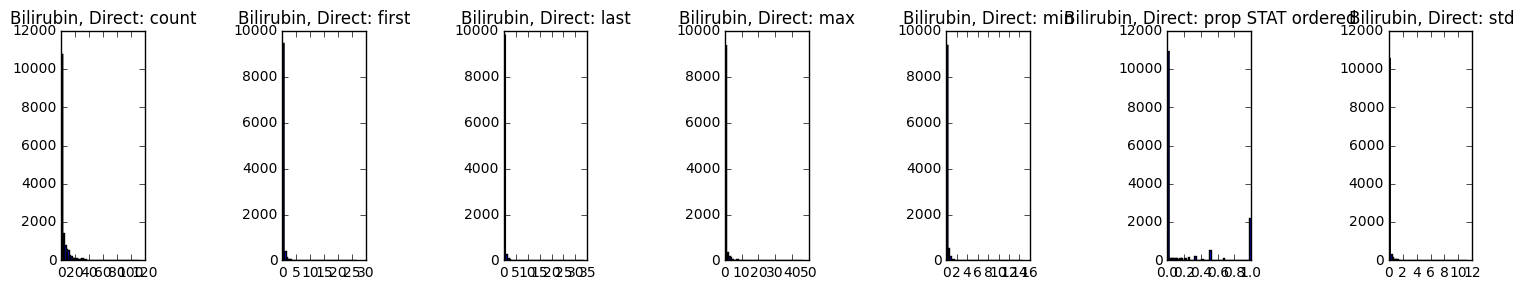

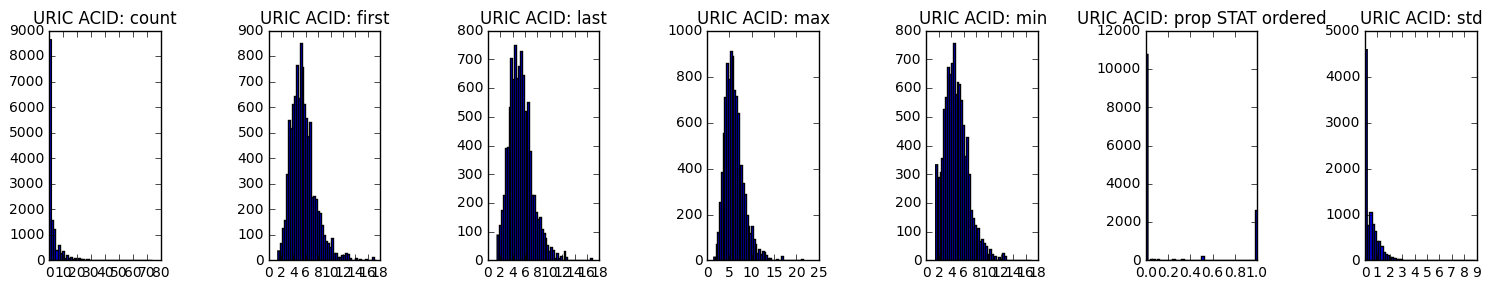

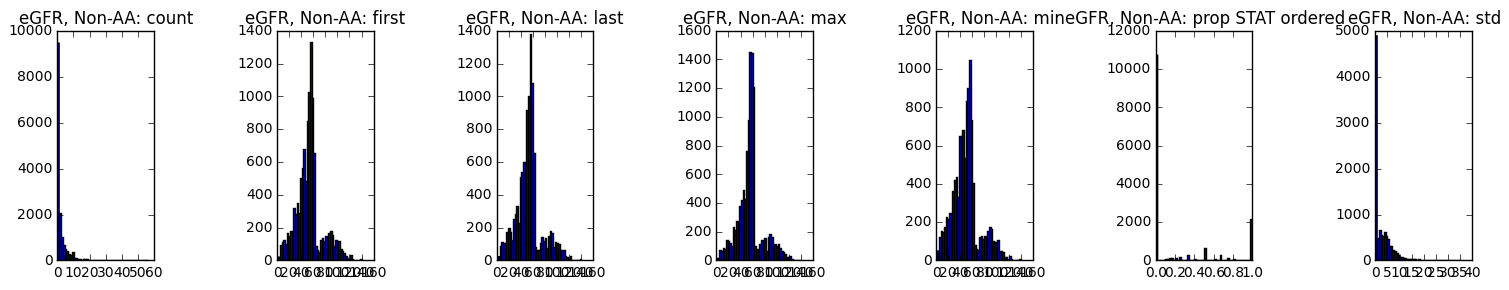

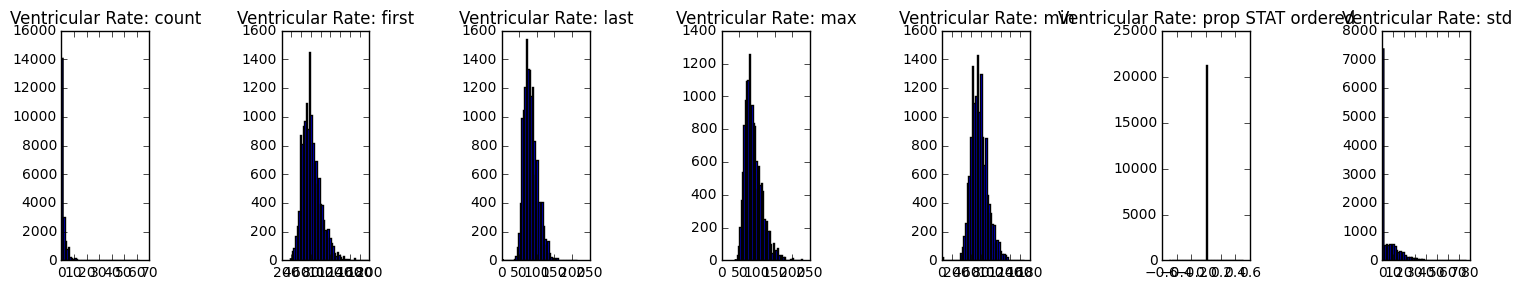

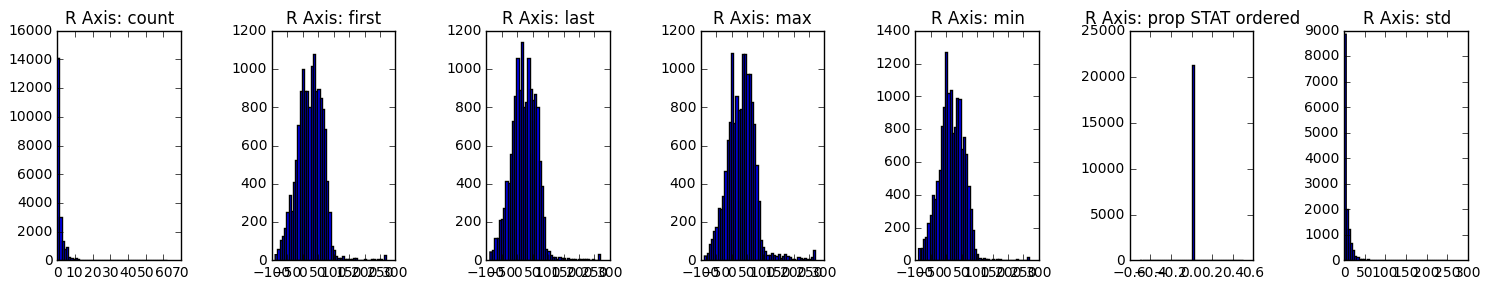

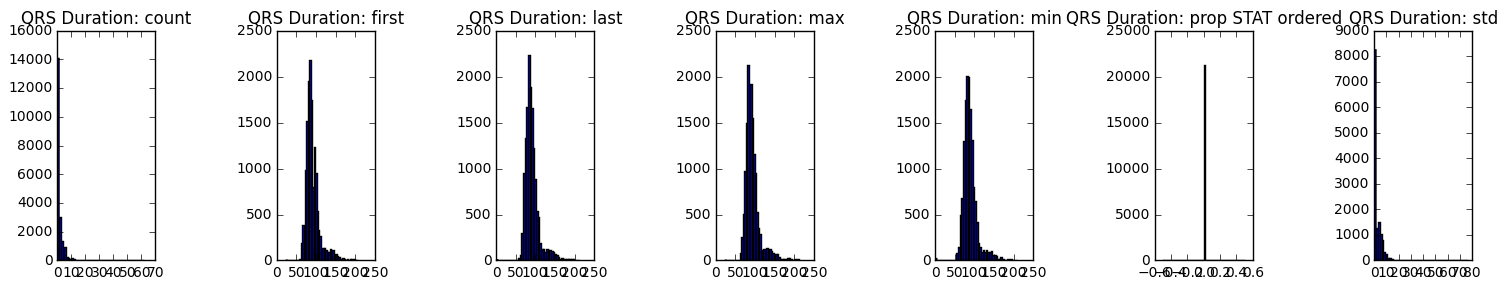

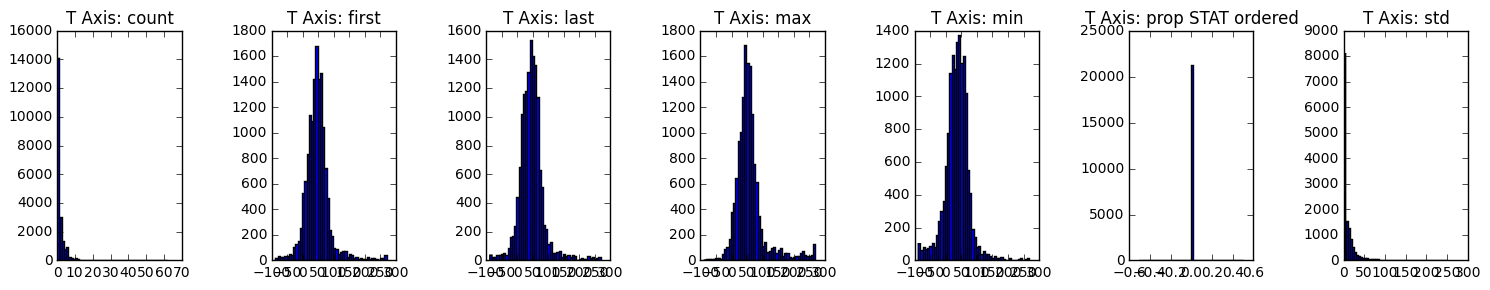

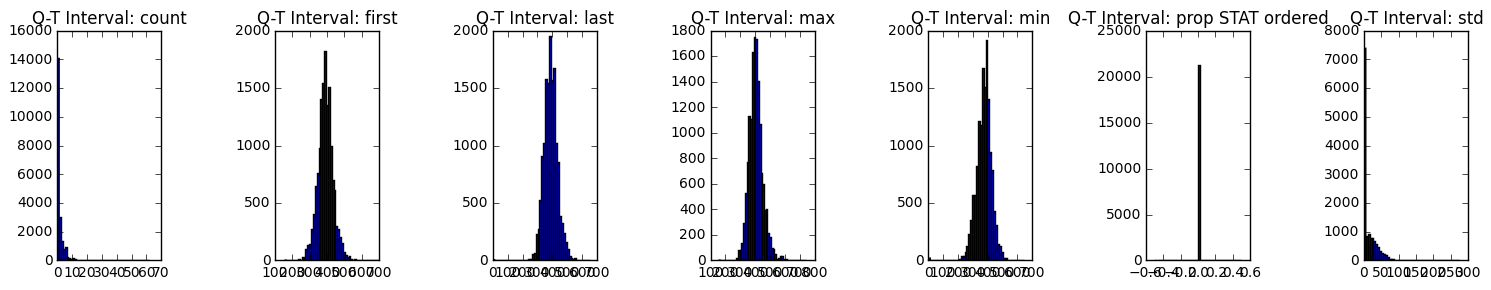

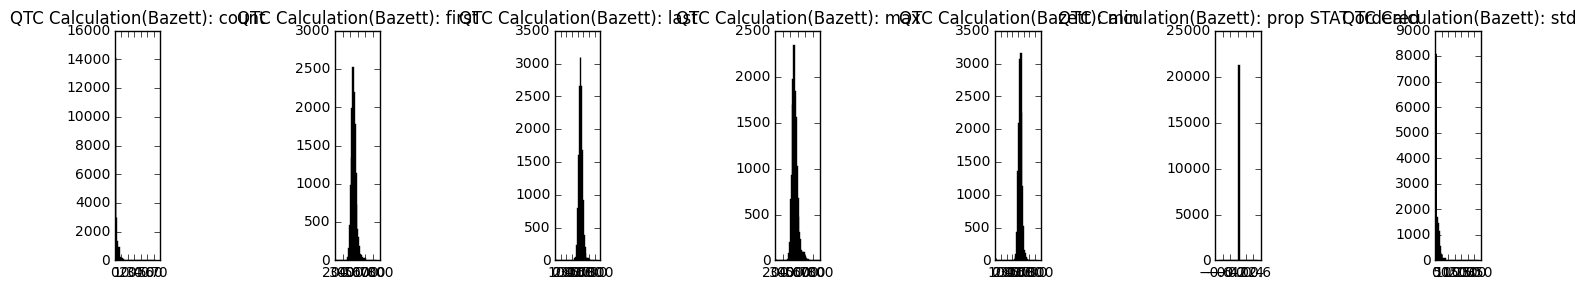

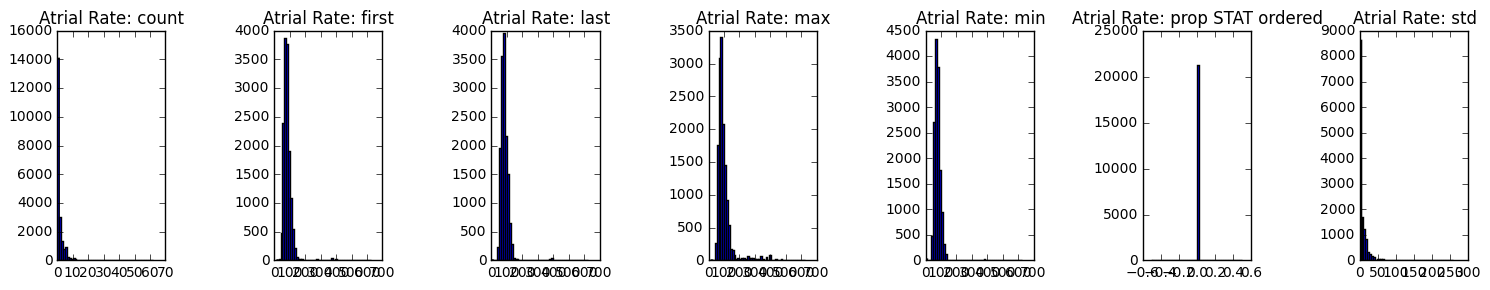

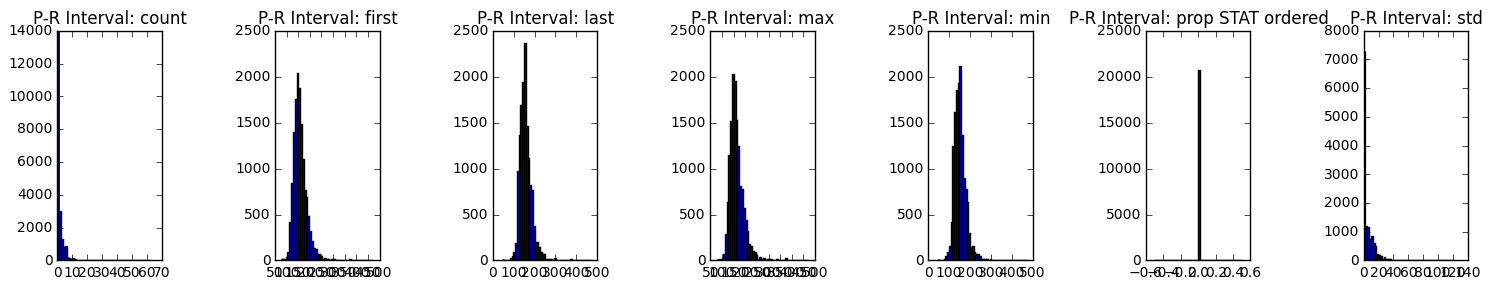

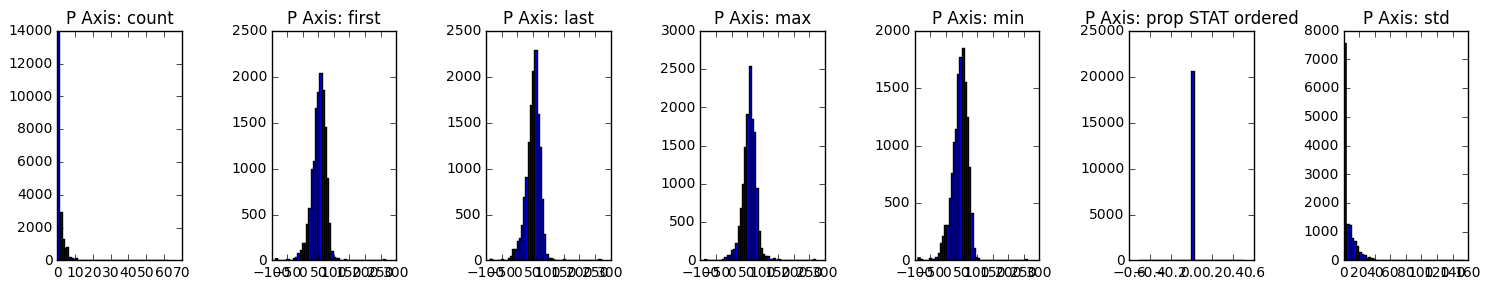

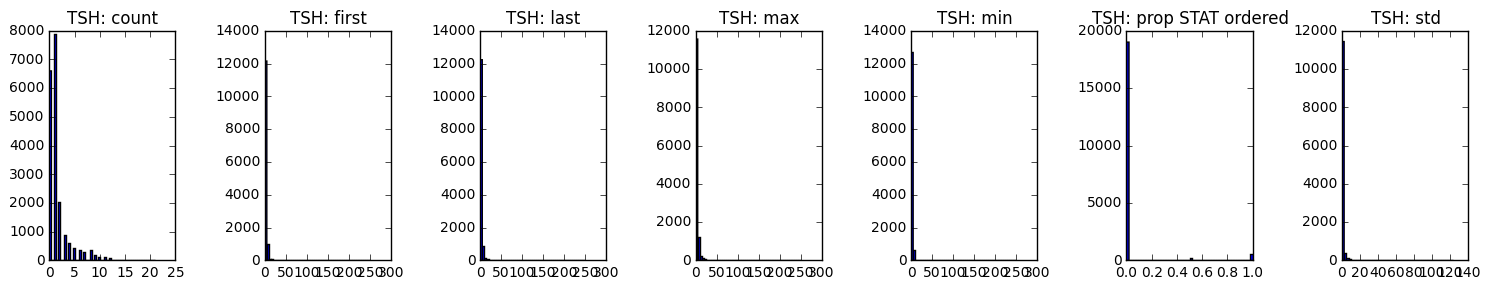

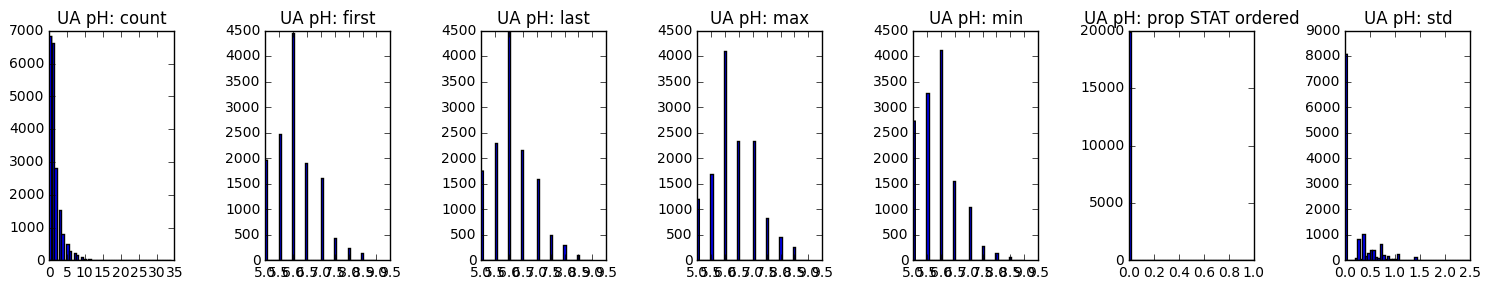

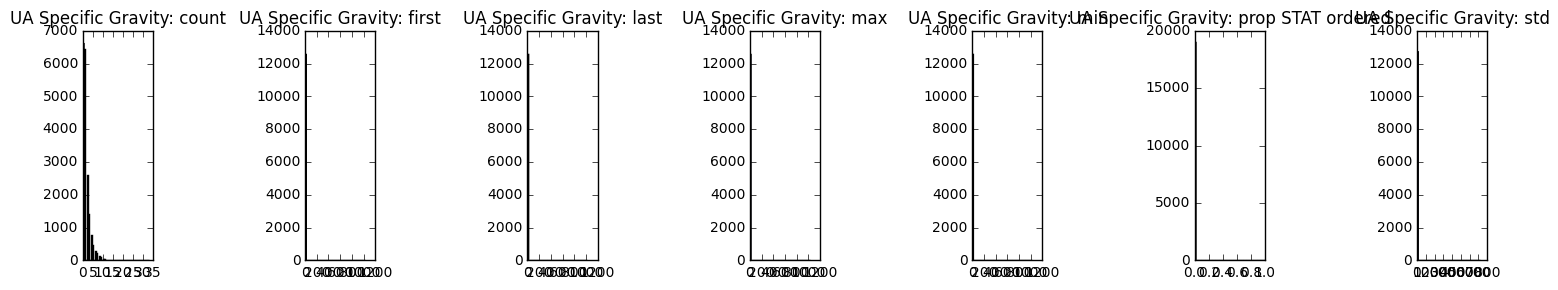

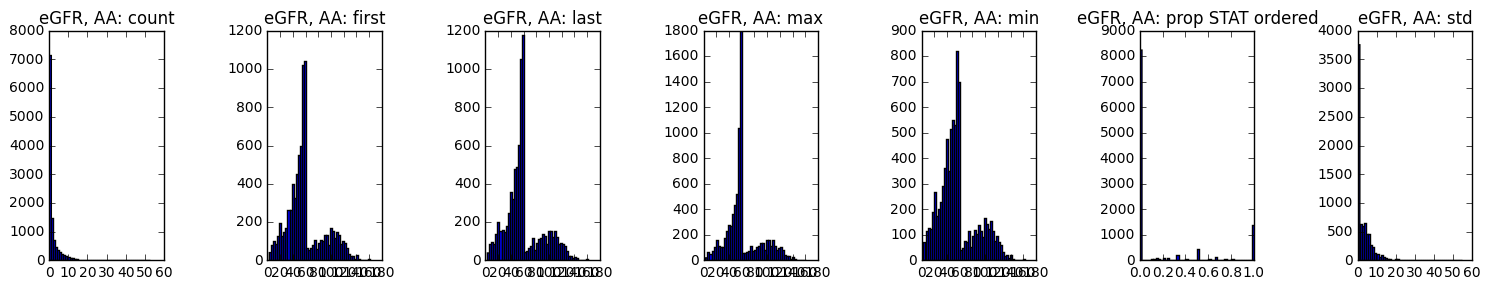

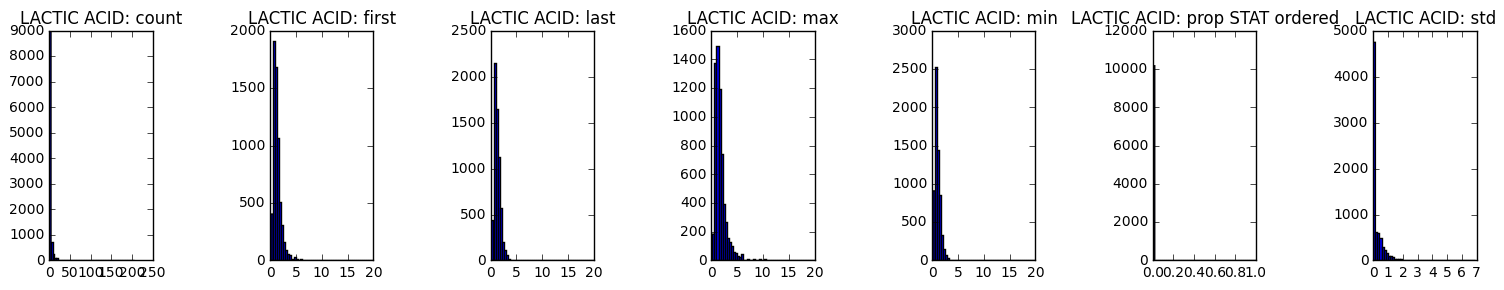

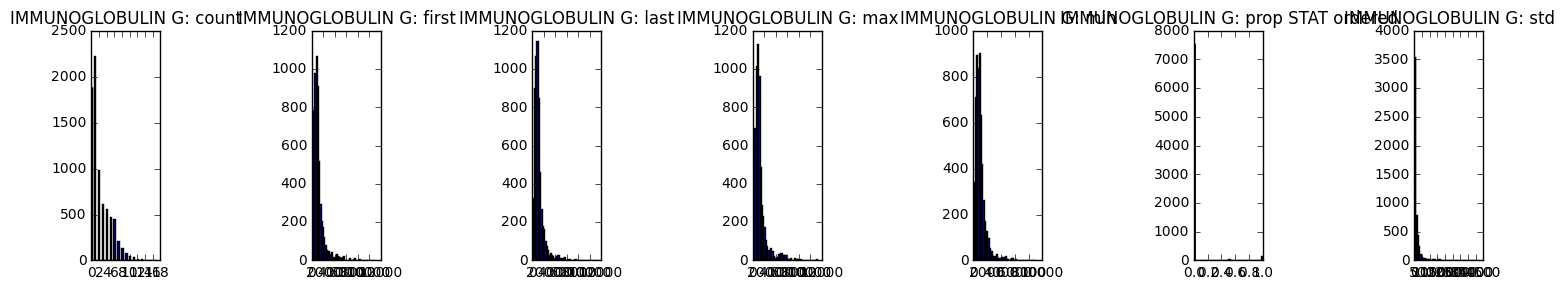

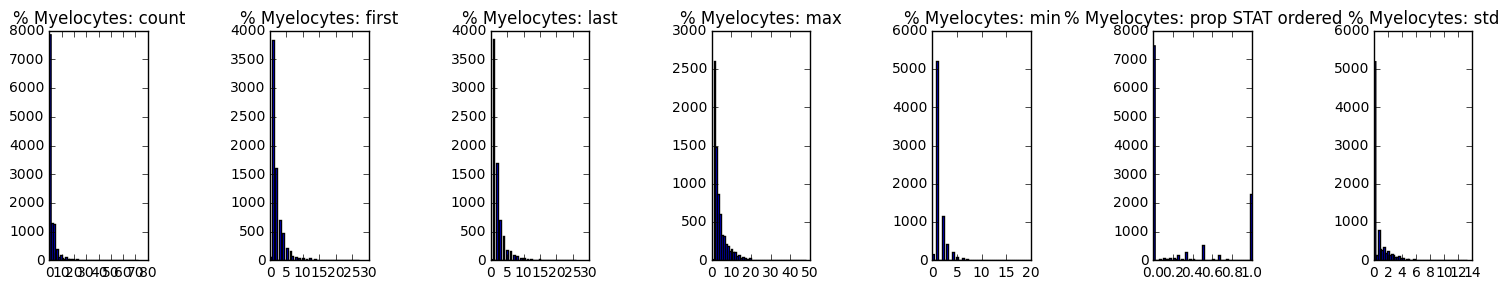

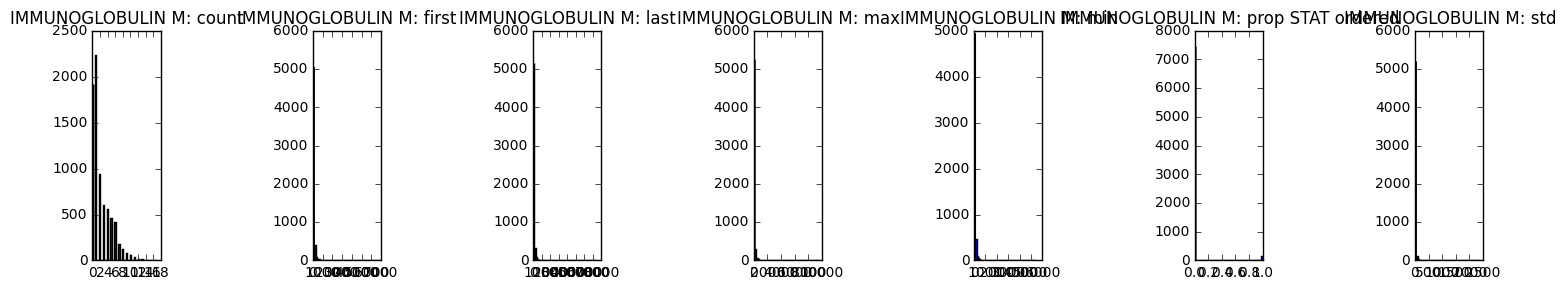

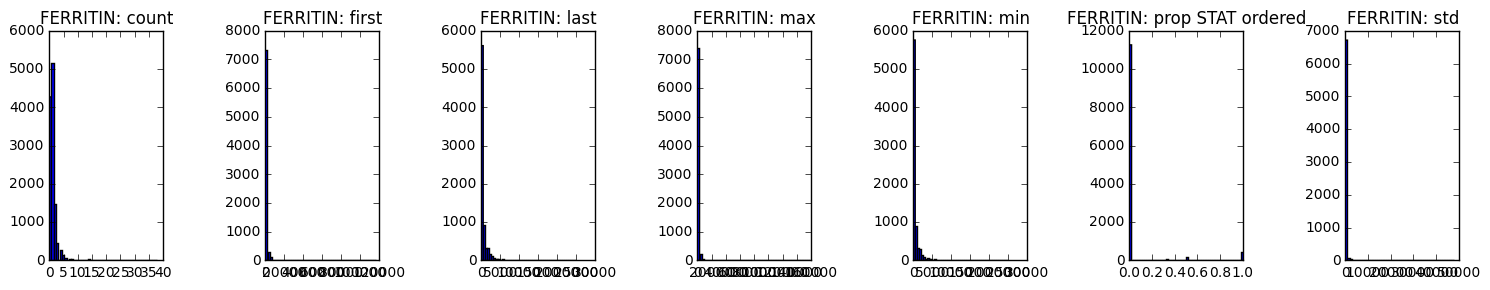

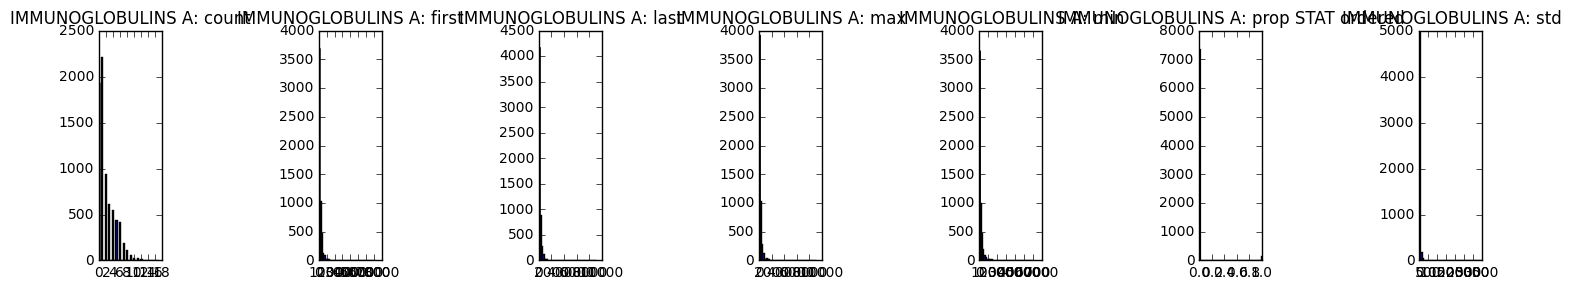

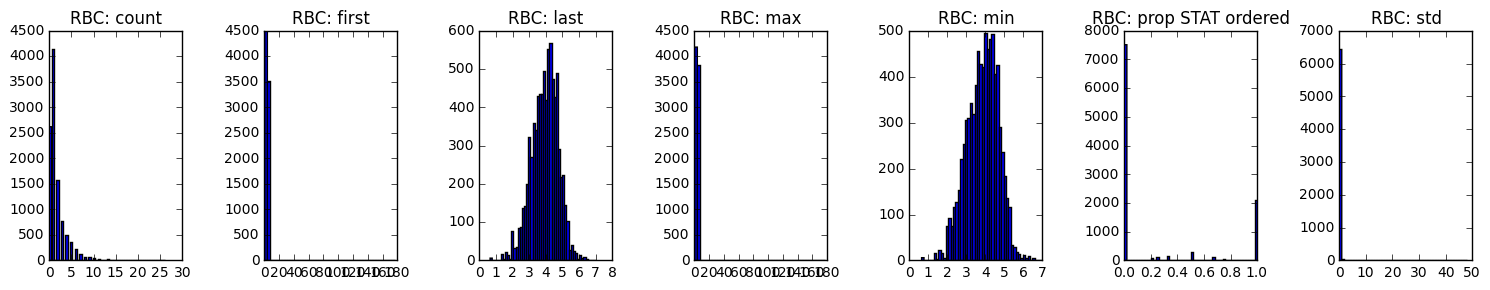

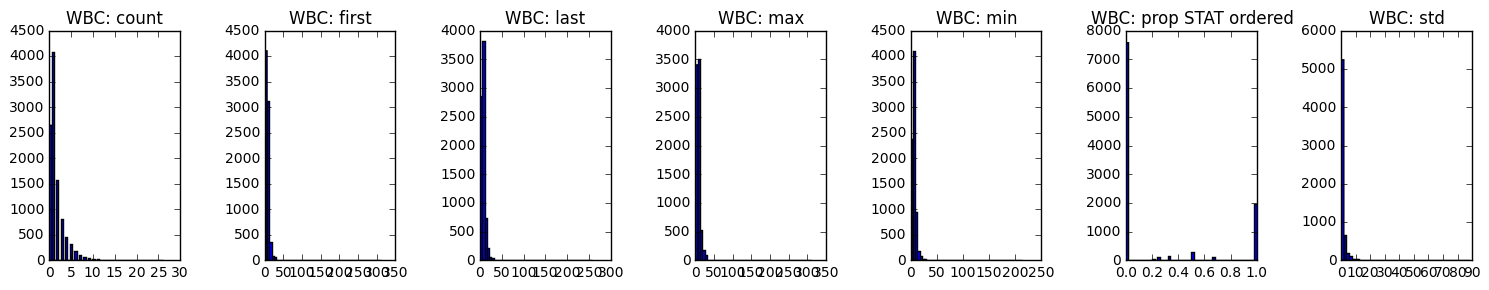

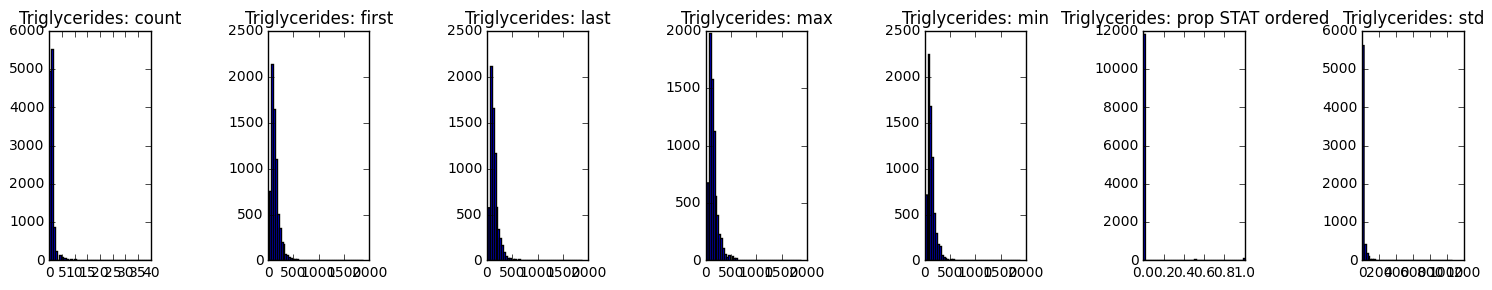

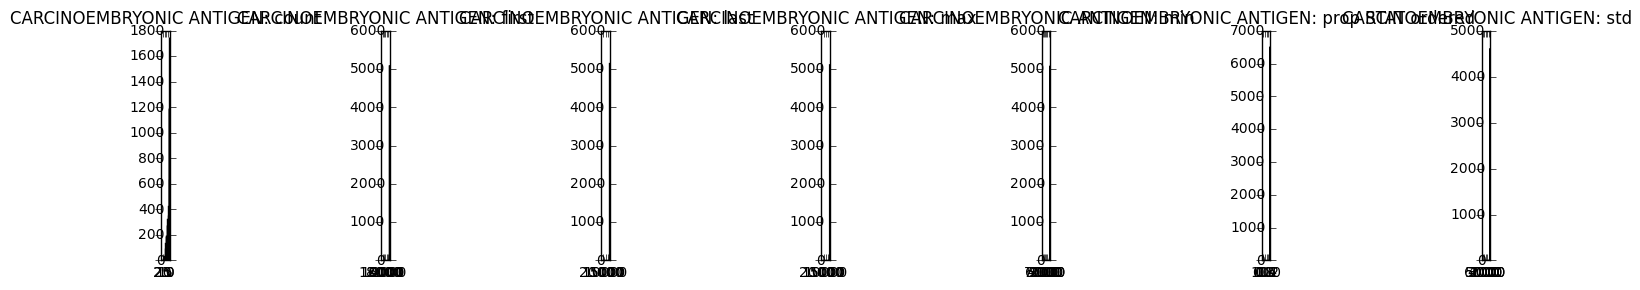

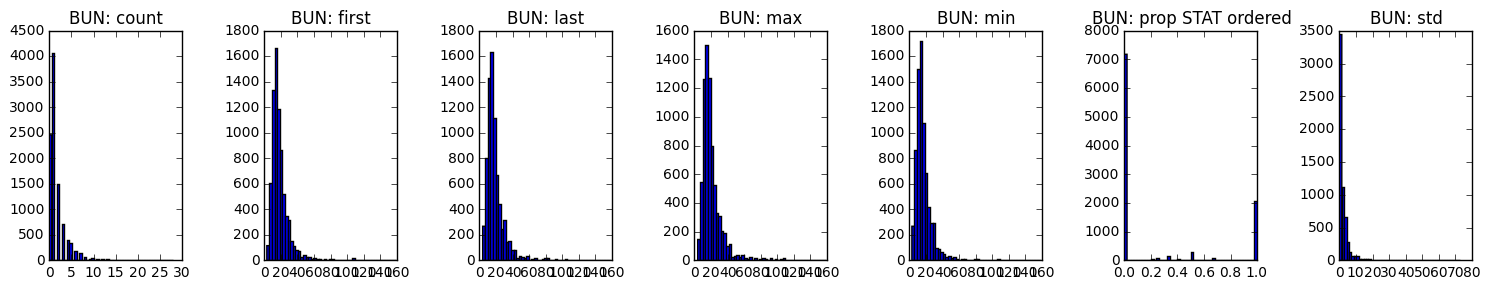

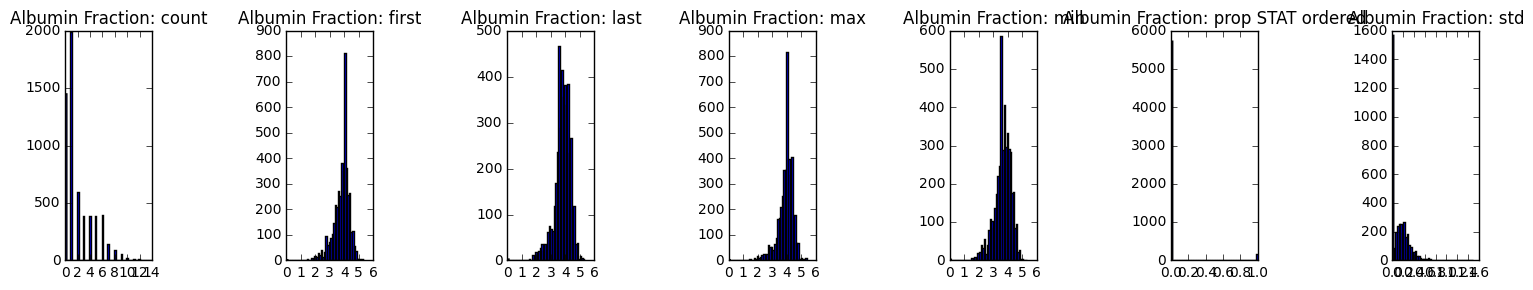

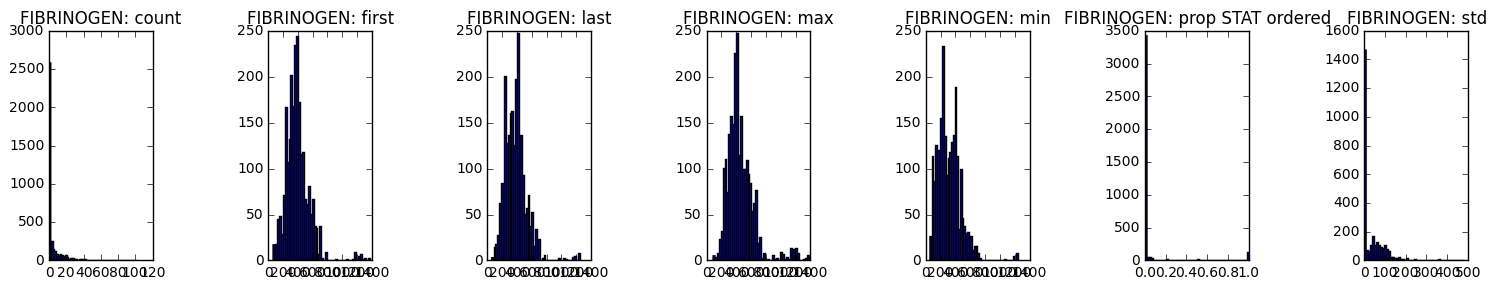

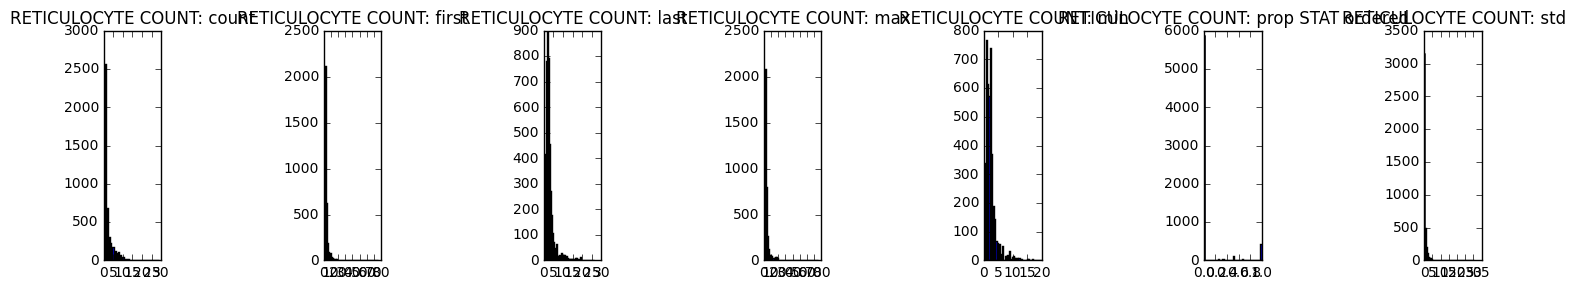

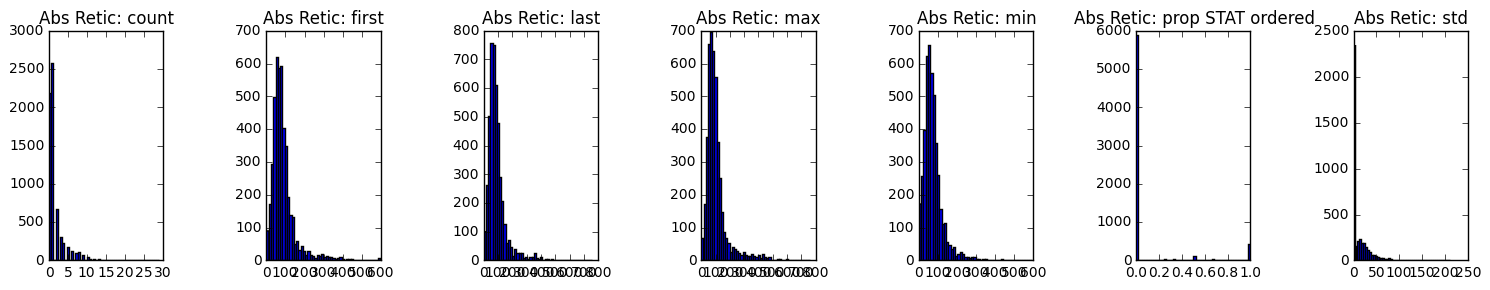

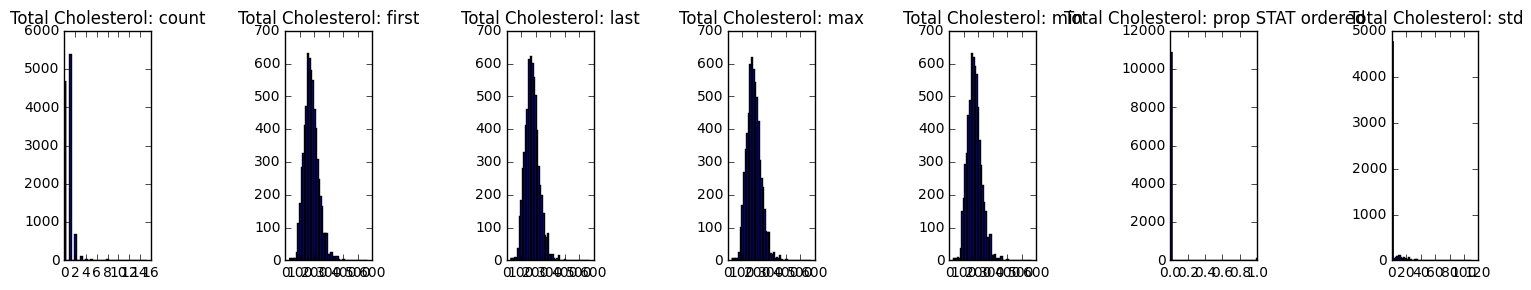

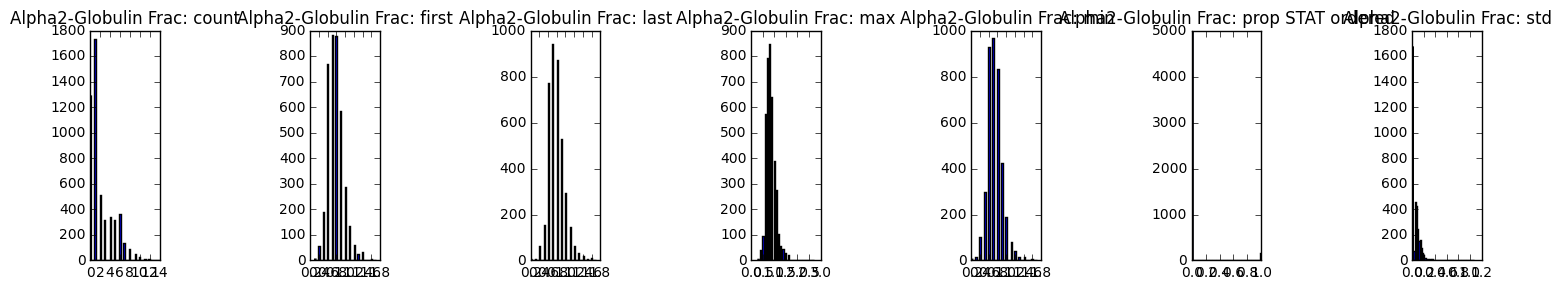

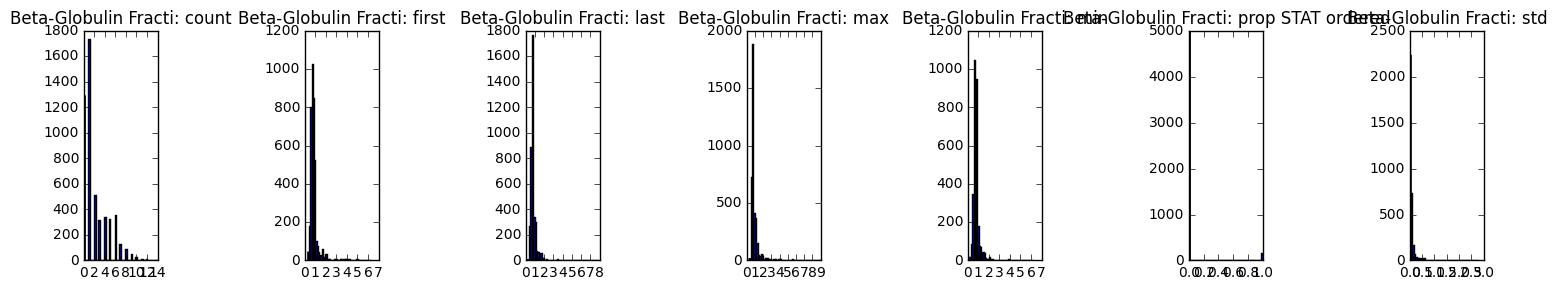

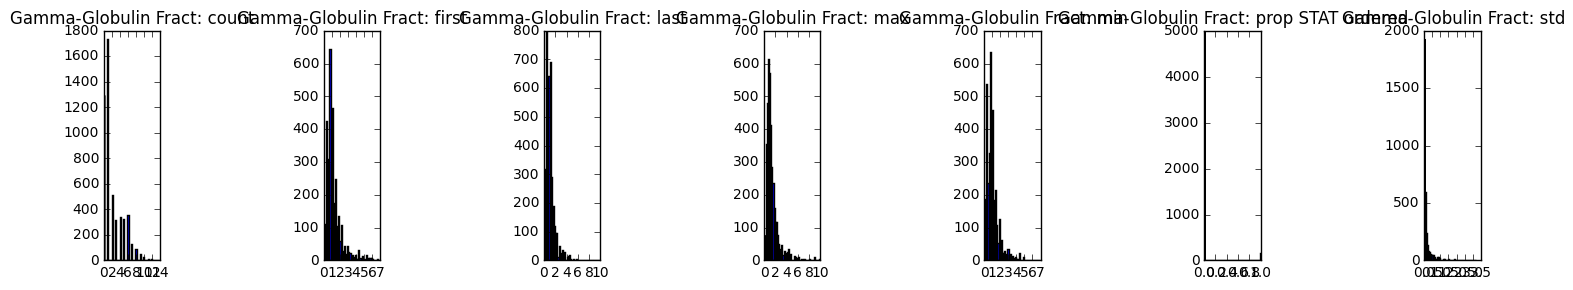

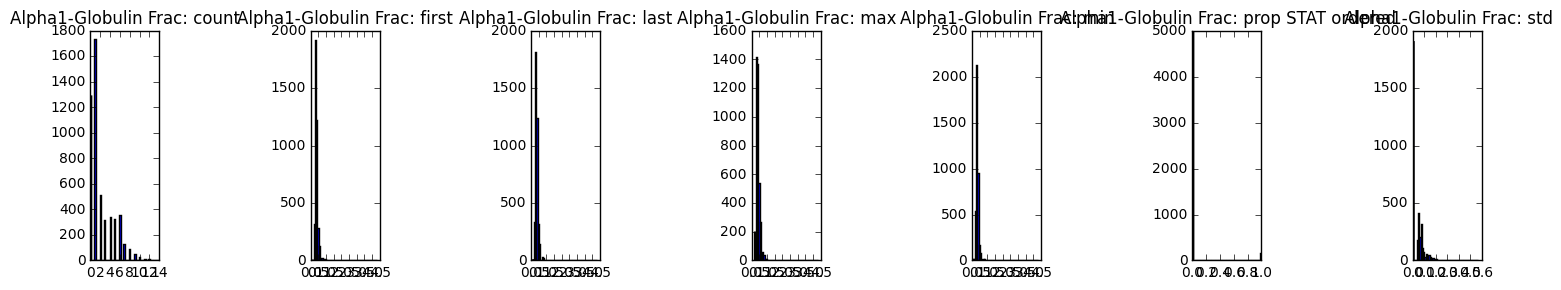

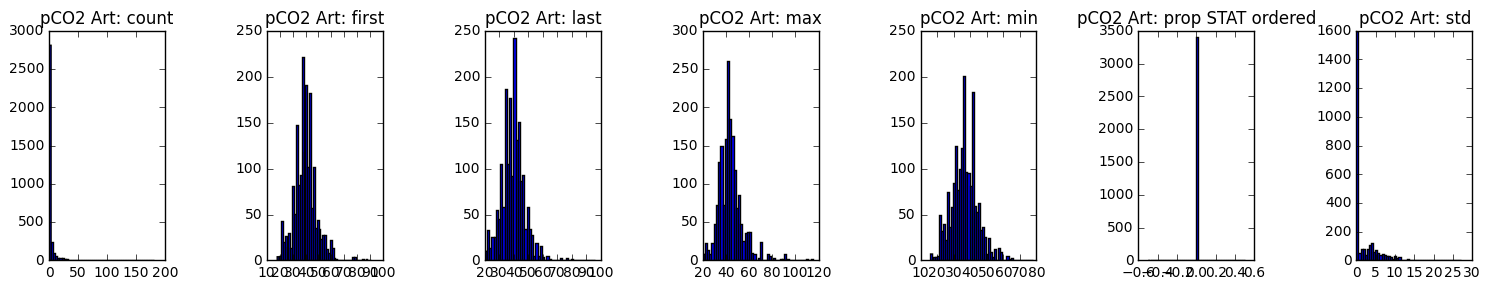

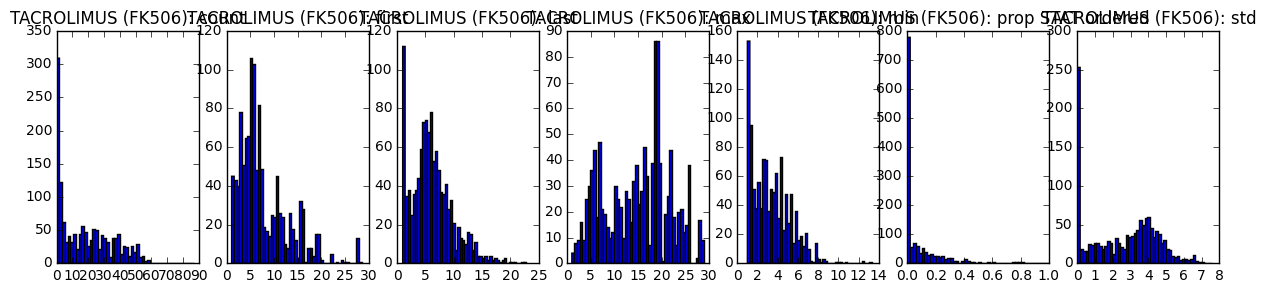

In [40]:
num_cols = [c for c in enc_data if ': ' in c]

binary_missing_cols = []
imputes = {}
tol = 0.01

def safe_float(x):
    try:
        return float(x)
    except:
        return np.nan

for i,col in enumerate(num_cols):
    if col in enc_data:
        enc_data[col] = enc_data[col].apply(safe_float)
        col_count = enc_data[col].count()
        #print col, col_count
        if (i % 7) == 0:
            if i != 0:
                fig.tight_layout()
                plt.show()
            fig, axx = plt.subplots(1,7,figsize=(15,3))
        ax = axx[i%7]
        ax.hist(enc_data[col].dropna().values,bins=50)
        ax.set_title(col)
            
        if (col_count / float(enc_data.shape[0])) < tol:
            print '------ dropping',col, col_count
            del enc_data[col]
        else:
            if (': count' in col) or (': std' in col):
                imputes[col] = 0.0
            else:
                imputes[col] = enc_data[col].median()
            enc_data[col] = enc_data[col].fillna(imputes[col])

In [41]:
imputes

{'# Atypical Lymphocytes: count': 0.0,
 '# Atypical Lymphocytes: first': 0.0,
 '# Atypical Lymphocytes: last': 0.0,
 '# Atypical Lymphocytes: max': 0.0,
 '# Atypical Lymphocytes: min': 0.0,
 '# Atypical Lymphocytes: prop STAT ordered': 0.0,
 '# Atypical Lymphocytes: std': 0.0,
 '# Band Neutrophils: count': 0.0,
 '# Band Neutrophils: first': 0.0,
 '# Band Neutrophils: last': 0.0,
 '# Band Neutrophils: max': 0.09,
 '# Band Neutrophils: min': 0.0,
 '# Band Neutrophils: prop STAT ordered': 0.0,
 '# Band Neutrophils: std': 0.0,
 '# Basophils Manual: count': 0.0,
 '# Basophils Manual: first': 0.0,
 '# Basophils Manual: last': 0.0,
 '# Basophils Manual: max': 0.04,
 '# Basophils Manual: min': 0.0,
 '# Basophils Manual: prop STAT ordered': 0.028985507246376805,
 '# Basophils Manual: std': 0.0,
 '# Basophils: count': 0.0,
 '# Basophils: first': 0.03,
 '# Basophils: last': 0.02,
 '# Basophils: max': 0.06,
 '# Basophils: min': 0.0,
 '# Basophils: prop STAT ordered': 0.3333333333333333,
 '# Basoph

In [42]:
model.update({'imputes': imputes})

import cPickle
with open('Palliative_Data/Palliative_EoL_OutpatientONC_v1_3.p', 'wb') as f:
    cPickle.dump(model, f, cPickle.HIGHEST_PROTOCOL)

In [44]:
to_cats = ['SPECIALTY']
cat_cols = []
for c in to_cats:
    cats = enc_data[c].unique()
    for ca in cats:
        cat_col_name = c + " >>> "+ca
        enc_data[cat_col_name] = (enc_data[c]==ca) * 1.0
        cat_cols.append(cat_col_name)

In [6]:
#enc_data.head()

In [46]:
enc_data['SEX_C'] = enc_data['SEX_C'].astype(float)

In [47]:
enc_data.to_csv('OutpatientONC_v1_1_enc_data_features_v1_3.csv',index=False)
#enc_data = pd.read_csv('OutpatientONC_v1_1_enc_data_features.csv')

# Lab units

In [200]:
q = """
SELECT DISTINCT
  cc.EXTERNAL_NAME,
  o_r.REFERENCE_UNIT
FROM ORDER_RESULTS o_r
  left join CLARITY_COMPONENT cc on cc.COMPONENT_ID = o_r.COMPONENT_ID
WHERE o_r.ORD_NUM_VALUE != 9999999 AND o_r.ORD_NUM_VALUE is not NULL
  AND o_r.RESULT_TIME >= '2015-01-01'
  AND o_r.RESULT_TIME <= '2017-01-01'
  AND o_r.REFERENCE_UNIT is not NULL
  AND cc.EXTERNAL_NAME is not NULL
"""

lab_units = SQLquery2df(q,conn)
lab_units.shape

(5516, 2)

In [201]:
lab_units = lab_units[lab_units['EXTERNAL_NAME'].isin(top_lab_names)]
lab_units = lab_units.sort(['EXTERNAL_NAME','REFERENCE_UNIT'],ascending=False).drop_duplicates('EXTERNAL_NAME')
lab_units.shape

(91, 2)

In [202]:
lab_units_joined = pd.DataFrame({'EXTERNAL_NAME': top_lab_names}).merge(lab_units,how='left',on='EXTERNAL_NAME')
lab_units_joined = lab_units_joined.sort('REFERENCE_UNIT')
lab_units_joined.to_clipboard()

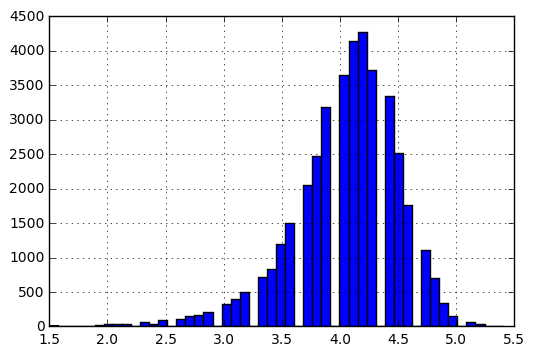

In [203]:
enc_data['Albumin: first'].hist(bins=50)